# Integrated CA 2

### Table of Contents
### 1. Introduction
> ### 1.1 Libraries
> ### 1.2 Functions
### 2. Business Understanding
### 3. Module: Data Preparation
> ### 3.1
> ### 3.2
> ### 3.3
### 4. Module: Statistical Techniques
> ### 4.1
> ### 4.2
> ### 4.3
### 5. Module: Machine Learning
> ### 5.1
> ### 5.2
> ### 5.3

## 1. Introduction

Introduction...

#### 1.1 Libraries

In [1]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statistics as stats
from scipy import stats
#from scipy.stats import shapiro
import math

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

import missingno as msno

from scipy.stats import chi2_contingency


from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

#from sklearn.linear_model import LinearRegression, , ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')




rounding =2 # rounding set here for refinement later

In [2]:
# load dataset
df = pd.read_csv("Employee_Attrition.csv")
df_orgnl = df.copy()

#### 1.2 Some functions used

In [3]:
### This class could still take more methods and be expanded.
class BaselineModelEvaluator():
    # initialisation
    def __init__(self, df, y, y2=None, classify=False):
        self.counter = 1
        # don't overwrite original
        self.df = df.copy()
        self.X = None
        self.y = y
        self.y2 = y2
        self.tar=None
        self.tar_string = None        
        
        # these will be assigned later
        self.encoder = LabelEncoder()
        self.imputer=imputer=SimpleImputer(strategy='mean')
        self.model=LinearRegression()
        self.model2=LogisticRegression()
        
        self.pca=None

        self.pipe = Pipeline([('imputer', self.imputer), ('model', self.model)])
        
        self.drop_second=False

        self.classify = classify
   
    def pipeline(self):
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.tar, test_size=0.2, random_state=659)
        
        # pipeline
        #pipe = self.pipeline
        #pipe = Pipeline([('imputer', self.imputer), ('model', self.model)])

        # impute in sequence
        # impute should only happen here and be skipped when pipeline is fitted next, as there will be no more missing values
        X_train_imputed = self.pipe.named_steps['imputer'].fit_transform(X_train)
        X_test_imputed = self.pipe.named_steps['imputer'].transform(X_test)
        #print(X_train_imputed.shape, X_test_imputed.shape)


        
        # Fit the model
        self.pipe.fit(X_train_imputed, y_train)

        #X_train_imputed_df = pd.DataFrame(X_train_imputed)
        #print(X_train_imputed_df.head())
       
        # predictions
        y_pred = self.pipe.predict(X_test_imputed)

        if self.regression == True:# this prints out r2 for classifier so needs to be examined
            # metrics
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
    
            # Print evaluation metrics
            print(f"{self.counter}. Baseline model for predicting {self.tar_string}")
            self.counter += 1
            print(f"Using: {self.model}, {self.imputer}, {self.encoder}")
            print(f"Drop second target = {self.drop_second}") # rephrase this
            print(f"Mean Squared Error (MSE): {mse}")
            print(f"R-squared (R2): {r2}")
            print("\n")

        elif self.regression == False:
            # Convert to categorical and round predictions
            y_test_cat = pd.Categorical(y_test)
            y_pred_rounded = y_pred.round().astype(int)

            
            # metrics
            #print("y_test: ", y_test)
            #print("y_pred: ", y_pred)
            accuracy = accuracy_score(y_test_cat, y_pred_rounded)
            # Print evaluation metrics
            print(f"{self.counter}. Baseline model for predicting {self.tar_string}")
            self.counter += 1
            print(f"Using: {self.model}, {self.imputer}, {self.encoder}")
            print(f"Drop second target = {self.drop_second}")
            print(f"Accuracy: {accuracy:.2f}")
            print("\n")
                
    #### missing categores should be handled here ####
    def encode_categories(self):
        # encoding categories
        categorical_columns = self.df.select_dtypes(include=['object']).columns.tolist()
        self.df = pd.get_dummies(self.df, columns=categorical_columns, dummy_na=True)


    def impute_targets(self):     
        # impute y with mean
        self.df[self.y] = self.df[self.y].fillna(self.df[self.y].mean())
        if self.y2:
            self.df[self.y2] = self.df[self.y2].fillna(self.df[self.y2].mean())
            
    def model_y(self):
        # model target
        self.tar = self.df[self.y]
        self.tar_string = self.y
        self.X = self.df.drop(self.y, axis=1)
        if self.drop_second == True:
            self.X = self.X.drop(self.y2, axis=1)
        self.pipeline()
        self.drop_second=False
    
    def model_y2(self):
        # model secondary target if there is one
        if self.y2 is not None:
            self.tar = self.df[self.y2]
            self.tar_string = self.y2
            self.X = self.df.drop(self.y2, axis=1)
            if self.drop_second == True:
                self.X = self.X.drop(self.y, axis=1)
            self.pipeline()
            self.drop_second = False
        else:
            pass
        
    def set_model(self, model=None, model2=None, imputer=None, encoder=None, pipe=None):
        # set modelling attributes
        # can add more stuff here
        if encoder is not None:
            self.encoder = encoder
        if imputer is not None:
            self.imputer = imputer
        if model is not None:
            self.model = model
        if model2 is not None: # use this model for classification as it is set later
            self.model = model2
        if pipe is not None:
            self.pipe = pipe

    def targets_as_cat(self):
        self.df[self.y] = self.df[self.y].round(0).astype(int)
        self.df[self.y] = pd.Categorical(self.df[self.y])
        try:
            self.df[self.y2] = self.df[self.y2].round(0).astype(int)
            self.df[self.y2] = pd.Categorical(self.df[self.y2])
        except:
            pass
        


    def baseline_models(self, title=""):
        # could form full title here
        if len(title) > 1:
            title = "for " + title
        
        title_string = f"Baseline models report {title}\n"
        print(title_string)
        # this method to run the different pipelines and parts of above model moved to init
        self.encode_categories()
        self.impute_targets() # mean impuation for targets, not used later when targets have no missing values

        self.regression = True
        # regression analysis
        self.model_y()
        self.drop_second=True
        self.model_y()
        if self.y2 is not None:
            self.drop_second=False
            self.model_y2()
            self.drop_second=True
            self.model_y2()

        self.regression = False
        # classification
        if self.classify == True:
            self.targets_as_cat()
            self.model = self.model2 # set classification model
            print("Report Part 2: Classification")
            self.drop_second=False
            self.model_y()
            self.drop_second=True
            self.model_y()
            if self.y2 is not None:
                self.drop_second=False
                self.model_y2()
                self.drop_second=True
                self.model_y2()
            
        

In [4]:
#baseline = BaselineModelEvaluator(df, "PerformanceRating", "JobSatisfaction", classify=True)
#baseline.baseline_models()

In [5]:
#baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=True)
#baseline.set_model(model=SVR())
#baseline.baseline_models()

In [6]:
# histogram
def histogram(df, var, x_size=4, y_size=4, x_label="Values", y_label="Frequency",
              bins=10, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(x_size, y_size))
    
    sns.histplot(data=df, x=var, kde=False, bins=bins, color='green', ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = f"Histogram of {var}"
    ax.set_title(title)
    
    if ax is None:
        plt.show()

In [7]:
# Boxplot
def boxplot(df, var, x_size=4, y_size=4, x_label="Values", y_label="Frequency", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(x_size, y_size))

    sns.boxplot(data=df, x=var, ax=ax, color='skyblue')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = f"Boxplot of {var}"
    ax.set_title(title)
    
    if ax is None:
        plt.show()

In [8]:
# printing statistical information out beside graph for analysis
# could possibly leave out boxplot from this and look at box plots together

def numerical_explore(df, var, bins=15, title=""):
    # 15 as default bins in histogram function
    
    # copy dataframe
    df1 = df.copy()

    # removing null values for graphing
    df1.dropna(subset=[var], inplace=True)
    # check for null values
    if df1[var].isnull().sum() > 0 : print(f"{var} contains null values.")

    # 3 plots each for now
    #fig, axs = plt.subplots(1,3, figsize=(13, 5))
    fig, axs = plt.subplots(1,3, figsize=(9, 3))
    
    # title
    if len(title) > 1:
        title = ", " + title
    
    fig.suptitle(f"Exploration of {var}{title}", fontsize=16)


    ### could do a table of results ###


    ### choose here if numeric or categorical
    # this should work
    if pd.api.types.is_numeric_dtype(df[var]):

        # maybe some descriptive statistics here
        #print(f"{var} is numeric")      

        # using 3 plots atm for numeric colums
        #fig, axs = plt.subplots(1,3, figsize=(13, 5))
        # title
        #fig.suptitle(f"Exploration of {var}", fontsize=16)
    
    
        # histogram
        axs[0] = histogram(df1, var, bins=bins, ax=axs[0])
    
        # shapiro-wilk test
        stat, p_value = stats.shapiro(df1[var])
        if p_value > 0.05:
            gaus ="Sample looks Gaussian (fail to reject H0)"
        else:
            gaus = f"""Sample does not look Gaussian (reject H0)
            p-value of {p_value}"""
    
        # generate statistical information
        statistics = f"""Statistical Information for {var}
        
        {df1[var].describe()}
        
        Range : {(df1[var].max()-df1[var].min())}
        IQR : {(df1[var].quantile(0.75)-df1[var].quantile(0.25))}
        
        Skew : {stats.skew(df1[var])}
        
        {gaus}"""
        
        
        # statistical information axis
        axs[1].text(0,1, statistics, ha="left", va="top", fontsize=8)
        axs[1].axis("off")
    
        # boxplot
        axs[2] = boxplot(df1, var, ax=axs[2])

    # this doesn't check any other condition as it's only two types of data being passed through this func
    else: # pd.api.types.is_categorical_dtype(df[var]):
        # possibly desc stats here too
        #print(f"{var} is categorical")

        # histogram
        axs[0] = histogram(df1, var, bins=bins, ax=axs[0])

        statistics = f"""Statistical Information for {var}

        {df1[var].value_counts()}"""
        

        # statistical information axis
        axs[1].text(0,1, statistics, ha="left", va="top", fontsize=8)
        axs[1].axis("off")

        # setting ax to blank
        axs[2].axis("off")
    
    # show plot
    plt.tight_layout() 
    plt.show()

In [9]:
# takes a list input
def drop_missing_from_target(df, target=["JobSatisfaction", "PerformanceRating"]):
    for i in target:
        df = df.dropna(subset=i)
    return df

In [10]:
### unused for now ### 
def basline_experiment(df, title="", context="", result="", classify=False):
    print("Title: " + title.capitalize() + "\n\n")

    print("Context:\n" + context + "\n\n")

    print("Result:\n" + result + "\n\n")


    
    
    data = df.copy()

    #### Imputation ####
    print("IMPUTATION TRIALS\n")

    # mean imputation
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    #baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('scaler', MinMaxScaler()),('model', baseline.model)]))
    baseline.set_model(imputer=SimpleImputer(strategy='mean'))
    baseline.baseline_models(title="Mean Imputation")
    
    # with KNNImputer
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(imputer=KNNImputer(n_neighbors=3))
    baseline.baseline_models(title="KNN Imputation")
    
    # with Iterative Imputer
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(imputer = IterativeImputer(max_iter=10, random_state=0))
    baseline.baseline_models()


    #### Scaling ####
    print("SCALING TRIALS\n")

    # standard scaler
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('scaler', StandardScaler()),('model', baseline.model)]))
    baseline.baseline_models(title="Standard Scaler")
    
    # min-max scaler
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('scaler', MinMaxScaler()),('model', baseline.model)]))
    baseline.baseline_models("Min-Max Scaler")


    #### Encoding ####
    print("ENCODING TRIALS\n")

    # one hot encoder
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(encoder=OneHotEncoder())
    baseline.baseline_models()


    #### Dimmensionality Reduction ####
    print("DIMENSIONALITY REDUCTION TRIALS\n")

    
    # with PCA
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('pca', PCA(.995)),('model', baseline.model)]))
    baseline.baseline_models()
    
    # with LDA
    #baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction")
    #baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('lda', LDA()),('model', baseline.model)]))
    #baseline.baseline_models()


    #### Modeling ####
    #print("MODELLING TRIALS\n")

    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction")
    baseline.set_model(model2=DecisionTreeClassifier())
    baseline.baseline_models()

In [11]:
def round_and_encode(df, cols):
    # removing decimals
    df[cols] = df[cols].round(0)#.astype(int) # maybe convert to int alone does this
                                             # but may round up or do something else
    
    # Convert 'Over18' column to categorical
    df[cols] = df[cols].astype('object')

    return df

## 2. Business Understanding

Integrated CA with three main tasks: Data Prep, Statistics, Machine Learning

Data prep: The objective is to investigate the influence of data preparation techniques.
Appropriate data preparation techniques and rational, including visualisations.

Stats: Investigate interesting relationships in the data
Statistical exploration of the data

Machine Learning: Model the data.
A model is a representation of the data. The business targets may not be appropriate to 



## 3. Module: Data Preparation

### 3.1 Characterisation of the data set: size; number of attributes; has/does not have missing values, number of observations etc.

In [12]:
df.head()

Age Attrition     BusinessTravel    DailyRate  \
0  41.920786       Yes      Travel_Rarely   990.110009   
1  51.589037        No  Travel_Frequently   276.776030   
2  33.131540       Yes      Travel_Rarely  1204.158501   
3  34.707073        No  Travel_Frequently  1352.752432   
4  24.790188        No      Travel_Rarely   485.053333   

               Department  DistanceFromHome  Education EducationField  \
0                   Sales          1.016716   1.770313  Life Sciences   
1  Research & Development               NaN   1.035333  Life Sciences   
2  Research & Development          2.198662   2.118801          Other   
3                   Sales          2.937851   3.670674  Life Sciences   
4  Research & Development          1.988953   1.120496        Medical   

   EmployeeCount  EmployeeNumber  ...  RelationshipSatisfaction StandardHours  \
0       1.033298        1.054148  ...                  1.012832     95.612654   
1       0.944859        2.107031  ...                  4.312008     85.370868   
2       0.810809        4.008125  ...                  2.332558     76.248084   
3       0.822976        4.587269  ...                  3.029591     75.888697   
4            NaN        7.228740  ...                       NaN     72.670937   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  \
0          0.000000           8.063833               0.000000        1.052104   
1          1.104642           8.965059               3.264952        2.526470   
2          0.000000           8.427238               3.004521        2.924784   
3          0.000000           7.662606               2.856001        3.117053   
4          0.953012           6.241733               2.814719        3.112317   

   YearsAtCompany YearsInCurrentRole  YearsSinceLastPromotion  \
0        5.795945           3.993896                 0.000000   
1       10.070232           7.937505                 1.032295   
2        0.000000           0.000000                 0.000000   
3        8.435324           5.563667                 2.845429   
4        2.040124           1.970786                 2.495949   

   YearsWithCurrManager  
0              4.594972  
1              5.901207  
2              0.000000  
3              0.000000  
4              2.219353  

[5 rows x 35 columns]

In [13]:
df.shape

(1470, 35)

In [14]:
df.describe().T

count          mean          std          min  \
Age                       1323.0     36.635268     9.882161    14.544608   
DailyRate                 1323.0    802.030050   414.031025    86.828045   
DistanceFromHome          1323.0      9.091097     8.177870     0.750112   
Education                 1323.0      2.923447     1.072203     0.770362   
EmployeeCount             1323.0      0.999325     0.099656     0.628985   
EmployeeNumber            1323.0   1026.679166   610.480802     1.054148   
EnvironmentSatisfaction   1323.0      2.726443     1.129679     0.759655   
HourlyRate                1323.0     65.647722    21.469709    23.855272   
JobInvolvement            1323.0      2.743028     0.765568     0.722008   
JobLevel                  1323.0      2.058270     1.127018     0.715172   
JobSatisfaction           1323.0      2.715272     1.146786     0.724192   
MonthlyIncome             1323.0   6544.718401  4766.580903   891.481007   
MonthlyRate               1323.0  14364.334764  7269.420895  1567.502382   
NumCompaniesWorked        1323.0      2.654394     2.508952     0.000000   
PercentSalaryHike         1323.0     15.295717     3.995702     7.684723   
PerformanceRating         1323.0      3.149344     0.476027     2.116951   
RelationshipSatisfaction  1323.0      2.720431     1.115959     0.720696   
StandardHours             1323.0     80.241313     8.022535    53.793059   
StockOptionLevel          1323.0      0.814757     0.863076     0.000000   
TotalWorkingYears         1323.0     11.426152     8.075870     0.000000   
TrainingTimesLastYear     1323.0      2.811756     1.329044     0.000000   
WorkLifeBalance           1323.0      2.762825     0.761802     0.799138   
YearsAtCompany            1323.0      6.933624     6.046798     0.000000   
YearsInCurrentRole        1323.0      4.233363     3.658111     0.000000   
YearsSinceLastPromotion   1323.0      2.160710     3.221481     0.000000   
YearsWithCurrManager      1323.0      4.117695     3.594053     0.000000   

                                  25%           50%           75%  \
Age                         29.624982     34.951950     42.748741   
DailyRate                  456.479553    782.958705   1130.577949   
DistanceFromHome             2.147069      6.920808     13.584900   
Education                    2.122706      3.015658      3.700560   
EmployeeCount                0.931146      0.998949      1.067371   
EmployeeNumber             501.854842   1022.025017   1533.811096   
EnvironmentSatisfaction      1.894818      2.887313      3.676600   
HourlyRate                  47.701897     64.934490     83.038355   
JobInvolvement               2.177638      2.859143      3.179128   
JobLevel                     1.045228      1.936150      2.609707   
JobSatisfaction              1.846039      2.895032      3.676663   
MonthlyIncome             2961.844066   4957.070475   8268.002496   
MonthlyRate               8138.576694  14258.293365  20322.279885   
NumCompaniesWorked           0.948843      1.708812      3.959710   
PercentSalaryHike           12.195197     14.495151     17.745736   
PerformanceRating            2.845502      3.064551      3.335525   
RelationshipSatisfaction     1.909010      2.891235      3.639961   
StandardHours               74.882946     80.351400     85.664169   
StockOptionLevel             0.000000      0.913651      1.082523   
TotalWorkingYears            5.953221      9.306742     15.324548   
TrainingTimesLastYear        1.967328      2.690934      3.366949   
WorkLifeBalance              2.193390      2.899807      3.206117   
YearsAtCompany               2.673269      5.422160      9.238005   
YearsInCurrentRole           1.824392      2.968874      7.052591   
YearsSinceLastPromotion      0.000000      0.967140      2.586631   
YearsWithCurrManager         1.687177      2.939240      6.987964   

                                   max  
Age                          69.402515  
DailyRate                  1

In [15]:
df.describe(include="object").T

count unique                     top  freq
Attrition       1323      2                      No  1065
BusinessTravel  1323      3           Travel_Rarely   890
Department      1323      3  Research & Development   824
EducationField  1323      6           Life Sciences   504
Gender          1323      2                    Male   783
JobRole         1323      9         Sales Executive   281
MaritalStatus   1323      3                 Married   596
Over18          1323      1                       Y  1323
OverTime        1323      2                      No   929

In [16]:
num =len(df.select_dtypes(include="number").columns)
obj = len(df.select_dtypes(include="object").columns)

print(f"Number of numerical features: {num}")
print(f"Number of categorical features: {obj}")

Number of numerical features: 26
Number of categorical features: 9


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1323 non-null   float64
 1   Attrition                 1323 non-null   object 
 2   BusinessTravel            1323 non-null   object 
 3   DailyRate                 1323 non-null   float64
 4   Department                1323 non-null   object 
 5   DistanceFromHome          1323 non-null   float64
 6   Education                 1323 non-null   float64
 7   EducationField            1323 non-null   object 
 8   EmployeeCount             1323 non-null   float64
 9   EmployeeNumber            1323 non-null   float64
 10  EnvironmentSatisfaction   1323 non-null   float64
 11  Gender                    1323 non-null   object 
 12  HourlyRate                1323 non-null   float64
 13  JobInvolvement            1323 non-null   float64
 14  JobLevel

In [18]:
df.isnull().sum()

Age                         147
Attrition                   147
BusinessTravel              147
DailyRate                   147
Department                  147
DistanceFromHome            147
Education                   147
EducationField              147
EmployeeCount               147
EmployeeNumber              147
EnvironmentSatisfaction     147
Gender                      147
HourlyRate                  147
JobInvolvement              147
JobLevel                    147
JobRole                     147
JobSatisfaction             147
MaritalStatus               147
MonthlyIncome               147
MonthlyRate                 147
NumCompaniesWorked          147
Over18                      147
OverTime                    147
PercentSalaryHike           147
PerformanceRating           147
RelationshipSatisfaction    147
StandardHours               147
StockOptionLevel            147
TotalWorkingYears           147
TrainingTimesLastYear       147
WorkLifeBalance             147
YearsAtC

In [19]:
# missing data seems like 10 random data points from each column?
df.isnull().head()

Age  Attrition  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0  False      False           False      False       False             False   
1  False      False           False      False       False              True   
2  False      False           False      False       False             False   
3  False      False           False      False       False             False   
4  False      False           False      False       False             False   

   Education  EducationField  EmployeeCount  EmployeeNumber  ...  \
0      False           False          False           False  ...   
1      False           False          False           False  ...   
2      False           False          False           False  ...   
3      False           False          False           False  ...   
4      False           False           True           False  ...   

   RelationshipSatisfaction  StandardHours  StockOptionLevel  \
0                     False          False             False   
1                     False          False             False   
2                     False          False             False   
3                     False          False             False   
4                      True          False             False   

   TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0              False                  False            False           False   
1              False                  False            False           False   
2              False                  False            False           False   
3              False                  False            False           False   
4              False                  False            False           False   

   YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0               False                    False                 False  
1               False                    False                 False  
2               False                    False                 False  
3               False                    False                 False  
4               False                    False                 False  

[5 rows x 35 columns]

<Axes: >

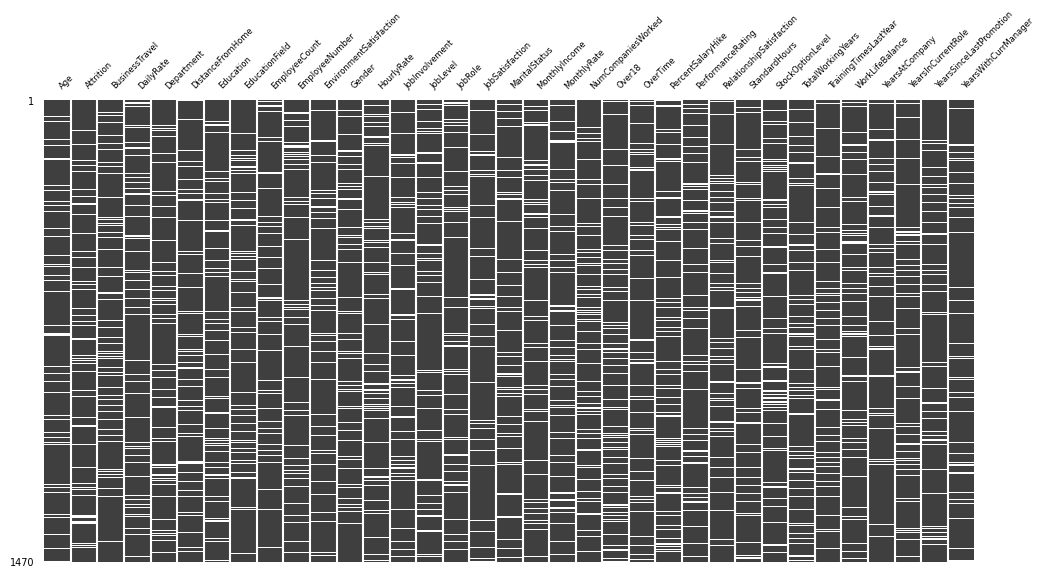

In [20]:
msno.matrix(df, sparkline=False, figsize=(12,6), fontsize=6)

In [21]:
# rows with no missing data
_ = df.dropna()
_.shape

(40, 35)

### 3.2. Application of Data preparation/evaluation methods (Cleaning, renaming, etc) and EDA (Exploratory Data Analysis) visualizations (plural), including a clear and concise explanation of your rationale for what you are doing with the data and why you are doing it.

In [22]:
# features are investigated here
print("Numerical: {}".format(len(df.select_dtypes(include='number').columns)-2))
print("Categories: {}".format(len(df.select_dtypes(include='object').columns)))

Numerical: 24
Categories: 9


In [23]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

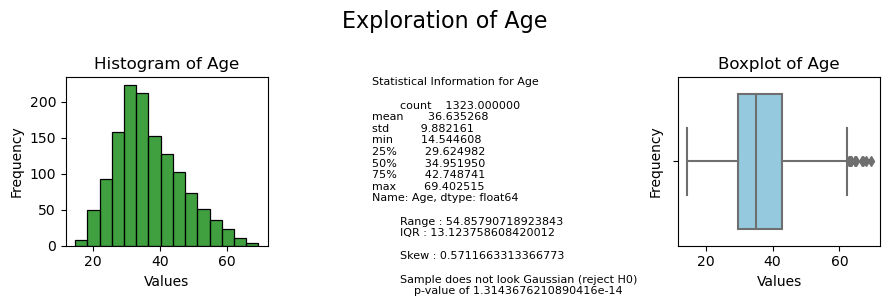

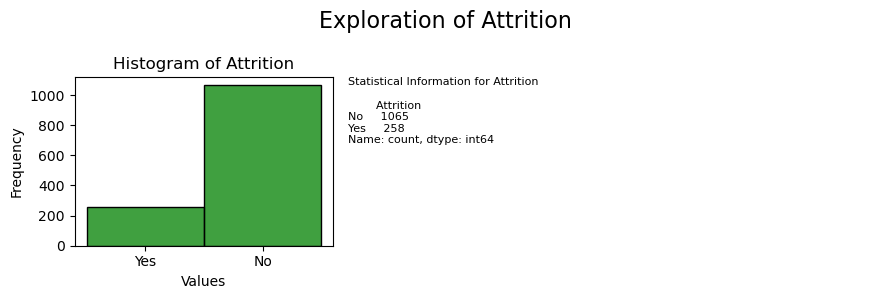

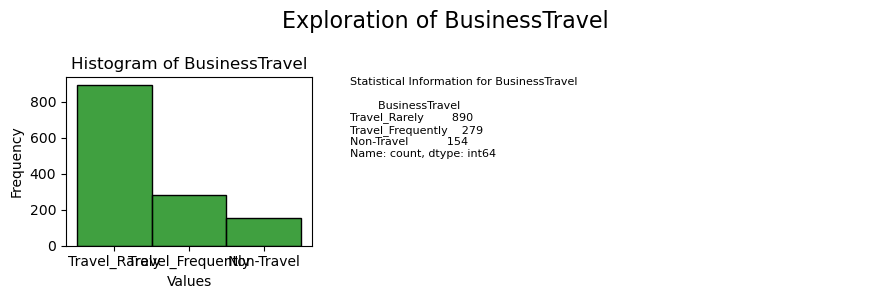

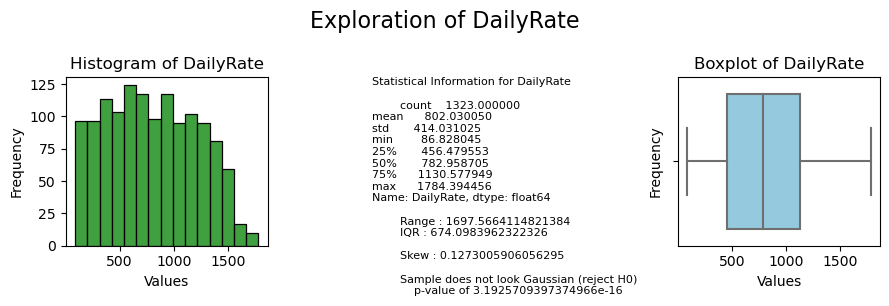

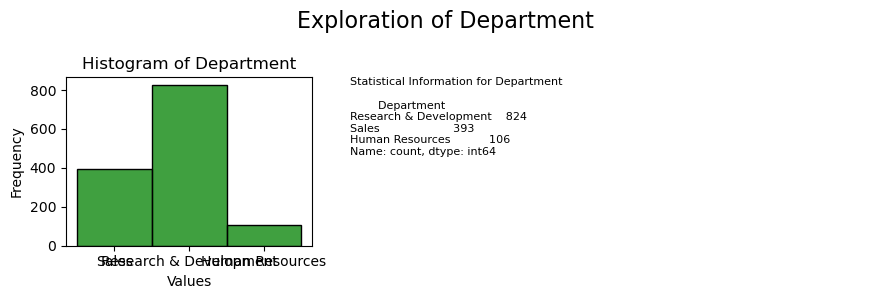

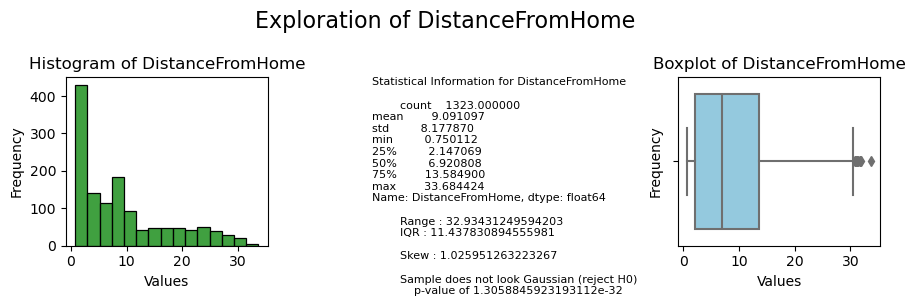

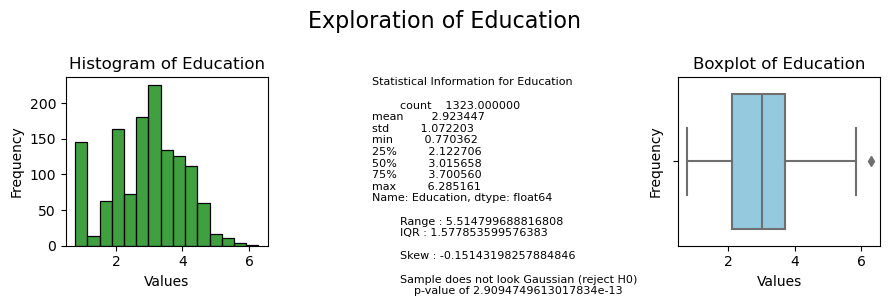

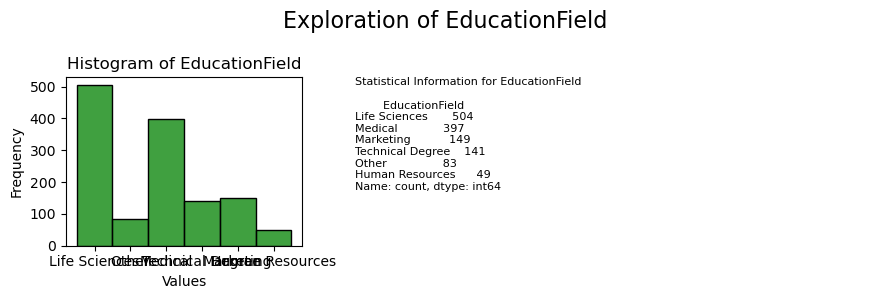

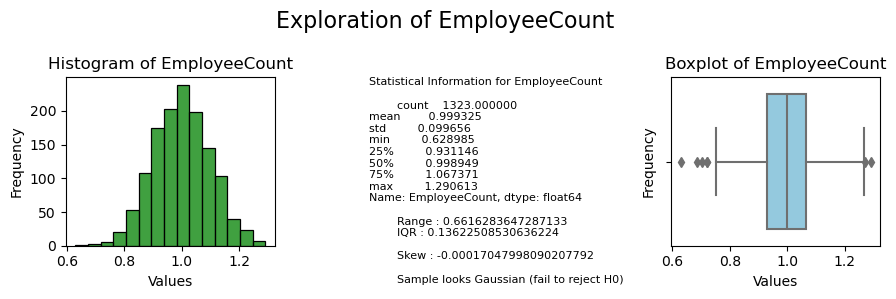

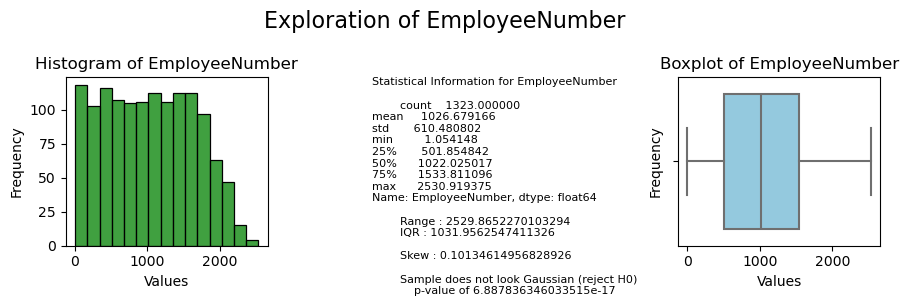

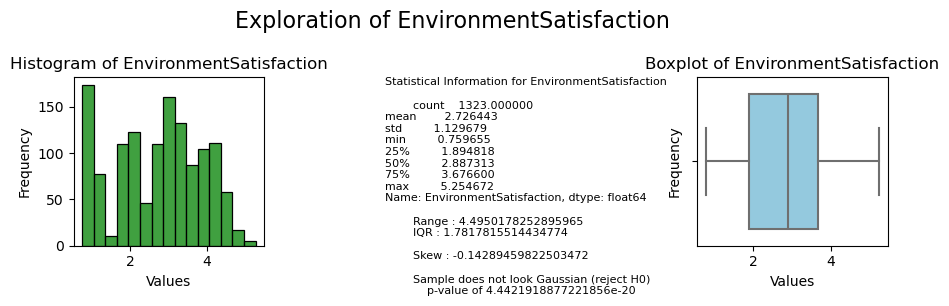

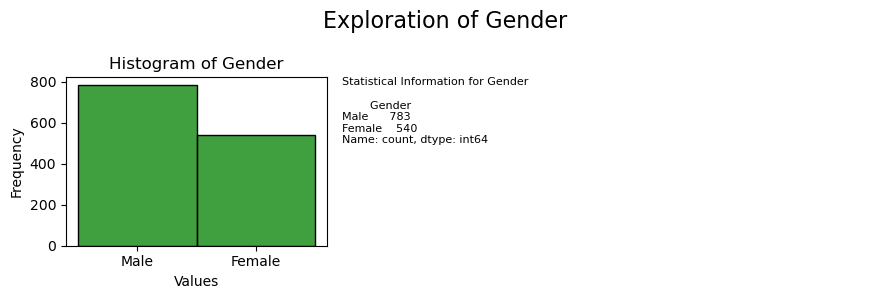

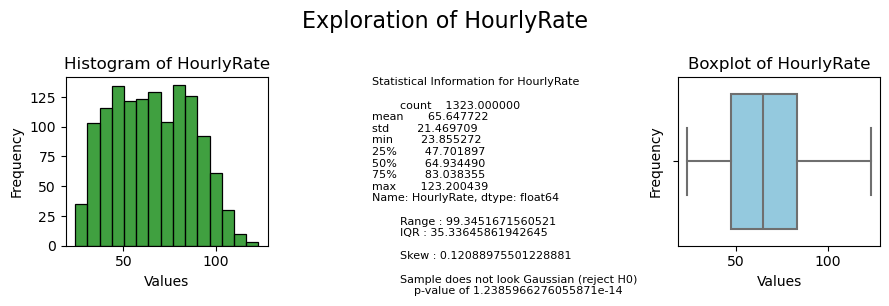

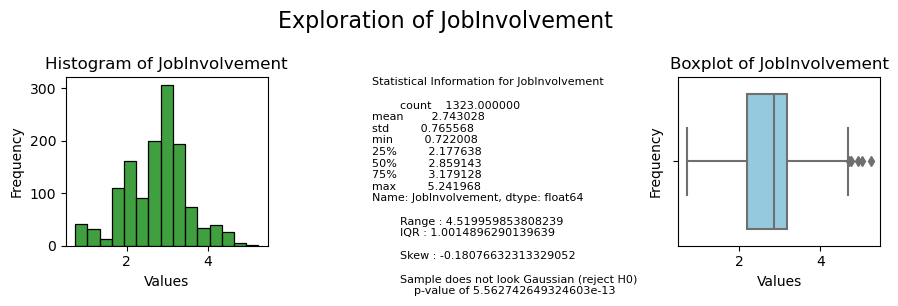

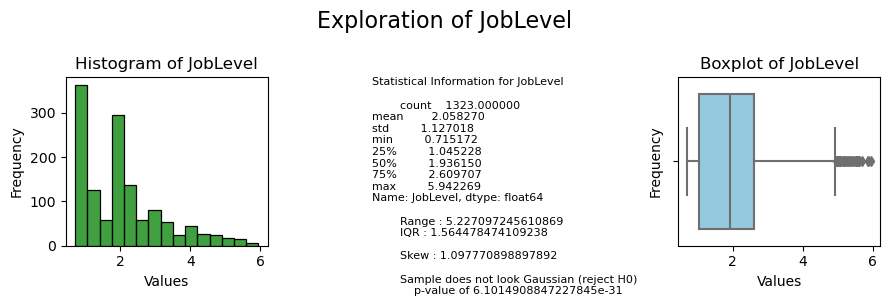

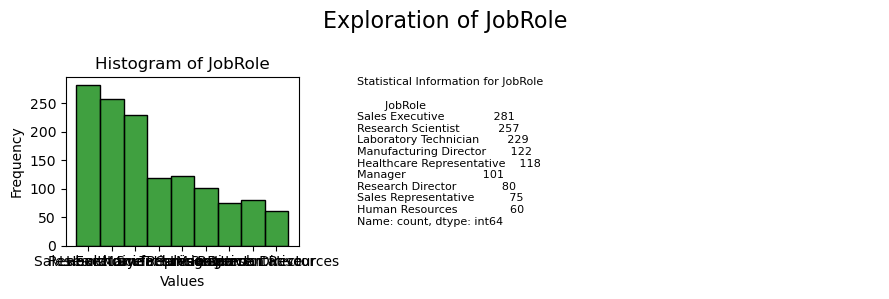

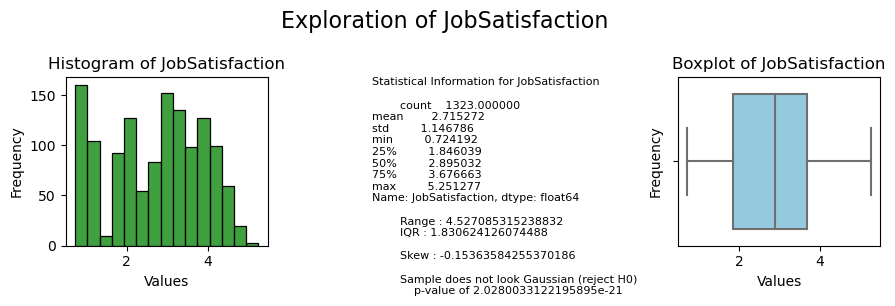

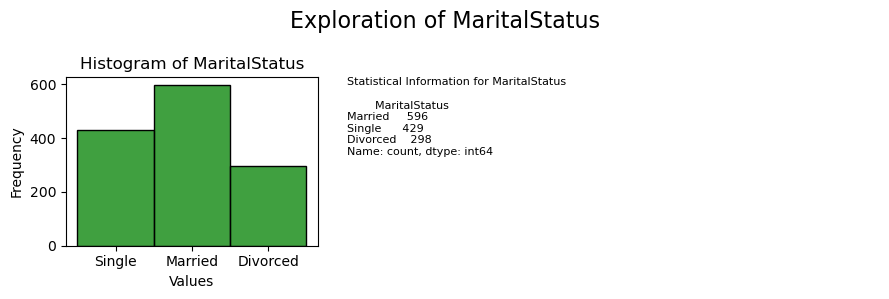

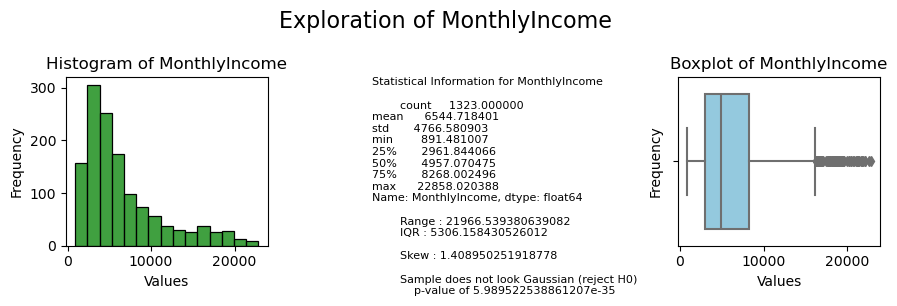

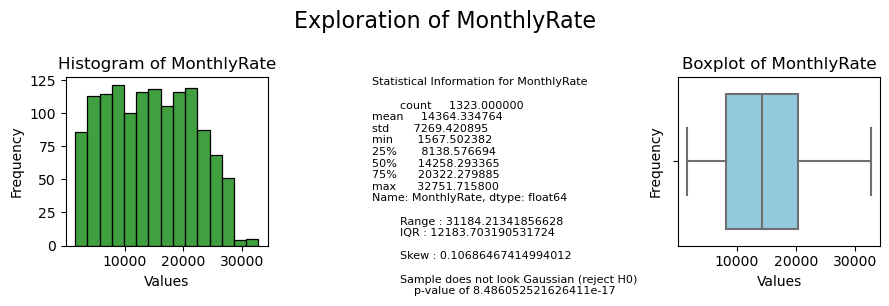

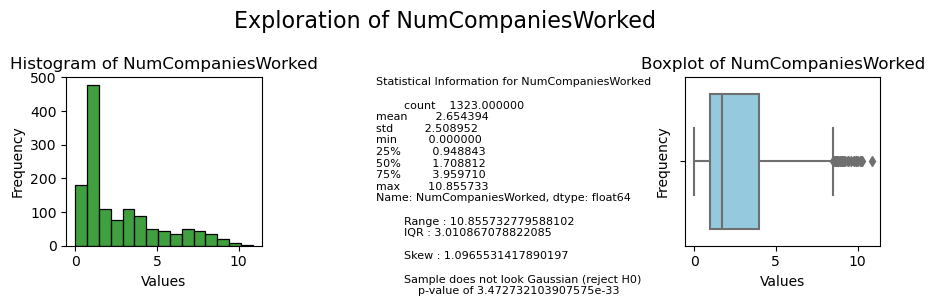

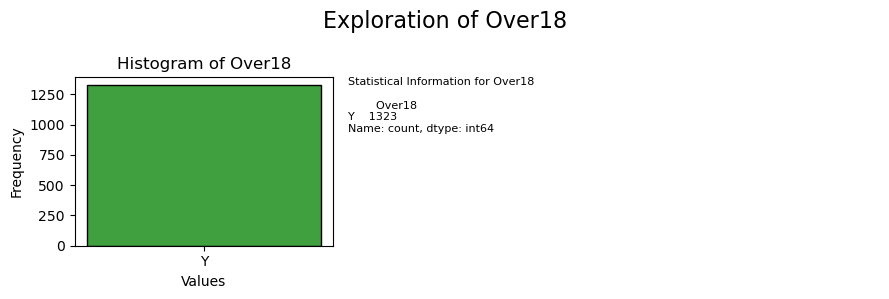

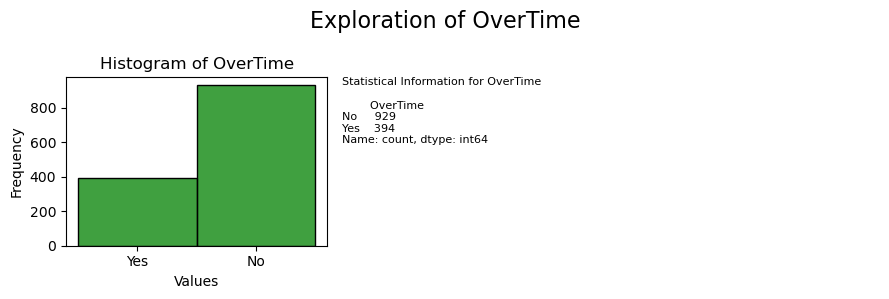

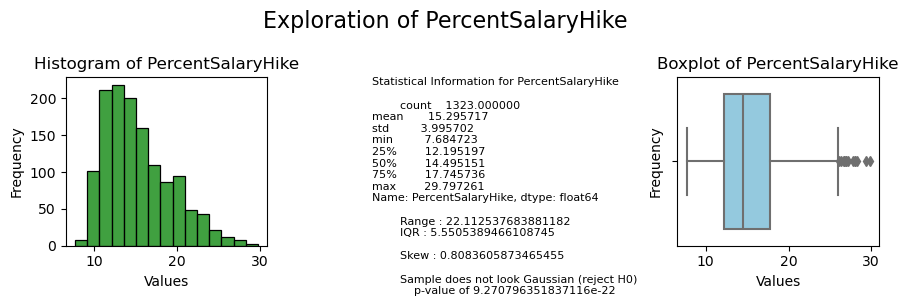

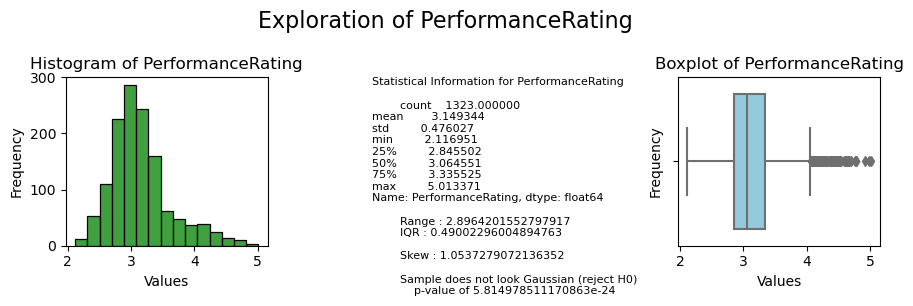

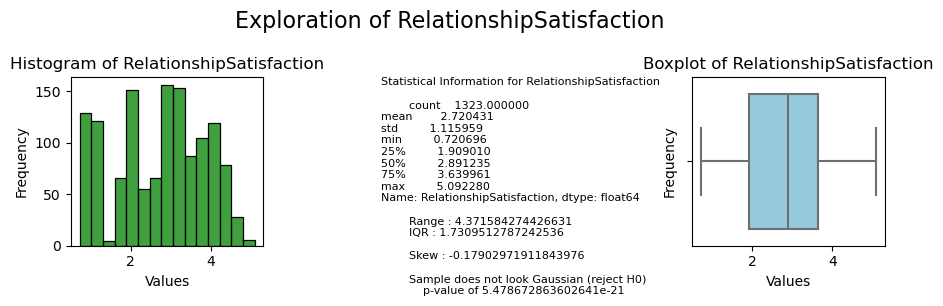

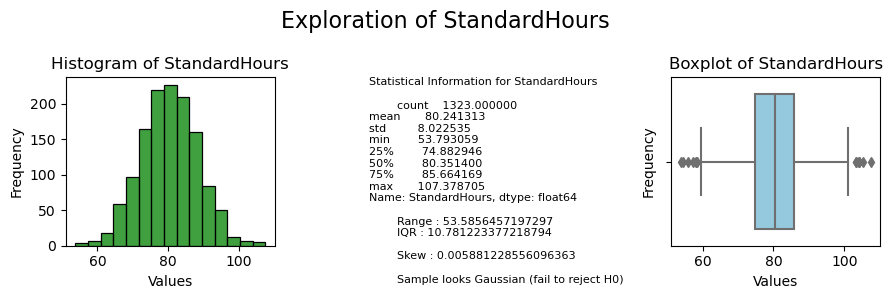

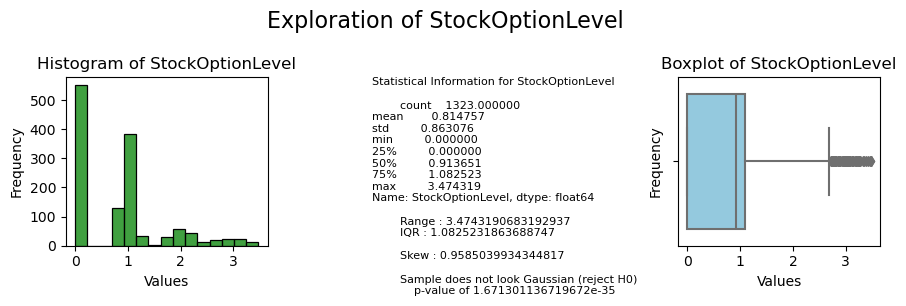

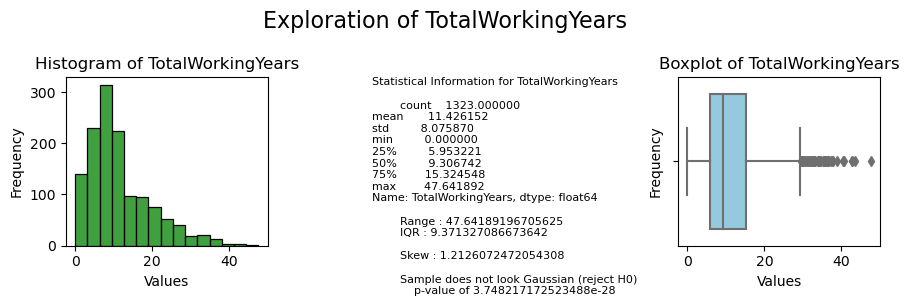

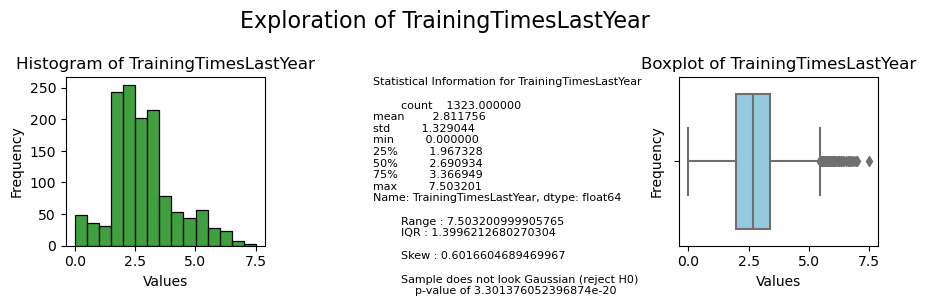

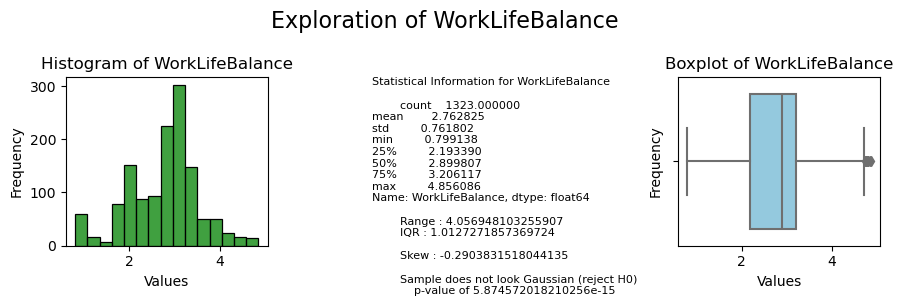

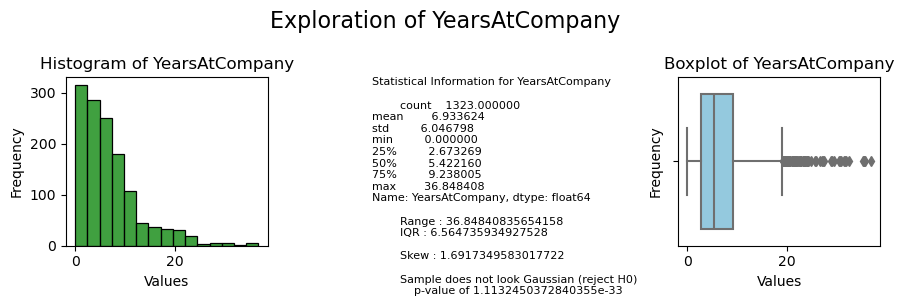

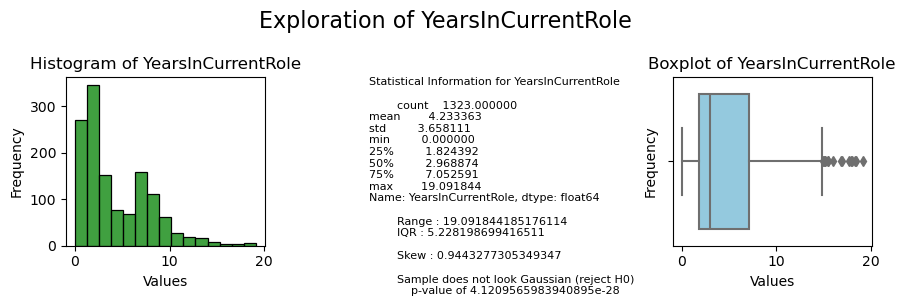

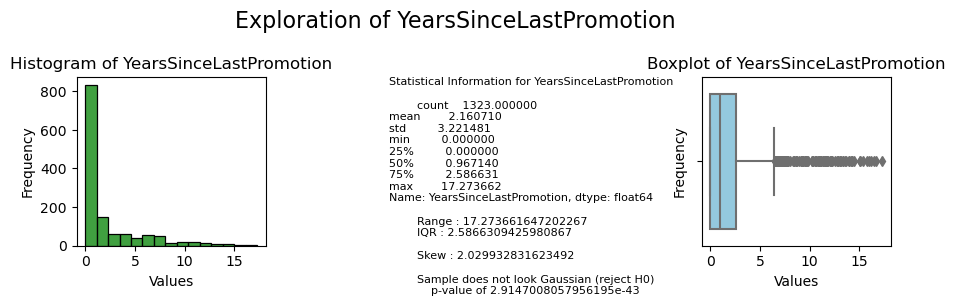

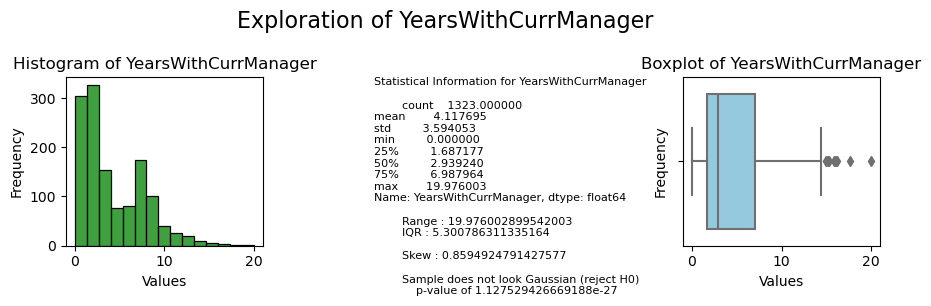

In [24]:
### this loop prints out all the graphs for each individual feature
### they are all discussed in detail below so the loop is commented out
### otherwise it gets messy with graphs and repeated information
### this was technically the data exploration of all the features before data prep but it is sort of presented together

# loop through each feature
for i in df.columns:
    numerical_explore(df, i)

#### Correlations

In [25]:
correlation_matrix = df.select_dtypes(include=['number'])
correlation_matrix.corr().shape

(26, 26)

In [26]:
# looking through the numbers is unintuitive
correlation_matrix.corr()

Age  DailyRate  DistanceFromHome  Education  \
Age                       1.000000   0.003115         -0.004483   0.218413   
DailyRate                 0.003115   1.000000         -0.004227  -0.012328   
DistanceFromHome         -0.004483  -0.004227          1.000000   0.012109   
Education                 0.218413  -0.012328          0.012109   1.000000   
EmployeeCount            -0.012545   0.009567          0.005865  -0.037297   
EmployeeNumber           -0.003796  -0.050564          0.035067   0.035267   
EnvironmentSatisfaction  -0.011972   0.019894         -0.030355   0.007502   
HourlyRate                0.027241   0.031691          0.026033   0.003187   
JobInvolvement            0.023650   0.051141         -0.005980   0.033630   
JobLevel                  0.467031  -0.013380          0.023336   0.106218   
JobSatisfaction          -0.007174   0.033046          0.021730   0.004137   
MonthlyIncome             0.452439   0.014500         -0.002639   0.093430   
MonthlyRate               0.029848  -0.051747          0.020612  -0.020113   
NumCompaniesWorked        0.283793   0.074620         -0.010111   0.121458   
PercentSalaryHike         0.005143   0.012519          0.051720  -0.021449   
PerformanceRating         0.013791   0.001198         -0.009788  -0.031509   
RelationshipSatisfaction  0.025094   0.019652          0.024771  -0.019207   
StandardHours             0.002155  -0.040108         -0.002562   0.010267   
StockOptionLevel          0.042739   0.007044          0.039794   0.008528   
TotalWorkingYears         0.625620   0.013766          0.004308   0.147655   
TrainingTimesLastYear    -0.021116  -0.009000         -0.047087  -0.034722   
WorkLifeBalance          -0.035865  -0.035260         -0.017814  -0.004356   
YearsAtCompany            0.273534  -0.038210          0.023940   0.075283   
YearsInCurrentRole        0.179098   0.007122          0.020311   0.072572   
YearsSinceLastPromotion   0.183958  -0.022840         -0.005743   0.050648   
YearsWithCurrManager      0.183590  -0.039930          0.033454   0.065608   

                          EmployeeCount  EmployeeNumber  \
Age                           -0.012545       -0.003796   
DailyRate                      0.009567       -0.050564   
DistanceFromHome               0.005865        0.035067   
Education                     -0.037297        0.035267   
EmployeeCount                  1.000000        0.063013   
EmployeeNumber                 0.063013        1.000000   
EnvironmentSatisfaction        0.026024        0.040412   
HourlyRate                     0.056652        0.003557   
JobInvolvement                -0.039578       -0.016547   
JobLevel                       0.004059       -0.004218   
JobSatisfaction                0.011087       -0.032971   
MonthlyIncome                 -0.004826       -0.014102   
MonthlyRate                   -0.035191        0.026890   
NumCompaniesWorked             0.011113       -0.030975   
PercentSalaryHike             -0.022989       -0.020035   
PerformanceRating             -0.012866       -0.021386   
RelationshipSatisfaction       0.015579       -0.072664   
StandardHours                 -0.003399        0.000358   
StockOptionLevel              -0.038158        0.063318   
TotalWorkingYears              0.002776       -0.019994   
TrainingTimesLastYear         -0.054455       -0.006759   
WorkLifeBalance               -0.004015        0.020873   
YearsAtCompany                 0.018562       -0.002520   
YearsInCurrentRole             0.016204       -0.017335   
YearsSinceLastPromotion       -0.004410       -0.008418   
YearsWithCurrManager          -0.033018       -0.020842   

                          EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
Age                                     -0.011972    0.027241        0.023650   
DailyRate                                0.019894    0.031691        0.051141   
DistanceFromHome                        -0.030355    0.026033       -0.005980   
Educat

correlation shape: (26, 26)


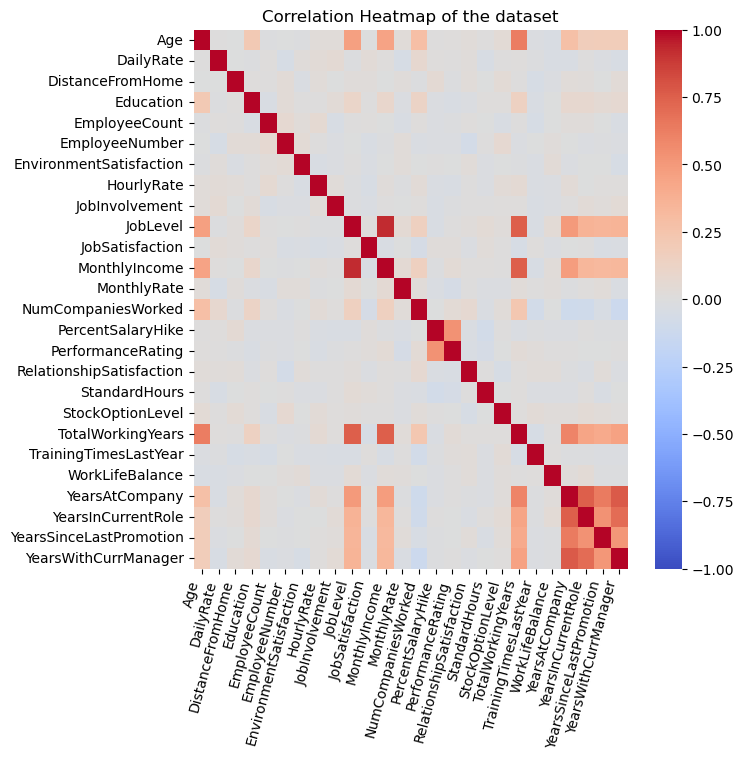

In [27]:
# correlation is easier to view in a larger number of features like this
# correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()
print(f"correlation shape: {correlation_matrix.shape}")

# correlation heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.xticks(rotation=75, ha='right')
plt.title('Correlation Heatmap of the dataset')
plt.show()

In [28]:
# from above, monthly income and job level are highly correlated
df.MonthlyIncome.corr(df.JobLevel)

0.9235098140677838

In [29]:
# total working years is correlated with some features too
print("Correlations of TotalWorkingYears")
print("vs. JobLevel: ", df.TotalWorkingYears.corr(df.JobLevel))
print("vs. MonthlyIncome: ", df.TotalWorkingYears.corr(df.MonthlyIncome))
print("vs. YearsAtCompany: ", df.TotalWorkingYears.corr(df.YearsAtCompany))

Correlations of TotalWorkingYears
vs. JobLevel:  0.7568136270833515
vs. MonthlyIncome:  0.757637022403104
vs. YearsAtCompany:  0.593883740319838


In [30]:
# the last 4 columns are correlated together
# they are all related to years working
df.iloc[:,-4:].corr()

YearsAtCompany  YearsInCurrentRole  \
YearsAtCompany                 1.000000            0.753423   
YearsInCurrentRole             0.753423            1.000000   
YearsSinceLastPromotion        0.639672            0.532027   
YearsWithCurrManager           0.767222            0.702790   

                         YearsSinceLastPromotion  YearsWithCurrManager  
YearsAtCompany                          0.639672              0.767222  
YearsInCurrentRole                      0.532027              0.702790  
YearsSinceLastPromotion                 1.000000              0.509521  
YearsWithCurrManager                    0.509521              1.000000

In [31]:
# maybe run this at end or delete it
# it doesn't show any more information than the correlation heatmap does
#sns.pairplot(df.select_dtypes(include=['number']))

<Axes: xlabel='BusinessTravel', ylabel='count'>

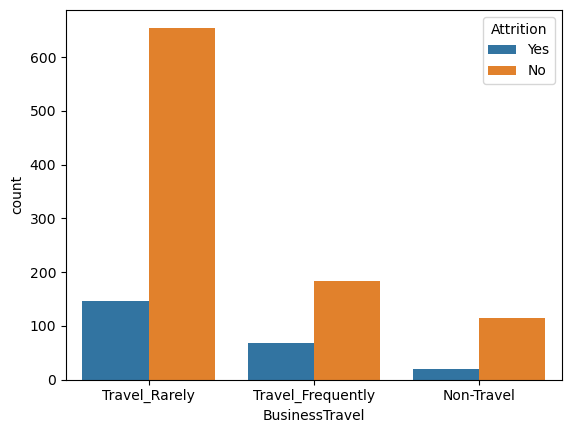

In [32]:
sns.countplot(x='BusinessTravel', data=df, hue= "Attrition")

In [33]:
df.Attrition.value_counts()

Attrition
No     1065
Yes     258
Name: count, dtype: int64

### Data Preparation

In [34]:
# Now that data exploration has been employed and baseline models have been created data preparation will be done

#### Age

In [35]:
df.head()

Age Attrition     BusinessTravel    DailyRate  \
0  41.920786       Yes      Travel_Rarely   990.110009   
1  51.589037        No  Travel_Frequently   276.776030   
2  33.131540       Yes      Travel_Rarely  1204.158501   
3  34.707073        No  Travel_Frequently  1352.752432   
4  24.790188        No      Travel_Rarely   485.053333   

               Department  DistanceFromHome  Education EducationField  \
0                   Sales          1.016716   1.770313  Life Sciences   
1  Research & Development               NaN   1.035333  Life Sciences   
2  Research & Development          2.198662   2.118801          Other   
3                   Sales          2.937851   3.670674  Life Sciences   
4  Research & Development          1.988953   1.120496        Medical   

   EmployeeCount  EmployeeNumber  ...  RelationshipSatisfaction StandardHours  \
0       1.033298        1.054148  ...                  1.012832     95.612654   
1       0.944859        2.107031  ...                  4.312008     85.370868   
2       0.810809        4.008125  ...                  2.332558     76.248084   
3       0.822976        4.587269  ...                  3.029591     75.888697   
4            NaN        7.228740  ...                       NaN     72.670937   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  \
0          0.000000           8.063833               0.000000        1.052104   
1          1.104642           8.965059               3.264952        2.526470   
2          0.000000           8.427238               3.004521        2.924784   
3          0.000000           7.662606               2.856001        3.117053   
4          0.953012           6.241733               2.814719        3.112317   

   YearsAtCompany YearsInCurrentRole  YearsSinceLastPromotion  \
0        5.795945           3.993896                 0.000000   
1       10.070232           7.937505                 1.032295   
2        0.000000           0.000000                 0.000000   
3        8.435324           5.563667                 2.845429   
4        2.040124           1.970786                 2.495949   

   YearsWithCurrManager  
0              4.594972  
1              5.901207  
2              0.000000  
3              0.000000  
4              2.219353  

[5 rows x 35 columns]

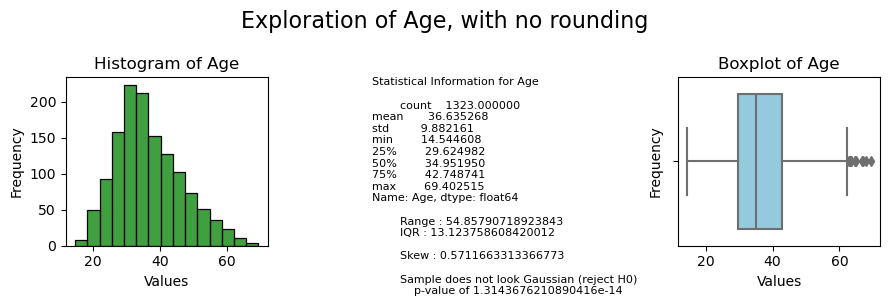

In [36]:
numerical_explore(df, "Age", title="with no rounding")

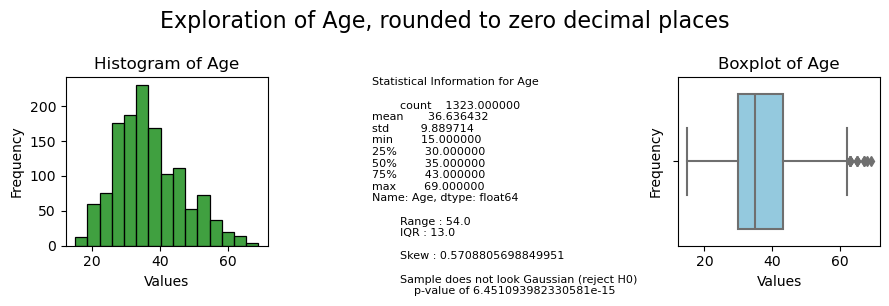

In [37]:
## Rounding age to 0 decimal places changes the shape of the original data,
## while it's not ideal to deal with 
df1=df.copy()
df1["Age"] = df.Age.round(0)
numerical_explore(df1, "Age", title="rounded to zero decimal places")

In [38]:
## round age to 1 decimal place keeps the data shape with less disruption to the skew
df1.Age = df.Age.round(1)

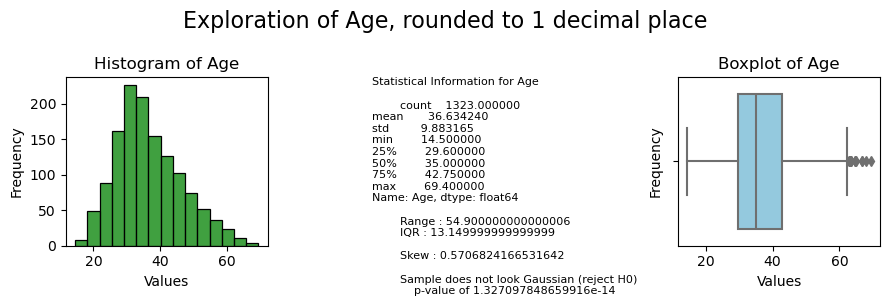

In [39]:
numerical_explore(df1, "Age", title="rounded to 1 decimal place")

In [40]:
# it seems unusual to use decimal places in age it has some functions:
# 1. keeps the signal in the data: the data differentiated between different 16s etc. (this may not be useful)
# 2. keeps the shape of the data
df1.Age

0       41.9
1       51.6
2       33.1
3       34.7
4       24.8
        ... 
1465    37.4
1466    35.0
1467    26.9
1468     NaN
1469    38.1
Name: Age, Length: 1470, dtype: float64

#### Age vs Over 18

In [41]:
# Over18 is if the employee is over 18, it only features yes values
# while some of the ages are as low as 16
# it makes this column unusable in two ways, first it is a constant value, second it is wrong information
df["Over18"].value_counts()

Over18
Y    1323
Name: count, dtype: int64

In [42]:
df1 = df[df["Age"] < 18]
df1[["Age", "Over18"]].head(50)

Age Over18
206   16.057972    NaN
498   16.792547      Y
828   16.741273      Y
853   16.789596      Y
972   14.544608      Y
1153  16.840129      Y
1197  17.109549      Y

In [43]:
# It leads to some questions either Age or Over18 is encoded wrongly
# Several trains of thought are available:
# 1. drop Over18: remove it as it provides no signal as is
# 2. reencode Over18: fix the feature.. but as only 7 values will be N it will be so unbalanced to be unusable
# 3. drop the ages below 18: the data seemed to consider them all 18, so remove the conflicting data
# 4. replace the ages below 18 with 18: setting the low ages to the new lower limit of the data might be viable as they aren't outliers
print(f"Number of ages lower than 18: {len(df1)}")

Number of ages lower than 18: 7


#### Age vs Year variables

In [44]:
df.head()

Age Attrition     BusinessTravel    DailyRate  \
0  41.920786       Yes      Travel_Rarely   990.110009   
1  51.589037        No  Travel_Frequently   276.776030   
2  33.131540       Yes      Travel_Rarely  1204.158501   
3  34.707073        No  Travel_Frequently  1352.752432   
4  24.790188        No      Travel_Rarely   485.053333   

               Department  DistanceFromHome  Education EducationField  \
0                   Sales          1.016716   1.770313  Life Sciences   
1  Research & Development               NaN   1.035333  Life Sciences   
2  Research & Development          2.198662   2.118801          Other   
3                   Sales          2.937851   3.670674  Life Sciences   
4  Research & Development          1.988953   1.120496        Medical   

   EmployeeCount  EmployeeNumber  ...  RelationshipSatisfaction StandardHours  \
0       1.033298        1.054148  ...                  1.012832     95.612654   
1       0.944859        2.107031  ...                  4.312008     85.370868   
2       0.810809        4.008125  ...                  2.332558     76.248084   
3       0.822976        4.587269  ...                  3.029591     75.888697   
4            NaN        7.228740  ...                       NaN     72.670937   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  \
0          0.000000           8.063833               0.000000        1.052104   
1          1.104642           8.965059               3.264952        2.526470   
2          0.000000           8.427238               3.004521        2.924784   
3          0.000000           7.662606               2.856001        3.117053   
4          0.953012           6.241733               2.814719        3.112317   

   YearsAtCompany YearsInCurrentRole  YearsSinceLastPromotion  \
0        5.795945           3.993896                 0.000000   
1       10.070232           7.937505                 1.032295   
2        0.000000           0.000000                 0.000000   
3        8.435324           5.563667                 2.845429   
4        2.040124           1.970786                 2.495949   

   YearsWithCurrManager  
0              4.594972  
1              5.901207  
2              0.000000  
3              0.000000  
4              2.219353  

[5 rows x 35 columns]

In [45]:
df.JobRole.unique()

array(['Sales Executive', 'Research Scientist', 'Laboratory Technician',
       nan, 'Healthcare Representative', 'Manufacturing Director',
       'Manager', 'Sales Representative', 'Research Director',
       'Human Resources'], dtype=object)

In [46]:
# to help make the decision more exploration is needed
# looking at age with the year variables reveals the data needs even further clearning
# for reference: the years variables are all continuous and not one of the ranking variable candidates

# employess have worked at the company at ages that may not align with the company job roles provided


# selecting age 
_ = df.iloc[:, 0]
# selecting year features
df1 = df.iloc[:, -4:]
df1 = pd.concat([_, df1], axis=1)

# selecting total working years
_ = df["TotalWorkingYears"]
df1 = pd.concat([df1, _], axis=1)

# sort by age ascending
df1 = df1.sort_values(by="Age")
df1.head(10)

Age  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
972   14.544608        0.000000            0.000000                 0.000000   
206   16.057972        3.551193            2.008697                      NaN   
828   16.741273        0.000000            0.000000                 0.000000   
853   16.789596        1.104673            1.060756                 0.000000   
498   16.792547        2.236441                 NaN                 2.069399   
1153  16.840129        0.000000            0.000000                 0.000000   
1197  17.109549        1.763690            2.107599                 0.000000   
149   18.067474        0.896289            0.000000                 0.000000   
177   18.269878        0.993286            0.000000                 1.058821   
727   18.292187        0.000000                 NaN                 0.000000   

      YearsWithCurrManager  TotalWorkingYears  
972               0.000000           0.000000  
206               2.360856           4.308867  
828               0.000000           0.000000  
853               0.000000           0.960555  
498               2.338651           2.950239  
1153                   NaN           0.000000  
1197              1.684820           2.227287  
149               0.000000           1.037603  
177               0.000000           1.208996  
727               0.000000           0.000000

In [47]:
# looking at the employee that has worked at the company since 12 and a half years old
# he is 16 and works in the human resources department as a reseach scientist and divorced....
# his education is null.. no doubt it's off the chart T_t
# it seems the data isn't just sparse but quite dirty
df.iloc[206]

Age                                  16.057972
Attrition                                   No
BusinessTravel                   Travel_Rarely
DailyRate                          1064.715525
Department                     Human Resources
DistanceFromHome                      3.803029
Education                                  NaN
EducationField                             NaN
EmployeeCount                         1.075091
EmployeeNumber                      289.315228
EnvironmentSatisfaction               3.990697
Gender                                    Male
HourlyRate                            65.18559
JobInvolvement                        4.135275
JobLevel                              1.060848
JobRole                     Research Scientist
JobSatisfaction                       2.070945
MaritalStatus                         Divorced
MonthlyIncome                      2335.718589
MonthlyRate                       12927.008434
NumCompaniesWorked                    0.985561
Over18       

#### Closer look at the year features

In [48]:
# wanted to look at these last..
# running some checks to make sure they at least make logical sense
# it may be that much of the data isn't usable

In [49]:
df1.describe()

Age  YearsAtCompany  YearsInCurrentRole  \
count  1323.000000     1323.000000         1323.000000   
mean     36.635268        6.933624            4.233363   
std       9.882161        6.046798            3.658111   
min      14.544608        0.000000            0.000000   
25%      29.624982        2.673269            1.824392   
50%      34.951950        5.422160            2.968874   
75%      42.748741        9.238005            7.052591   
max      69.402515       36.848408           19.091844   

       YearsSinceLastPromotion  YearsWithCurrManager  TotalWorkingYears  
count              1323.000000           1323.000000        1323.000000  
mean                  2.160710              4.117695          11.426152  
std                   3.221481              3.594053           8.075870  
min                   0.000000              0.000000           0.000000  
25%                   0.000000              1.687177           5.953221  
50%                   0.967140              2.939240           9.306742  
75%                   2.586631              6.987964          15.324548  
max                  17.273662             19.976003          47.641892

In [50]:
# performing this one test reveals these features are all quite dirty..
# just this view alone shows YearsInCurrentRole and YearsWithCurrManager greater than TotalWorkingYears...
# ... YearsSinceLastPromotion should be conflicting with YearsInCurrentRole and TotalWorkingYears in the first row...

# Is years with current manager greater than total working years for any cases?
# this is something that could make modelling difficult..
# the year variables seem to be approximating ranges that would be expected so the decimals can't really be understood as a scaling
df1 = df[df["TotalWorkingYears"] < df["YearsWithCurrManager"]]
df1.iloc[:, -7:].head()

TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  \
5             6.694851               1.871592         2.046544   
37            1.706644               3.041704         2.614786   
51            2.025175               3.330482              NaN   
143           3.990013               3.992088         1.779493   
164           0.887973               2.232780         2.222138   

     YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
5          6.092499            8.389254                 3.131537   
37         1.898107            2.100594                      NaN   
51         1.899158            1.957240                      NaN   
143             NaN            3.410918                 0.000000   
164        0.986038            1.162819                 0.000000   

     YearsWithCurrManager  
5                7.060896  
37               1.969773  
51               2.068893  
143              4.166408  
164              1.068507

#### Investigating Noise with feature engineering

In [51]:
# seems a different technique was applied to the dataset for random noise.. which was kind of suspected
# if more views are done as above it'll probably yield more of the same out of sync years
# the data could be rounded and the noise may be removed but the characteristic of the noise lost

In [52]:
# years at company can be off by upto 7 years (both features with noise in opposite direction likely here)
# 

# can only see the noise here that does not make logical sense
# more noise likely exists, first in the opposite direction and this isn't a strict science

# 214 entries have YearsAtCompany greater than TotalWorkingYears
# rounding the 
df1["Y1"] = df1["TotalWorkingYears"] - df1["YearsAtCompany"]
below_zero_values = df1[df1["Y1"] < 0]["Y1"]
print(len(below_zero_values))
below_zero_values.describe()

16


count    16.000000
mean     -0.353464
std       0.285252
min      -0.952496
25%      -0.638561
50%      -0.202356
75%      -0.138952
max      -0.042265
Name: Y1, dtype: float64

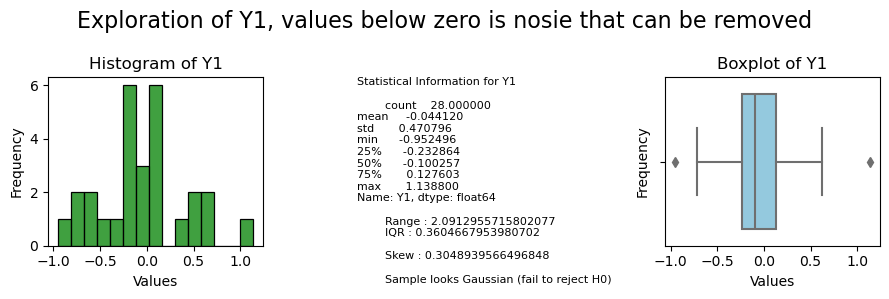

In [53]:
numerical_explore(df1, "Y1", title="values below zero is nosie that can be removed")

In [54]:
# these aren't as out of sync as YearsAtCompany...
# ... more than likely because the range of YearsInCurrentRole is lower...
# ...so the out of sync years is revealed less often
df1["Y1"] = df1["TotalWorkingYears"] - df1["YearsInCurrentRole"]
below_zero_values = df1[df1["Y1"] < 0]["Y1"]
print(len(below_zero_values))
below_zero_values.describe()

11


count    11.000000
mean     -0.819315
std       0.774495
min      -2.580717
25%      -1.108852
50%      -0.447141
75%      -0.324832
max      -0.129331
Name: Y1, dtype: float64

In [55]:
# so what can be done with years variables
# 1. lengthened where makes logical sense
# 2. shortened where makes logical sense
# 3. binned in categories

# although one question should be asked:
# generally a high number will be still a high number, and a low number still low...
# ...and while the data is less truthful or logical is it less useable for modelling?

# looking again at entry 206, if the years variables were cleaned with python the employee...
# ...would be now an 18 year old (set to 18) Human Resources, Research Scientist that worked with the company...
# ... for 4 years (rounded up), 4 total working years (rounded down), in current role for 2 years, with current manager for 2 years...
# ... while the work years aren't badly out of sync here there are still some questions raised when they are rounded.

# back to the question... will any of this effect modelling, if low number is still low etc, and the data will be scaled anyway

# my main issue with it is the level of precision, it is first a level of precision that shouldn't have been (or wasn't) recorded
# and rounding leaves the data with logical questions, it makes binning the values an attractive option

# binning shouldn't be a loss of signal and may circumvent the issue with noise a bit
# it's likely that the target features need coverted to ordinal categories so again back to precision:
# modelling with binned categories should yield the same post modelling evaluation that certain features
# impact negatively or positively (or don't) the target features.

In [56]:
df.iloc[206]

Age                                  16.057972
Attrition                                   No
BusinessTravel                   Travel_Rarely
DailyRate                          1064.715525
Department                     Human Resources
DistanceFromHome                      3.803029
Education                                  NaN
EducationField                             NaN
EmployeeCount                         1.075091
EmployeeNumber                      289.315228
EnvironmentSatisfaction               3.990697
Gender                                    Male
HourlyRate                            65.18559
JobInvolvement                        4.135275
JobLevel                              1.060848
JobRole                     Research Scientist
JobSatisfaction                       2.070945
MaritalStatus                         Divorced
MonthlyIncome                      2335.718589
MonthlyRate                       12927.008434
NumCompaniesWorked                    0.985561
Over18       

#### Back to Age

In [57]:
df1 = df.copy()  
df1.loc[df1["Age"] < 18, "Age"] = 18

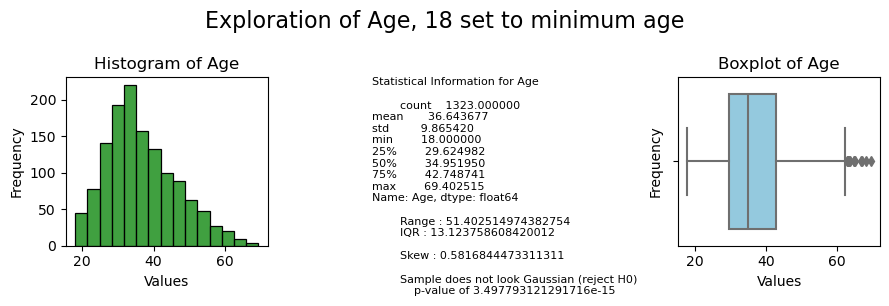

In [58]:
numerical_explore(df1, "Age", title="18 set to minimum age")

In [59]:
# Age looks log normal but when log transformation is applied it does look more normal...
# ...but rejects the null hypothesis for testing if it was a sample from a normal population
# age wouldn't be expected to be log normal.. normality would be expected for natural biological attributes...
# ... but it was a quick trial to perform as it looked like it could have been
# 
_ = df1.copy()
_['Age'] = np.log(_['Age'])

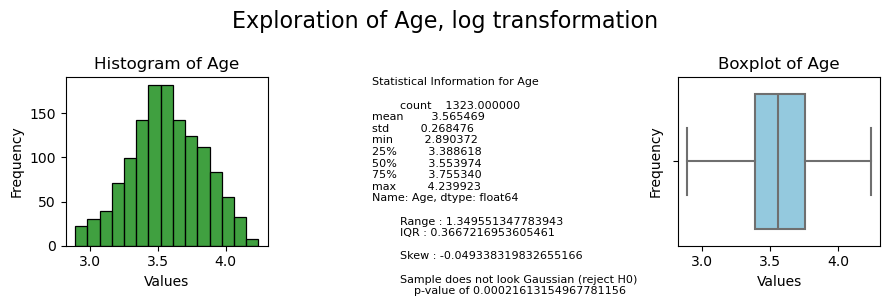

In [60]:
numerical_explore(_, "Age", title="log transformation")

In [61]:
# standardisation and min-max scaling do keep the shape of course
scaler = MinMaxScaler()
_ = df1.copy()
_['Age'] = scaler.fit_transform(_['Age'].values.reshape(-1, 1))

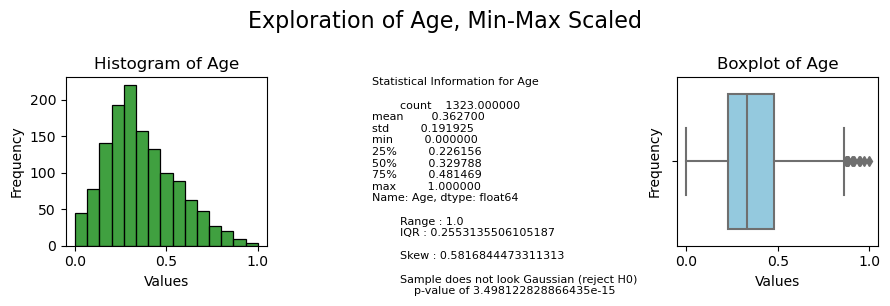

In [62]:
numerical_explore(_, "Age", title="Min-Max Scaled")

In [63]:
scaler = StandardScaler()
_ = df1.copy()
_['Age'] = scaler.fit_transform(_['Age'].values.reshape(-1, 1))

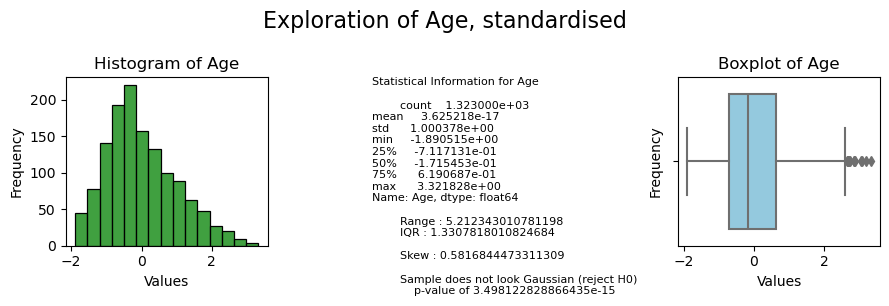

In [64]:
numerical_explore(_, "Age", title="standardised")

In [65]:
# Age isn't normal distributed as it isn't ages selected from the population of people
# it is ages sampled from employees of this company which attracts mainly 30-43 year olds, ie only working age people

# it's an assumption that the population of peoples ages is normally distributed.
# considering that it may be, the selection of employees is akin to a bad sampling technique of the total population of people
# and gives a biased sample that isn't representive of the population as a whole

# given that it looks close to normal, and the assumptions above, it's fair to assume that the ages represent close to the real age
# of the employees possibly with noise added again, while the Over18 feature hinted that some ages may be recorded wrong, or the data
# is dirty, there aren't a selection of features that can be used to examine just how much noise exists in the feature, like was approximated with year features

# repeating the question from earlier:
# Several trains of thought are available:
# 1. drop Over18: remove it as it provides no signal as is
# 2. reencode Over18: fix the feature.. but as only 7 values will be N it will be so unbalanced to be unusable
# 3. drop the ages below 18: the data seemed to consider them all 18, so remove the conflicting data
# 4. replace the ages below 18 with 18: setting the low ages to the new lower limit of the data might be viable as they aren't outliers

# now that years have been examined and the data further illuminated makes the decision easier.
# the following decisions on age will be made:
# 1. Over18 should be dropped; it provides no signal as it is a static variable

# 2. Ages below 18 should be set to 18, only 7 values are below 18 and while it's likely 
# an employee below 18 exists it would be a negligable outlier and not interesting to modelling at this level

# 3. Age should be rounded to one decimal place, to remove some of the not needed 'precision' but keep the majority of the noise
# while it could be rounded to no decimal places and make the feature seem more 'right'... it would be doubling down on adding noise to the data
# think trying to encode a digital file into a higher format using a low quality copy 

#### Drop Over18

In [66]:
# Over18 isn't usable, it is one value each non null entry
df = df.drop(["Over18"], axis=1)
df.shape

(1470, 34)

#### Formating Age and Year Features

In [67]:
# format them now as years aren't usable for anova
### TODO ###
# format age
# visualise different categories with age
# test different categories with age
# do more features
# remember! no features showed linear relationship with target features

In [68]:
df1 = df.copy()
df1.shape # only missing Over18 so far

(1470, 34)

In [69]:
# formatting age
df["Age"] = df["Age"].round(1)
df.loc[df["Age"] < 18, "Age"] = 18
df.Age.min()

18.0

In [70]:
# formatting year features
year_features = ["TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole",
           "YearsSinceLastPromotion", "YearsWithCurrManager"]


In [71]:
# making test dataframe 
year_features.insert(0, "Age")
year_features.append("PerformanceRating")
year_features.append("JobSatisfaction")
df1 = df1[year_features]
df1.head()

Age  TotalWorkingYears  YearsAtCompany  YearsInCurrentRole  \
0  41.920786           8.063833        5.795945            3.993896   
1  51.589037           8.965059       10.070232            7.937505   
2  33.131540           8.427238        0.000000            0.000000   
3  34.707073           7.662606        8.435324            5.563667   
4  24.790188           6.241733        2.040124            1.970786   

   YearsSinceLastPromotion  YearsWithCurrManager  PerformanceRating  \
0                 0.000000              4.594972           2.844897   
1                 1.032295              5.901207           4.120281   
2                 0.000000              0.000000           2.781168   
3                 2.845429              0.000000           2.769576   
4                 2.495949              2.219353           3.282183   

   JobSatisfaction  
0         3.397665  
1         1.584059  
2         3.301009  
3         3.220844  
4         1.697330

In [72]:
# before binning the year features it's important to remember they all have outliers
# for binning it may be adequte to do bins of 5 years until the outliers and do 20+ for the remaining
# for eg. the logic being that for TotalWorkingYears could be binned in 10 5 year bins, or every 5 years until
# 20 to cover the 75% percentile and the remaning outliers grouped together as 20+
# when we count the data points above 30 and 40 for this variable we get 49 and 6 respectively
# this is still a low amount of signal in this last bin comparitive to the size of the data

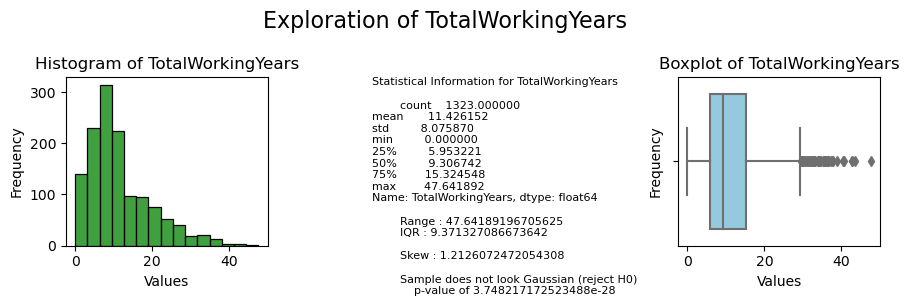

In [73]:
numerical_explore(df1, "TotalWorkingYears")

In [74]:
# Filter the DataFrame to get only rows where TotalWorkingYears is above 30
above_thirty_df = df[df['TotalWorkingYears'] > 30]

# rows
count_above_thirty = len(above_thirty_df)
count_above_thirty

49

In [75]:
# Filter the DataFrame to get only rows where TotalWorkingYears is above 30
above_thirty_df = df[df['TotalWorkingYears'] > 40]

# Count the number of rows in the filtered DataFrame
count_above_thirty = len(above_thirty_df)
count_above_thirty

6

In [76]:
df1.head()

Age  TotalWorkingYears  YearsAtCompany  YearsInCurrentRole  \
0  41.920786           8.063833        5.795945            3.993896   
1  51.589037           8.965059       10.070232            7.937505   
2  33.131540           8.427238        0.000000            0.000000   
3  34.707073           7.662606        8.435324            5.563667   
4  24.790188           6.241733        2.040124            1.970786   

   YearsSinceLastPromotion  YearsWithCurrManager  PerformanceRating  \
0                 0.000000              4.594972           2.844897   
1                 1.032295              5.901207           4.120281   
2                 0.000000              0.000000           2.781168   
3                 2.845429              0.000000           2.769576   
4                 2.495949              2.219353           3.282183   

   JobSatisfaction  
0         3.397665  
1         1.584059  
2         3.301009  
3         3.220844  
4         1.697330

In [77]:
# before the features are binned the missing data in these columns will be dealt with

# why deal with it here first:
# while an imputation method could find different outputs the data is intended to be used as categorical data 
# to firstly bypass noise complications
# and secondly, the other features are more specific and harder to establish a baseline for


# two methods will be applied
# 1. TotalWorkingYears will be set to the maximum other year present
# 2. missing values of the other four year features will be set to unknown

# why not use an imputation technique
# in the trails run different imputation techniques did not help modelling

<Axes: >

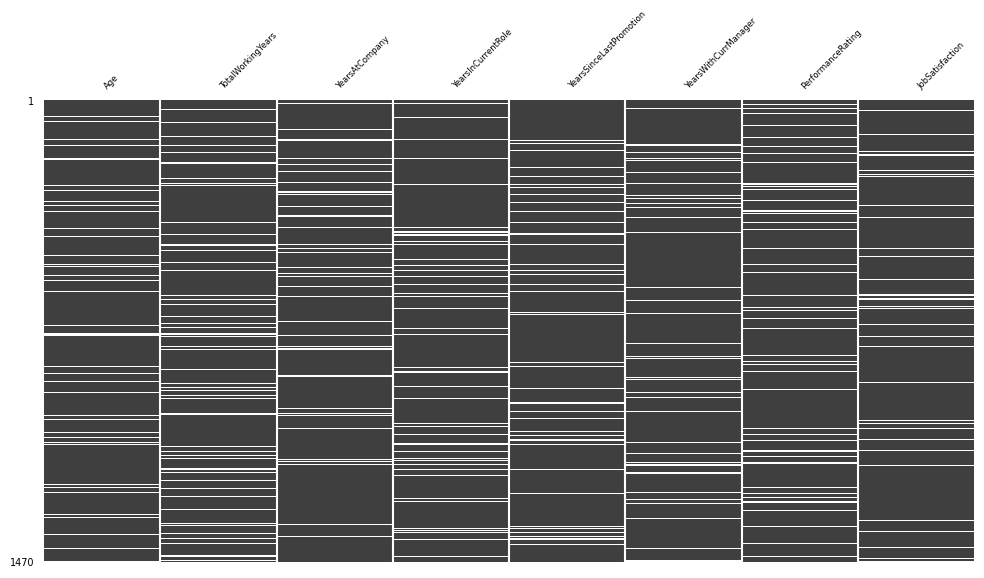

In [78]:
# there are no apparent white bands that would make logically filling in the data
msno.matrix(df1, sparkline=False, figsize=(12,6), fontsize=6)

In [79]:
# selecting year columns with a slice
_ = df1.iloc[:, 1:-2]
# several of the columns have more than 3 missing values but none are missing completely
_[_.isnull().sum(axis=1)>=3]

TotalWorkingYears  YearsAtCompany  YearsInCurrentRole  \
47             8.582418             NaN                 NaN   
165           23.143622             NaN            3.239644   
186           22.384611             NaN                 NaN   
427                 NaN       17.768572                 NaN   
435                 NaN        7.583210                 NaN   
454                 NaN             NaN            2.009953   
459                 NaN             NaN                 NaN   
542                 NaN        0.950828                 NaN   
677           30.070683             NaN                 NaN   
691            3.544187             NaN                 NaN   
842            1.054387             NaN            0.938421   
871            0.898816             NaN                 NaN   
1149                NaN        6.253246                 NaN   
1159          10.537126             NaN                 NaN   
1175                NaN        4.901537                 NaN   
1253                NaN             NaN            6.734378   
1310                NaN        1.719498            2.027704   
1375                NaN             NaN            1.030764   

      YearsSinceLastPromotion  YearsWithCurrManager  
47                        NaN              0.000000  
165                       NaN                   NaN  
186                 10.570969                   NaN  
427                       NaN             11.450390  
435                       NaN              7.853904  
454                  1.055888                   NaN  
459                       NaN              8.082320  
542                       NaN              0.000000  
677                  1.136934                   NaN  
691                       NaN                   NaN  
842                       NaN                   NaN  
871                  0.000000                   NaN  
1149                      NaN              6.713922  
1159                 3.102793                   NaN  
1175                      NaN              0.000000  
1253                      NaN              6.048237  
1310                      NaN                   NaN  
1375                      NaN              3.443368

In [80]:
year_features= ["TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]

In [81]:
# if else lambda func
df['TotalWorkingYears'] = df.apply(lambda x: np.nanmax(x[year_features]) if pd.isna(x['TotalWorkingYears']) else x['TotalWorkingYears'], axis=1)
df.isnull().sum()

Age                         147
Attrition                   147
BusinessTravel              147
DailyRate                   147
Department                  147
DistanceFromHome            147
Education                   147
EducationField              147
EmployeeCount               147
EmployeeNumber              147
EnvironmentSatisfaction     147
Gender                      147
HourlyRate                  147
JobInvolvement              147
JobLevel                    147
JobRole                     147
JobSatisfaction             147
MaritalStatus               147
MonthlyIncome               147
MonthlyRate                 147
NumCompaniesWorked          147
OverTime                    147
PercentSalaryHike           147
PerformanceRating           147
RelationshipSatisfaction    147
StandardHours               147
StockOptionLevel            147
TotalWorkingYears             0
TrainingTimesLastYear       147
WorkLifeBalance             147
YearsAtCompany              147
YearsInC

In [82]:
def binning_years(df, year_features):

    for var in year_features:
        # include 75th percentile in bins
        per75 = df[var].quantile(0.75)
        # number of bins needed, rounded up
        bins = math.ceil(per75 / 5)
    
        # set bin edges
        bin_edges = [i * 5 for i in range(bins+1)] + [df[var].max()]
        #print(bin_edges)
    
        start = 0
        # bin labels
        bin_labels = [f'{start}-{start + 5}' for start in range(0, bins * 5, 5)] + [f'{bins * 5}+']
        #print(bin_labels)

        binned_var = var + "_bins"
        
        df[binned_var] = pd.cut(df[var], bins=bin_edges, labels=bin_labels, include_lowest=True)
    
        # easier to fill with unknown in this function
        #df[var] = df[var].cat.add_categories(['Unknown'])
        df[binned_var] = df[binned_var].astype("object")

        
        
        df[binned_var] = df[binned_var].fillna('Unknown')
    return df

In [83]:
df = binning_years(df, year_features)
df = binning_years(df, ["Age"]) # binning age also
df.head()

Age Attrition     BusinessTravel    DailyRate              Department  \
0  41.9       Yes      Travel_Rarely   990.110009                   Sales   
1  51.6        No  Travel_Frequently   276.776030  Research & Development   
2  33.1       Yes      Travel_Rarely  1204.158501  Research & Development   
3  34.7        No  Travel_Frequently  1352.752432                   Sales   
4  24.8        No      Travel_Rarely   485.053333  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0          1.016716   1.770313  Life Sciences       1.033298        1.054148   
1               NaN   1.035333  Life Sciences       0.944859        2.107031   
2          2.198662   2.118801          Other       0.810809        4.008125   
3          2.937851   3.670674  Life Sciences       0.822976        4.587269   
4          1.988953   1.120496        Medical            NaN        7.228740   

   ...  YearsAtCompany YearsInCurrentRole  YearsSinceLastPromotion  \
0  ...        5.795945           3.993896                 0.000000   
1  ...       10.070232           7.937505                 1.032295   
2  ...        0.000000           0.000000                 0.000000   
3  ...        8.435324           5.563667                 2.845429   
4  ...        2.040124           1.970786                 2.495949   

   YearsWithCurrManager  TotalWorkingYears_bins YearsAtCompany_bins  \
0              4.594972                    5-10                5-10   
1              5.901207                    5-10                 10+   
2              0.000000                    5-10                 0-5   
3              0.000000                    5-10                5-10   
4              2.219353                    5-10                 0-5   

   YearsInCurrentRole_bins YearsSinceLastPromotion_bins  \
0                      0-5                          0-5   
1                     5-10                          0-5   
2                      0-5                          0-5   
3                     5-10                          0-5   
4                      0-5                          0-5   

   YearsWithCurrManager_bins  Age_bins  
0                        0-5     40-45  
1                       5-10       45+  
2                        0-5     30-35  
3                        0-5     30-35  
4                        0-5     20-25  

[5 rows x 40 columns]

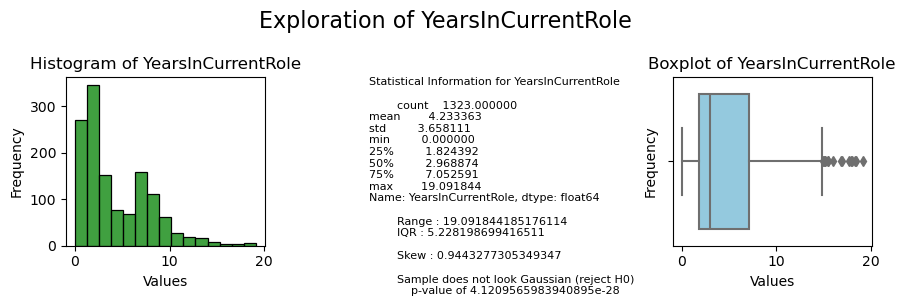

In [84]:
numerical_explore(df, "YearsInCurrentRole")

#### Ordinal features

In [85]:
# Some features appear to be ordinal
# these will be encoded as such
df.describe().T

count          mean          std          min  \
Age                       1323.0     36.642706     9.866306    18.000000   
DailyRate                 1323.0    802.030050   414.031025    86.828045   
DistanceFromHome          1323.0      9.091097     8.177870     0.750112   
Education                 1323.0      2.923447     1.072203     0.770362   
EmployeeCount             1323.0      0.999325     0.099656     0.628985   
EmployeeNumber            1323.0   1026.679166   610.480802     1.054148   
EnvironmentSatisfaction   1323.0      2.726443     1.129679     0.759655   
HourlyRate                1323.0     65.647722    21.469709    23.855272   
JobInvolvement            1323.0      2.743028     0.765568     0.722008   
JobLevel                  1323.0      2.058270     1.127018     0.715172   
JobSatisfaction           1323.0      2.715272     1.146786     0.724192   
MonthlyIncome             1323.0   6544.718401  4766.580903   891.481007   
MonthlyRate               1323.0  14364.334764  7269.420895  1567.502382   
NumCompaniesWorked        1323.0      2.654394     2.508952     0.000000   
PercentSalaryHike         1323.0     15.295717     3.995702     7.684723   
PerformanceRating         1323.0      3.149344     0.476027     2.116951   
RelationshipSatisfaction  1323.0      2.720431     1.115959     0.720696   
StandardHours             1323.0     80.241313     8.022535    53.793059   
StockOptionLevel          1323.0      0.814757     0.863076     0.000000   
TotalWorkingYears         1470.0     10.972924     8.005039     0.000000   
TrainingTimesLastYear     1323.0      2.811756     1.329044     0.000000   
WorkLifeBalance           1323.0      2.762825     0.761802     0.799138   
YearsAtCompany            1323.0      6.933624     6.046798     0.000000   
YearsInCurrentRole        1323.0      4.233363     3.658111     0.000000   
YearsSinceLastPromotion   1323.0      2.160710     3.221481     0.000000   
YearsWithCurrManager      1323.0      4.117695     3.594053     0.000000   

                                  25%           50%           75%  \
Age                         29.600000     35.000000     42.750000   
DailyRate                  456.479553    782.958705   1130.577949   
DistanceFromHome             2.147069      6.920808     13.584900   
Education                    2.122706      3.015658      3.700560   
EmployeeCount                0.931146      0.998949      1.067371   
EmployeeNumber             501.854842   1022.025017   1533.811096   
EnvironmentSatisfaction      1.894818      2.887313      3.676600   
HourlyRate                  47.701897     64.934490     83.038355   
JobInvolvement               2.177638      2.859143      3.179128   
JobLevel                     1.045228      1.936150      2.609707   
JobSatisfaction              1.846039      2.895032      3.676663   
MonthlyIncome             2961.844066   4957.070475   8268.002496   
MonthlyRate               8138.576694  14258.293365  20322.279885   
NumCompaniesWorked           0.948843      1.708812      3.959710   
PercentSalaryHike           12.195197     14.495151     17.745736   
PerformanceRating            2.845502      3.064551      3.335525   
RelationshipSatisfaction     1.909010      2.891235      3.639961   
StandardHours               74.882946     80.351400     85.664169   
StockOptionLevel             0.000000      0.913651      1.082523   
TotalWorkingYears            5.566621      9.011997     14.620003   
TrainingTimesLastYear        1.967328      2.690934      3.366949   
WorkLifeBalance              2.193390      2.899807      3.206117   
YearsAtCompany               2.673269      5.422160      9.238005   
YearsInCurrentRole           1.824392      2.968874      7.052591   
YearsSinceLastPromotion      0.000000      0.967140      2.586631   
YearsWithCurrManager         1.687177      2.939240      6.987964   

                                   max  
Age                          69.400000  
DailyRate                  1

In [86]:
# columns to round
cols = ["Education", "EnvironmentSatisfaction", "JobInvolvement",
        "JobLevel", "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance"]

df[cols] = df[cols].round(rounding)#.astype(int) # doesn't work with na values

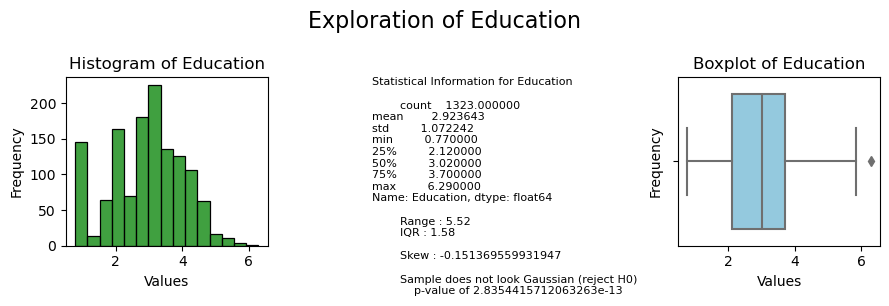

In [87]:
# each of the columns have outliers
# as the column will be made categorical they can be rouned down...
# ...effectively viewing the new top education rank as max
# this removes some intervals but removes fringe cases from analysis
numerical_explore(df, "Education")

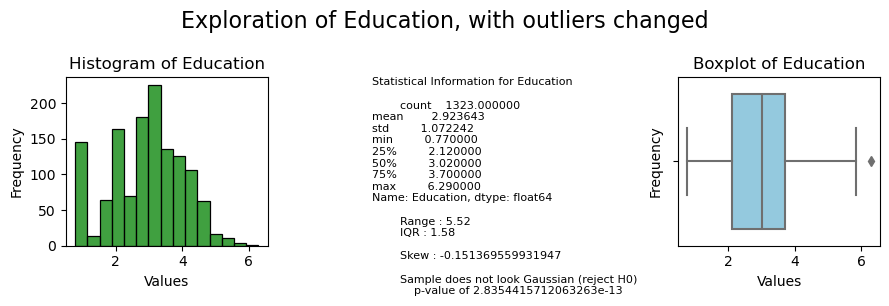

In [88]:
df['Education'] = df['Education'].replace(6.0, 5)
# each of the columns have outliers
numerical_explore(df, "Education", title="with outliers changed")

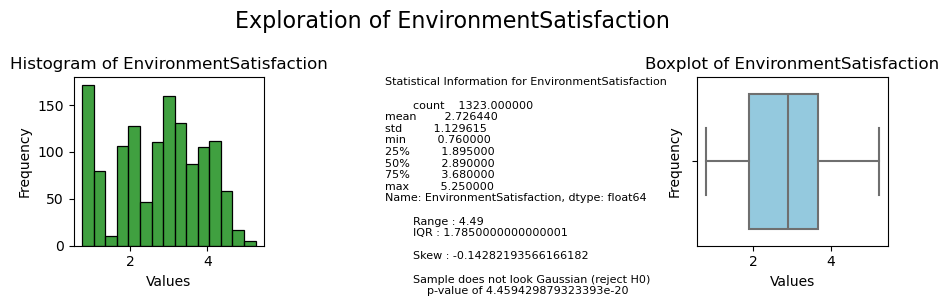

In [89]:
numerical_explore(df, "EnvironmentSatisfaction")

In [90]:
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].replace(5.0, 4)

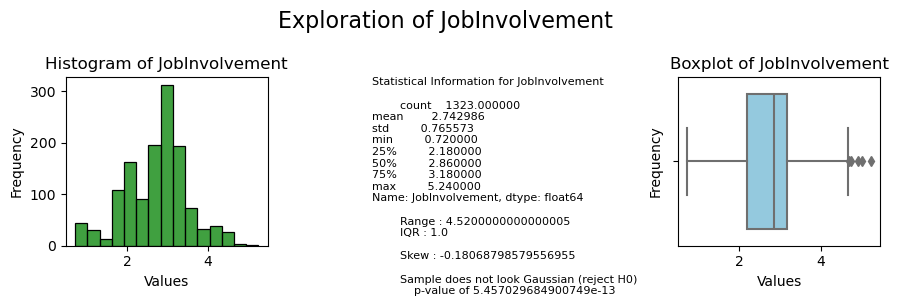

In [91]:
numerical_explore(df, "JobInvolvement")

In [92]:
df['JobInvolvement'] = df['JobInvolvement'].replace(5.0, 4)

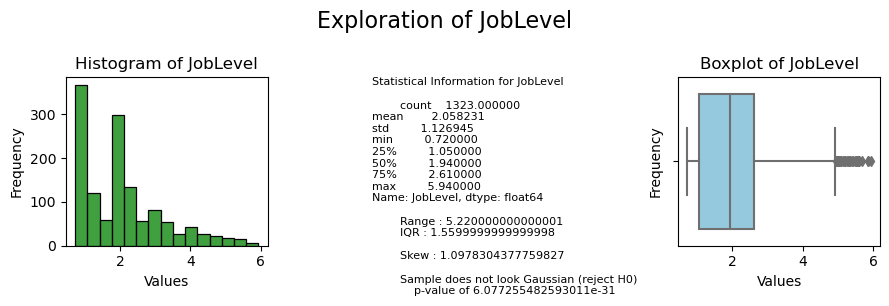

In [93]:
numerical_explore(df, "JobLevel")

In [94]:
df['JobLevel'] = df['JobLevel'].replace(6.0, 5)

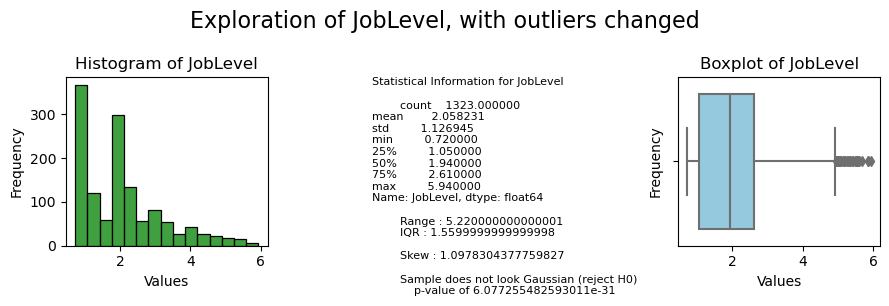

In [95]:
# job level is interesting
# the max job level could be merged with 4 and 5 as the new max,
# but maybe there is enough data points in them both to be useable
numerical_explore(df, "JobLevel", title="with outliers changed")

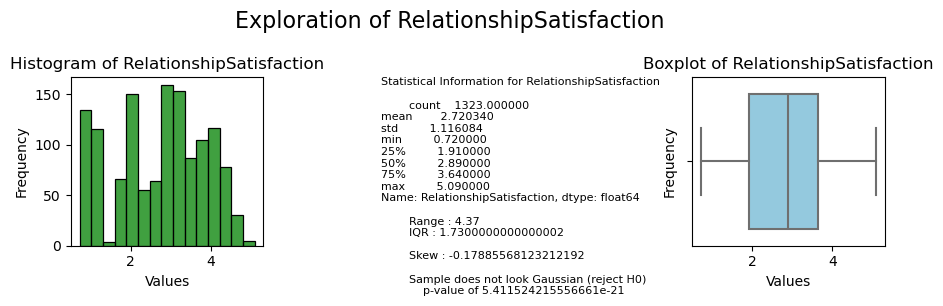

In [96]:
numerical_explore(df, "RelationshipSatisfaction")

In [97]:
df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].replace(5.0, 4)

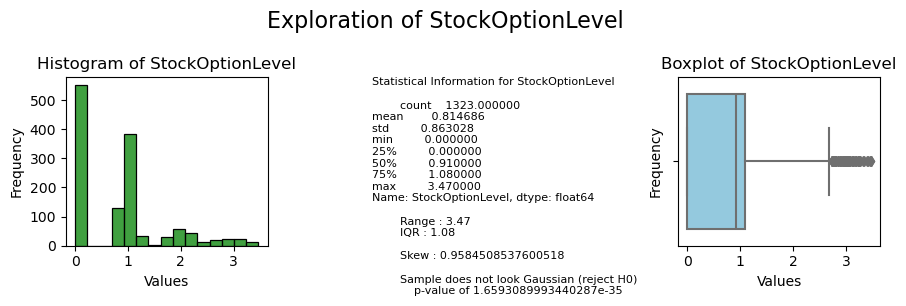

In [98]:
# stock option level is tricky
# as it is left with outliers but they are in a useable volume
# it might be one to look at if a higher level is related to any job types etc.
numerical_explore(df, "StockOptionLevel")

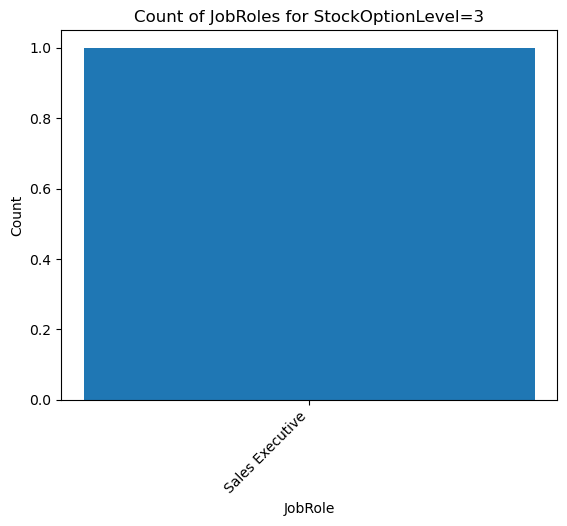

In [99]:
## change these graphs if time ##
# stock option level 3
result = df[df['StockOptionLevel'] == 3][['JobRole', 'StockOptionLevel']]
result = result["JobRole"].value_counts()
plt.bar(result.index, result.values)
plt.xlabel('JobRole')
plt.ylabel('Count')
plt.title('Count of JobRoles for StockOptionLevel=3')
plt.xticks(rotation=45, ha='right')
plt.show()

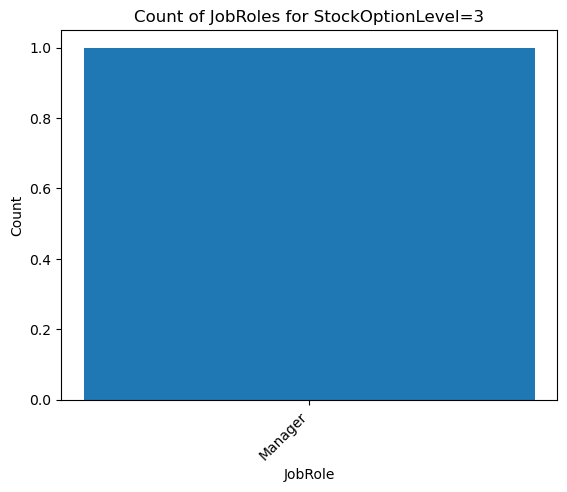

In [100]:
# stock option level 2
result = df[df['StockOptionLevel'] == 2][['JobRole', 'StockOptionLevel']]
result = result["JobRole"].value_counts()
plt.bar(result.index, result.values)
plt.xlabel('JobRole')
plt.ylabel('Count')
plt.title('Count of JobRoles for StockOptionLevel=3')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [101]:
# it's hard to tell what stock level is related to
# could be related to job
# it's hard to tell unless their is noise/randomness in the categories
# will be kept in for modelling and maybe the relationship can be understood
df.JobRole.value_counts()

JobRole
Sales Executive              281
Research Scientist           257
Laboratory Technician        229
Manufacturing Director       122
Healthcare Representative    118
Manager                      101
Research Director             80
Sales Representative          75
Human Resources               60
Name: count, dtype: int64

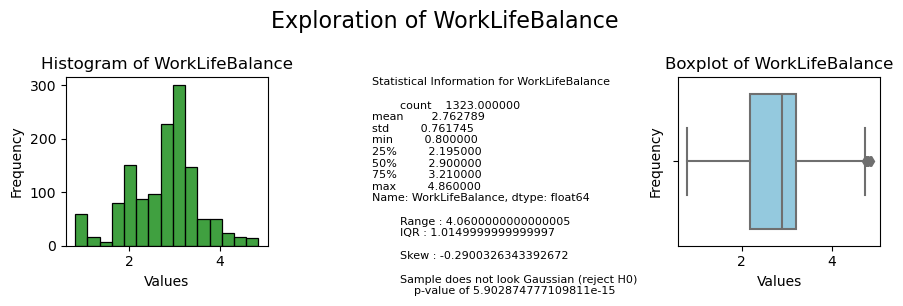

In [102]:
numerical_explore(df, "WorkLifeBalance")

In [103]:
df['WorkLifeBalance'] = df['WorkLifeBalance'].replace(5.0, 4)

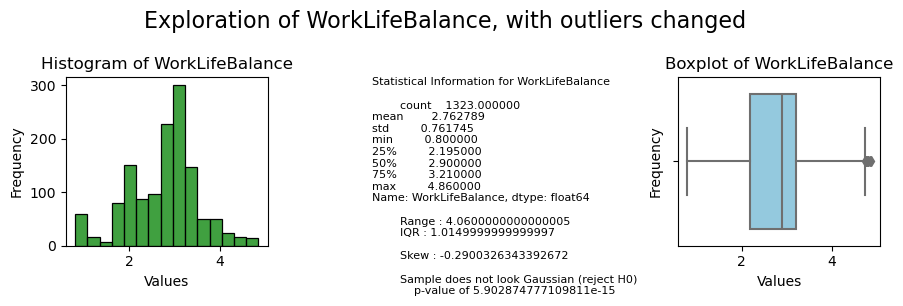

In [104]:
# maybe 1 has enough values to be usable
# a new min could be created too:
# if an employee scored 1-2 for WorkLifeBalance then set as 1 and change others accordingly.
numerical_explore(df, "WorkLifeBalance", title="with outliers changed")

In [105]:
### we have cleaned these features somewhat, but we have added some assumptions

### write down assumptions here ###


# cleaning these features hasn't restored them or attempted to pre disruption
# it has encoded them to allow for categorical analysis and handled small outliers 

#### Rounding Some Columns

In [106]:
# These will be rounded
# TotalWorkingYears wasn't rounded earlier
cols = ["NumCompaniesWorked", "TrainingTimesLastYear", "TotalWorkingYears", "DistanceFromHome"]
cols.remove("TotalWorkingYears")
cols = cols + year_features
cols

['NumCompaniesWorked',
 'TrainingTimesLastYear',
 'DistanceFromHome',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [107]:
df[cols] = df[cols].round(0)

#### Filling Missing Data in Categories

In [108]:
cols = list(df.describe(include="object").columns)

In [109]:
# some have been filled already
df[cols].isnull().sum()

Attrition                       147
BusinessTravel                  147
Department                      147
EducationField                  147
Gender                          147
JobRole                         147
MaritalStatus                   147
OverTime                        147
TotalWorkingYears_bins            0
YearsAtCompany_bins               0
YearsInCurrentRole_bins           0
YearsSinceLastPromotion_bins      0
YearsWithCurrManager_bins         0
Age_bins                          0
dtype: int64

In [110]:
# looping through the categories
# they are unbalanced 
for i in cols:
    print(df[i].value_counts(), "\n") # end param can be used

Attrition
No     1065
Yes     258
Name: count, dtype: int64 

BusinessTravel
Travel_Rarely        890
Travel_Frequently    279
Non-Travel           154
Name: count, dtype: int64 

Department
Research & Development    824
Sales                     393
Human Resources           106
Name: count, dtype: int64 

EducationField
Life Sciences       504
Medical             397
Marketing           149
Technical Degree    141
Other                83
Human Resources      49
Name: count, dtype: int64 

Gender
Male      783
Female    540
Name: count, dtype: int64 

JobRole
Sales Executive              281
Research Scientist           257
Laboratory Technician        229
Manufacturing Director       122
Healthcare Representative    118
Manager                      101
Research Director             80
Sales Representative          75
Human Resources               60
Name: count, dtype: int64 

MaritalStatus
Married     596
Single      429
Divorced    298
Name: count, dtype: int64 

OverTime
No     92

In [111]:
# fill categories with unknown
df[cols] = df[cols].fillna("Unknown")
df.isnull().sum()

Age                             147
Attrition                         0
BusinessTravel                    0
DailyRate                       147
Department                        0
DistanceFromHome                147
Education                       147
EducationField                    0
EmployeeCount                   147
EmployeeNumber                  147
EnvironmentSatisfaction         147
Gender                            0
HourlyRate                      147
JobInvolvement                  147
JobLevel                        147
JobRole                           0
JobSatisfaction                 147
MaritalStatus                     0
MonthlyIncome                   147
MonthlyRate                     147
NumCompaniesWorked              147
OverTime                          0
PercentSalaryHike               147
PerformanceRating               147
RelationshipSatisfaction        147
StandardHours                   147
StockOptionLevel                147
TotalWorkingYears           

#### Money columns

In [112]:
# four columns are about monetary rates of the employees
# PercentSalaryHike is included here, and two decimal places will be kept as the level of percision
cols = ["DailyRate", "HourlyRate", "MonthlyIncome", "MonthlyRate", "PercentSalaryHike"]

In [113]:
# the question of precision is raised here.
# how precise do these figures need to be for modellin?


In [114]:

df[cols] = df[cols].round(2)

#### Remaining Columns

In [115]:
df.describe().T

count          mean          std          min  \
Age                       1323.0     36.642706     9.866306    18.000000   
DailyRate                 1323.0    802.029947   414.030836    86.830000   
DistanceFromHome          1323.0      9.088435     8.173175     1.000000   
Education                 1323.0      2.923643     1.072242     0.770000   
EmployeeCount             1323.0      0.999325     0.099656     0.628985   
EmployeeNumber            1323.0   1026.679166   610.480802     1.054148   
EnvironmentSatisfaction   1323.0      2.726440     1.129615     0.760000   
HourlyRate                1323.0     65.647695    21.469735    23.860000   
JobInvolvement            1323.0      2.742986     0.765573     0.720000   
JobLevel                  1323.0      2.058231     1.126945     0.720000   
JobSatisfaction           1323.0      2.715272     1.146786     0.724192   
MonthlyIncome             1323.0   6544.718443  4766.580923   891.480000   
MonthlyRate               1323.0  14364.334724  7269.420935  1567.500000   
NumCompaniesWorked        1323.0      2.653817     2.511313     0.000000   
PercentSalaryHike         1323.0     15.295782     3.995746     7.680000   
PerformanceRating         1323.0      3.149344     0.476027     2.116951   
RelationshipSatisfaction  1323.0      2.720340     1.116084     0.720000   
StandardHours             1323.0     80.241313     8.022535    53.793059   
StockOptionLevel          1323.0      0.814686     0.863028     0.000000   
TotalWorkingYears         1470.0     10.965306     8.015694     0.000000   
TrainingTimesLastYear     1323.0      2.811036     1.325520     0.000000   
WorkLifeBalance           1323.0      2.762789     0.761745     0.800000   
YearsAtCompany            1323.0      6.928193     6.042473     0.000000   
YearsInCurrentRole        1323.0      4.232048     3.659460     0.000000   
YearsSinceLastPromotion   1323.0      2.160998     3.223250     0.000000   
YearsWithCurrManager      1323.0      4.117914     3.600261     0.000000   

                                  25%           50%           75%  \
Age                         29.600000     35.000000     42.750000   
DailyRate                  456.480000    782.960000   1130.580000   
DistanceFromHome             2.000000      7.000000     14.000000   
Education                    2.120000      3.020000      3.700000   
EmployeeCount                0.931146      0.998949      1.067371   
EmployeeNumber             501.854842   1022.025017   1533.811096   
EnvironmentSatisfaction      1.895000      2.890000      3.680000   
HourlyRate                  47.705000     64.930000     83.035000   
JobInvolvement               2.180000      2.860000      3.180000   
JobLevel                     1.050000      1.940000      2.610000   
JobSatisfaction              1.846039      2.895032      3.676663   
MonthlyIncome             2961.845000   4957.070000   8268.005000   
MonthlyRate               8138.575000  14258.290000  20322.280000   
NumCompaniesWorked           1.000000      2.000000      4.000000   
PercentSalaryHike           12.195000     14.500000     17.745000   
PerformanceRating            2.845502      3.064551      3.335525   
RelationshipSatisfaction     1.910000      2.890000      3.640000   
StandardHours               74.882946     80.351400     85.664169   
StockOptionLevel             0.000000      0.910000      1.080000   
TotalWorkingYears            6.000000      9.000000     15.000000   
TrainingTimesLastYear        2.000000      3.000000      3.000000   
WorkLifeBalance              2.195000      2.900000      3.210000   
YearsAtCompany               3.000000      5.000000      9.000000   
YearsInCurrentRole           2.000000      3.000000      7.000000   
YearsSinceLastPromotion      0.000000      1.000000      3.000000   
YearsWithCurrManager         2.000000      3.000000      7.000000   

                                   max  
Age                          69.400000  
DailyRate                  1

#### 'Target' Variables

In [116]:
# testing rounding them for regression
# these were statistical targets identified and were modelled with regression but with poor results
cols = ["JobSatisfaction", "PerformanceRating"]

In [117]:
df[cols] = df[cols].round(0)

#### Attrition

In [118]:
df.Attrition.value_counts()

Attrition
No         1065
Yes         258
Unknown     147
Name: count, dtype: int64

In [119]:
df.Age

0       41.9
1       51.6
2       33.1
3       34.7
4       24.8
        ... 
1465    37.4
1466    35.0
1467    26.9
1468     NaN
1469    38.1
Name: Age, Length: 1470, dtype: float64

#### Employee Count

In [120]:
# 'likely a constant' according to the data dictionary,
#  there are no other features that are a constant value that could have been misslabelled
# is from a normal distribution
# shows no correlation with any other numeric feature

In [121]:
df.EmployeeCount.describe()

count    1323.000000
mean        0.999325
std         0.099656
min         0.628985
25%         0.931146
50%         0.998949
75%         1.067371
max         1.290613
Name: EmployeeCount, dtype: float64

#### Employee Number

In [122]:
# unique number for each employee according to data disct
df.EmployeeNumber.nunique()

1323

In [123]:
df.EmployeeNumber.describe()

count    1323.000000
mean     1026.679166
std       610.480802
min         1.054148
25%       501.854842
50%      1022.025017
75%      1533.811096
max      2530.919375
Name: EmployeeNumber, dtype: float64

In [124]:
# when rounded there are less unique numbers
# noise add
df1.EmployeeNumber = df.EmployeeNumber.round(0)
df1.EmployeeNumber.nunique()

992

#### Drop non-information columns

In [125]:
df = df.drop(["StandardHours", "EmployeeNumber"], axis=1)

In [126]:
# missing value in categories is dealt with
df.select_dtypes(include='object').isnull().sum()

Attrition                       0
BusinessTravel                  0
Department                      0
EducationField                  0
Gender                          0
JobRole                         0
MaritalStatus                   0
OverTime                        0
TotalWorkingYears_bins          0
YearsAtCompany_bins             0
YearsInCurrentRole_bins         0
YearsSinceLastPromotion_bins    0
YearsWithCurrManager_bins       0
Age_bins                        0
dtype: int64

In [127]:
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0  41.9       Yes      Travel_Rarely     990.11                   Sales   
1  51.6        No  Travel_Frequently     276.78  Research & Development   
2  33.1       Yes      Travel_Rarely    1204.16  Research & Development   
3  34.7        No  Travel_Frequently    1352.75                   Sales   
4  24.8        No      Travel_Rarely     485.05  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  \
0               1.0       1.77  Life Sciences       1.033298   
1               NaN       1.04  Life Sciences       0.944859   
2               2.0       2.12          Other       0.810809   
3               3.0       3.67  Life Sciences       0.822976   
4               2.0       1.12        Medical            NaN   

   EnvironmentSatisfaction  ... YearsAtCompany  YearsInCurrentRole  \
0                     2.15  ...            6.0                 4.0   
1                     3.47  ...           10.0                 8.0   
2                     3.98  ...            0.0                 0.0   
3                     3.73  ...            8.0                 6.0   
4                     1.08  ...            2.0                 2.0   

   YearsSinceLastPromotion  YearsWithCurrManager TotalWorkingYears_bins  \
0                      0.0                   5.0                   5-10   
1                      1.0                   6.0                   5-10   
2                      0.0                   0.0                   5-10   
3                      3.0                   0.0                   5-10   
4                      2.0                   2.0                   5-10   

   YearsAtCompany_bins YearsInCurrentRole_bins  YearsSinceLastPromotion_bins  \
0                 5-10                     0-5                           0-5   
1                  10+                    5-10                           0-5   
2                  0-5                     0-5                           0-5   
3                 5-10                    5-10                           0-5   
4                  0-5                     0-5                           0-5   

   YearsWithCurrManager_bins  Age_bins  
0                        0-5     40-45  
1                       5-10       45+  
2                        0-5     30-35  
3                        0-5     30-35  
4                        0-5     20-25  

[5 rows x 38 columns]

In [128]:
df.shape

(1470, 38)

In [129]:
num =len(df.select_dtypes(include="number").columns)
obj = len(df.select_dtypes(include="object").columns)

print(f"Number of numerical features: {num}")
print(f"Number of categorical features: {obj}")

Number of numerical features: 24
Number of categorical features: 14


### 3.3. Apply encoding, scaling and feature engineering as and if required, detailing how and why you used these techniques and the rationale for your decisions.

In [130]:
# some encoding and feature engineering has been performed above
# may add more feature engineering

In [131]:
df_prepared = df.copy()

In [132]:
df_prepared.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0  41.9       Yes      Travel_Rarely     990.11                   Sales   
1  51.6        No  Travel_Frequently     276.78  Research & Development   
2  33.1       Yes      Travel_Rarely    1204.16  Research & Development   
3  34.7        No  Travel_Frequently    1352.75                   Sales   
4  24.8        No      Travel_Rarely     485.05  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  \
0               1.0       1.77  Life Sciences       1.033298   
1               NaN       1.04  Life Sciences       0.944859   
2               2.0       2.12          Other       0.810809   
3               3.0       3.67  Life Sciences       0.822976   
4               2.0       1.12        Medical            NaN   

   EnvironmentSatisfaction  ... YearsAtCompany  YearsInCurrentRole  \
0                     2.15  ...            6.0                 4.0   
1                     3.47  ...           10.0                 8.0   
2                     3.98  ...            0.0                 0.0   
3                     3.73  ...            8.0                 6.0   
4                     1.08  ...            2.0                 2.0   

   YearsSinceLastPromotion  YearsWithCurrManager TotalWorkingYears_bins  \
0                      0.0                   5.0                   5-10   
1                      1.0                   6.0                   5-10   
2                      0.0                   0.0                   5-10   
3                      3.0                   0.0                   5-10   
4                      2.0                   2.0                   5-10   

   YearsAtCompany_bins YearsInCurrentRole_bins  YearsSinceLastPromotion_bins  \
0                 5-10                     0-5                           0-5   
1                  10+                    5-10                           0-5   
2                  0-5                     0-5                           0-5   
3                 5-10                    5-10                           0-5   
4                  0-5                     0-5                           0-5   

   YearsWithCurrManager_bins  Age_bins  
0                        0-5     40-45  
1                       5-10       45+  
2                        0-5     30-35  
3                        0-5     30-35  
4                        0-5     20-25  

[5 rows x 38 columns]

In [133]:
# setting X and y
target = "Attrition"
df_prepared = df_prepared[df_prepared[target] != "Unknown"] # dropping unknowns in target
y = df_prepared["Attrition"]
y = y.reset_index(drop=True) # reseting index for later
X = df_prepared.drop([target], axis=1).reset_index(drop=True)


label_encode = LabelEncoder()
y = label_encode.fit_transform(y)
y

array([1, 0, 1, ..., 0, 0, 0])

In [134]:
label_encode = LabelEncoder()
y = label_encode.fit_transform(y)
y

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [135]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler

In [136]:
def data_prep_trials(X, y, num, imputer = SimpleImputer(), scaler=StandardScaler(), encoder=OneHotEncoder(), sampler=RandomUnderSampler(random_state=42)):
    print(f"Trial {num}: {imputer}, {scaler}, {encoder}")
    
    
    # col type
    categorical_columns = X.select_dtypes(include='object').columns
    numerical_columns = X.select_dtypes(include='number').columns
    
    # Use RandomUnderSampler
    rus = sampler
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([('imputer', imputer), ('scaler', scaler)]), numerical_columns),
            ('cat', encoder, categorical_columns)
        ]
    )

    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('pca', PCA(0.995)),
        #('lda', LDA()),
        ('classifier', LogisticRegression())
    ])
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    
    # predictions
    y_pred = pipeline.predict(X_test)
    
    # accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

#### Trails with under sampler

In [137]:
data_prep_trials(X, y, 1)

Trial 1: SimpleImputer(), StandardScaler(), OneHotEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        59
           1       0.56      0.56      0.56        45

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.62      0.62      0.62       104



In [138]:
data_prep_trials(X, y, 2, scaler=MinMaxScaler())

Trial 2: SimpleImputer(), MinMaxScaler(), OneHotEncoder()
Accuracy: 0.6538461538461539
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        59
           1       0.60      0.60      0.60        45

    accuracy                           0.65       104
   macro avg       0.65      0.65      0.65       104
weighted avg       0.65      0.65      0.65       104



In [139]:
data_prep_trials(X, y, 3, scaler=RobustScaler())

Trial 3: SimpleImputer(), RobustScaler(), OneHotEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        59
           1       0.56      0.56      0.56        45

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.62      0.62      0.62       104



In [140]:
data_prep_trials(X, y, 4, scaler=StandardScaler(), encoder=OrdinalEncoder())

Trial 4: SimpleImputer(), StandardScaler(), OrdinalEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        59
           1       0.55      0.60      0.57        45

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.62      0.62      0.62       104



In [141]:
data_prep_trials(X, y, 5, scaler=MinMaxScaler(), encoder=OrdinalEncoder())

Trial 5: SimpleImputer(), MinMaxScaler(), OrdinalEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66        59
           1       0.55      0.58      0.57        45

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.62      0.62      0.62       104



In [142]:
data_prep_trials(X, y, 6, scaler=RobustScaler(), encoder=OrdinalEncoder())

Trial 6: SimpleImputer(), RobustScaler(), OrdinalEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        59
           1       0.55      0.60      0.57        45

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.62      0.62      0.62       104



In [143]:
data_prep_trials(X, y, 7, imputer=KNNImputer(), scaler=StandardScaler(), encoder=OneHotEncoder())

Trial 7: KNNImputer(), StandardScaler(), OneHotEncoder()
Accuracy: 0.6346153846153846
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        59
           1       0.57      0.60      0.59        45

    accuracy                           0.63       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.64      0.63      0.64       104



In [144]:
data_prep_trials(X, y, 8, imputer=KNNImputer(), scaler=MinMaxScaler(), encoder=OneHotEncoder())

Trial 8: KNNImputer(), MinMaxScaler(), OneHotEncoder()
Accuracy: 0.6634615384615384
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        59
           1       0.61      0.60      0.61        45

    accuracy                           0.66       104
   macro avg       0.66      0.66      0.66       104
weighted avg       0.66      0.66      0.66       104



In [145]:
data_prep_trials(X, y, 9, imputer=KNNImputer(), scaler=RobustScaler(), encoder=OneHotEncoder())

Trial 9: KNNImputer(), RobustScaler(), OneHotEncoder()
Accuracy: 0.625
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67        59
           1       0.57      0.58      0.57        45

    accuracy                           0.62       104
   macro avg       0.62      0.62      0.62       104
weighted avg       0.63      0.62      0.63       104



In [146]:
data_prep_trials(X, y, 10, imputer=KNNImputer(), scaler=StandardScaler(), encoder=OrdinalEncoder())

Trial 10: KNNImputer(), StandardScaler(), OrdinalEncoder()
Accuracy: 0.625
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.65        59
           1       0.56      0.62      0.59        45

    accuracy                           0.62       104
   macro avg       0.62      0.62      0.62       104
weighted avg       0.63      0.62      0.63       104



In [147]:
data_prep_trials(X, y, 11, imputer=KNNImputer(), scaler=MinMaxScaler(), encoder=OrdinalEncoder())

Trial 11: KNNImputer(), MinMaxScaler(), OrdinalEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66        59
           1       0.55      0.58      0.57        45

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.62      0.62      0.62       104



In [148]:
data_prep_trials(X, y, 12, imputer=KNNImputer(), scaler=RobustScaler(), encoder=OrdinalEncoder())

Trial 12: KNNImputer(), RobustScaler(), OrdinalEncoder()
Accuracy: 0.625
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.65        59
           1       0.56      0.62      0.59        45

    accuracy                           0.62       104
   macro avg       0.62      0.62      0.62       104
weighted avg       0.63      0.62      0.63       104



In [149]:
data_prep_trials(X, y, 13, imputer=IterativeImputer(), scaler=StandardScaler(), encoder=OneHotEncoder())

Trial 13: IterativeImputer(), StandardScaler(), OneHotEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        59
           1       0.55      0.62      0.58        45

    accuracy                           0.62       104
   macro avg       0.61      0.62      0.61       104
weighted avg       0.62      0.62      0.62       104



In [150]:
data_prep_trials(X, y, 14, imputer=IterativeImputer(), scaler=MinMaxScaler(), encoder=OneHotEncoder())

Trial 14: IterativeImputer(), MinMaxScaler(), OneHotEncoder()
Accuracy: 0.6442307692307693
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68        59
           1       0.58      0.62      0.60        45

    accuracy                           0.64       104
   macro avg       0.64      0.64      0.64       104
weighted avg       0.65      0.64      0.65       104



In [151]:
data_prep_trials(X, y, 15, imputer=IterativeImputer(), scaler=RobustScaler(), encoder=OneHotEncoder())

Trial 15: IterativeImputer(), RobustScaler(), OneHotEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        59
           1       0.55      0.62      0.58        45

    accuracy                           0.62       104
   macro avg       0.61      0.62      0.61       104
weighted avg       0.62      0.62      0.62       104



In [152]:
data_prep_trials(X, y, 16, imputer=IterativeImputer(), scaler=StandardScaler(), encoder=OrdinalEncoder())

Trial 16: IterativeImputer(), StandardScaler(), OrdinalEncoder()
Accuracy: 0.6346153846153846
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        59
           1       0.57      0.60      0.59        45

    accuracy                           0.63       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.64      0.63      0.64       104



In [153]:
data_prep_trials(X, y, 17, imputer=IterativeImputer(), scaler=MinMaxScaler(), encoder=OrdinalEncoder())

Trial 17: IterativeImputer(), MinMaxScaler(), OrdinalEncoder()
Accuracy: 0.6153846153846154
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66        59
           1       0.55      0.58      0.57        45

    accuracy                           0.62       104
   macro avg       0.61      0.61      0.61       104
weighted avg       0.62      0.62      0.62       104



In [154]:
data_prep_trials(X, y, 18, imputer=IterativeImputer(), scaler=RobustScaler(), encoder=OrdinalEncoder())

Trial 18: IterativeImputer(), RobustScaler(), OrdinalEncoder()
Accuracy: 0.6346153846153846
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        59
           1       0.57      0.60      0.59        45

    accuracy                           0.63       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.64      0.63      0.64       104



#### Trials with Over sampler

In [155]:
data_prep_trials(X, y, 1,sampler = RandomOverSampler(random_state=42))

Trial 1: SimpleImputer(), StandardScaler(), OneHotEncoder()
Accuracy: 0.6995305164319249
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       211
           1       0.71      0.69      0.70       215

    accuracy                           0.70       426
   macro avg       0.70      0.70      0.70       426
weighted avg       0.70      0.70      0.70       426



In [156]:
data_prep_trials(X, y, 2, scaler=MinMaxScaler(), sampler=RandomOverSampler(random_state=42))

Trial 2: SimpleImputer(), MinMaxScaler(), OneHotEncoder()
Accuracy: 0.7136150234741784
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.71       211
           1       0.72      0.70      0.71       215

    accuracy                           0.71       426
   macro avg       0.71      0.71      0.71       426
weighted avg       0.71      0.71      0.71       426



In [157]:
data_prep_trials(X, y, 3, scaler=RobustScaler(), sampler=RandomOverSampler(random_state=42))

Trial 3: SimpleImputer(), RobustScaler(), OneHotEncoder()
Accuracy: 0.7018779342723005
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       211
           1       0.71      0.69      0.70       215

    accuracy                           0.70       426
   macro avg       0.70      0.70      0.70       426
weighted avg       0.70      0.70      0.70       426



In [158]:
data_prep_trials(X, y, 4, scaler=StandardScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 4: SimpleImputer(), StandardScaler(), OrdinalEncoder()
Accuracy: 0.7089201877934272
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71       211
           1       0.72      0.69      0.71       215

    accuracy                           0.71       426
   macro avg       0.71      0.71      0.71       426
weighted avg       0.71      0.71      0.71       426



In [159]:
data_prep_trials(X, y, 5, scaler=MinMaxScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 5: SimpleImputer(), MinMaxScaler(), OrdinalEncoder()
Accuracy: 0.6948356807511737
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       211
           1       0.71      0.68      0.69       215

    accuracy                           0.69       426
   macro avg       0.70      0.69      0.69       426
weighted avg       0.70      0.69      0.69       426



In [160]:
data_prep_trials(X, y, 6, scaler=RobustScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 6: SimpleImputer(), RobustScaler(), OrdinalEncoder()
Accuracy: 0.704225352112676
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       211
           1       0.71      0.69      0.70       215

    accuracy                           0.70       426
   macro avg       0.70      0.70      0.70       426
weighted avg       0.70      0.70      0.70       426



In [161]:
data_prep_trials(X, y, 7, imputer=KNNImputer(), scaler=StandardScaler(), encoder=OneHotEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 7: KNNImputer(), StandardScaler(), OneHotEncoder()
Accuracy: 0.7183098591549296
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       211
           1       0.72      0.73      0.72       215

    accuracy                           0.72       426
   macro avg       0.72      0.72      0.72       426
weighted avg       0.72      0.72      0.72       426



In [162]:
data_prep_trials(X, y, 8, imputer=KNNImputer(), scaler=MinMaxScaler(), encoder=OneHotEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 8: KNNImputer(), MinMaxScaler(), OneHotEncoder()
Accuracy: 0.7136150234741784
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       211
           1       0.72      0.72      0.72       215

    accuracy                           0.71       426
   macro avg       0.71      0.71      0.71       426
weighted avg       0.71      0.71      0.71       426



In [163]:
data_prep_trials(X, y, 9, imputer=KNNImputer(), scaler=RobustScaler(), encoder=OneHotEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 9: KNNImputer(), RobustScaler(), OneHotEncoder()
Accuracy: 0.7183098591549296
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       211
           1       0.72      0.73      0.72       215

    accuracy                           0.72       426
   macro avg       0.72      0.72      0.72       426
weighted avg       0.72      0.72      0.72       426



In [164]:
data_prep_trials(X, y, 10, imputer=KNNImputer(), scaler=StandardScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 10: KNNImputer(), StandardScaler(), OrdinalEncoder()
Accuracy: 0.715962441314554
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       211
           1       0.72      0.73      0.72       215

    accuracy                           0.72       426
   macro avg       0.72      0.72      0.72       426
weighted avg       0.72      0.72      0.72       426



In [165]:
data_prep_trials(X, y, 11, imputer=KNNImputer(), scaler=MinMaxScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 11: KNNImputer(), MinMaxScaler(), OrdinalEncoder()
Accuracy: 0.715962441314554
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       211
           1       0.72      0.72      0.72       215

    accuracy                           0.72       426
   macro avg       0.72      0.72      0.72       426
weighted avg       0.72      0.72      0.72       426



In [166]:
data_prep_trials(X, y, 12, imputer=KNNImputer(), scaler=RobustScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 12: KNNImputer(), RobustScaler(), OrdinalEncoder()
Accuracy: 0.715962441314554
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       211
           1       0.72      0.73      0.72       215

    accuracy                           0.72       426
   macro avg       0.72      0.72      0.72       426
weighted avg       0.72      0.72      0.72       426



In [167]:
data_prep_trials(X, y, 13, imputer=IterativeImputer(), scaler=StandardScaler(), encoder=OneHotEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 13: IterativeImputer(), StandardScaler(), OneHotEncoder()
Accuracy: 0.704225352112676
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       211
           1       0.71      0.70      0.71       215

    accuracy                           0.70       426
   macro avg       0.70      0.70      0.70       426
weighted avg       0.70      0.70      0.70       426



In [168]:
data_prep_trials(X, y, 14, imputer=IterativeImputer(), scaler=MinMaxScaler(), encoder=OneHotEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 14: IterativeImputer(), MinMaxScaler(), OneHotEncoder()
Accuracy: 0.7065727699530516
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71       211
           1       0.71      0.70      0.71       215

    accuracy                           0.71       426
   macro avg       0.71      0.71      0.71       426
weighted avg       0.71      0.71      0.71       426



In [169]:
data_prep_trials(X, y, 15, imputer=IterativeImputer(), scaler=RobustScaler(), encoder=OneHotEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 15: IterativeImputer(), RobustScaler(), OneHotEncoder()
Accuracy: 0.704225352112676
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       211
           1       0.71      0.70      0.70       215

    accuracy                           0.70       426
   macro avg       0.70      0.70      0.70       426
weighted avg       0.70      0.70      0.70       426



In [170]:
data_prep_trials(X, y, 16, imputer=IterativeImputer(), scaler=StandardScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 16: IterativeImputer(), StandardScaler(), OrdinalEncoder()
Accuracy: 0.6995305164319249
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       211
           1       0.70      0.71      0.71       215

    accuracy                           0.70       426
   macro avg       0.70      0.70      0.70       426
weighted avg       0.70      0.70      0.70       426



In [171]:
data_prep_trials(X, y, 17, imputer=IterativeImputer(), scaler=MinMaxScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 17: IterativeImputer(), MinMaxScaler(), OrdinalEncoder()
Accuracy: 0.6971830985915493
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       211
           1       0.70      0.70      0.70       215

    accuracy                           0.70       426
   macro avg       0.70      0.70      0.70       426
weighted avg       0.70      0.70      0.70       426



In [172]:
data_prep_trials(X, y, 18, imputer=IterativeImputer(), scaler=RobustScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42))

Trial 18: IterativeImputer(), RobustScaler(), OrdinalEncoder()
Accuracy: 0.6995305164319249
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       211
           1       0.70      0.71      0.71       215

    accuracy                           0.70       426
   macro avg       0.70      0.70      0.70       426
weighted avg       0.70      0.70      0.70       426



### 3.4. Explore the possibility of using dimensional reduction on the dataset. Employ both LDA (Linear Discriminant Analysis) and PCA (Principal Component Analysis) and compare the separation of classes through visualization. Explain the difference between both techniques in your own words and discuss in detail how your results may affect your analysis of classifying or clustering the normal as compared to anomalous biddings.

In [173]:
def pca_test(X, y, imputer = KNNImputer(), scaler=MinMaxScaler(), encoder=OrdinalEncoder(), sampler=RandomOverSampler(random_state=42), dim=PCA(0.995)):
    print(f"Trial with {dim} and {imputer}, {scaler}, {encoder}")
    
    # col type
    categorical_columns = X.select_dtypes(include='object').columns
    numerical_columns = X.select_dtypes(include='number').columns
    
    # sampler
    rus = sampler
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([('imputer', imputer), ('scaler', scaler)]), numerical_columns),
            ('cat', encoder, categorical_columns)
        ]
    )

    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('dim',dim), # use for PCA or LDA
        ('classifier', LogisticRegression())
    ])
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    
    # predictions
    y_pred = pipeline.predict(X_test)
    
    # accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Print the classification report and accuracy
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return pipeline


In [174]:
pipe =pca_test(X, y, dim=PCA(0.995))

Trial with PCA(n_components=0.995) and KNNImputer(), MinMaxScaler(), OrdinalEncoder()
Accuracy: 0.7276995305164319
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       211
           1       0.73      0.73      0.73       215

    accuracy                           0.73       426
   macro avg       0.73      0.73      0.73       426
weighted avg       0.73      0.73      0.73       426



In [175]:
pipe.named_steps["dim"]

PCA(n_components=0.995)

In [176]:
pca_test(X, y, dim=LDA())

Trial with LinearDiscriminantAnalysis() and KNNImputer(), MinMaxScaler(), OrdinalEncoder()
Accuracy: 0.7089201877934272
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       211
           1       0.71      0.71      0.71       215

    accuracy                           0.71       426
   macro avg       0.71      0.71      0.71       426
weighted avg       0.71      0.71      0.71       426



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'P...
                                                 ('cat', OrdinalEncoder(),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime', 'TotalWorkingYears_bins',
       'YearsAtCompany_bins', 'YearsInCurrentRole_bins',
       'YearsSinceLastPromotion_bins', 'YearsWithCurrManager_bins',
       'Age_bins'],
      dtype='object'))])),
                ('dim', LinearDiscriminantAnalysis()),
                ('classifier', LogisticRegression())])

In [177]:
# sampler
rus = RandomOverSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include='number').columns

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', KNNImputer()), ('scaler', MinMaxScaler())]), numerical_columns),
        ('cat', OrdinalEncoder(), categorical_columns)
    ]
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('dim',dim), # use for PCA or LDA
    #('classifier', LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)
    
    
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'P...
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')),
                                                 ('cat', OrdinalEncoder(),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime', 'TotalWorkingYears_bins',
       'YearsAtCompany_bins', 'YearsInCurrentRole_bins',
       'YearsSinceLastPromotion_bins', 'YearsWithCurrManager_bins',
       'Age_bins'],
      dtype='object'))]))])

In [178]:
X_processed = pipeline.named_steps['preprocessor'].transform(X_test)

In [179]:
X_processed.shape

(426, 37)

In [180]:
X_processed[:100,:].shape


(100, 37)

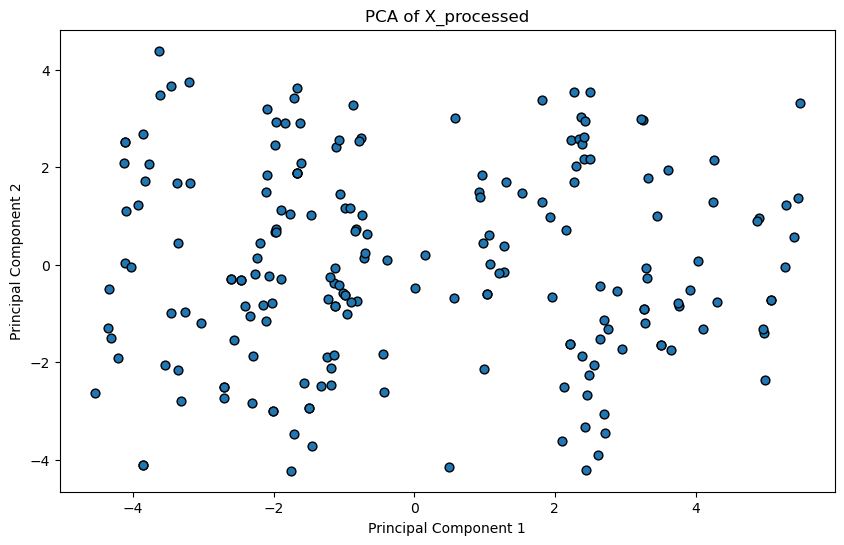

In [181]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.995)  # Specify the number of components you want2
X_pca = pca.fit_transform(X_processed[:200,:])

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis', edgecolor='k', s=40)
plt.title('PCA of X_processed')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [182]:
X_pca.shape

(200, 28)

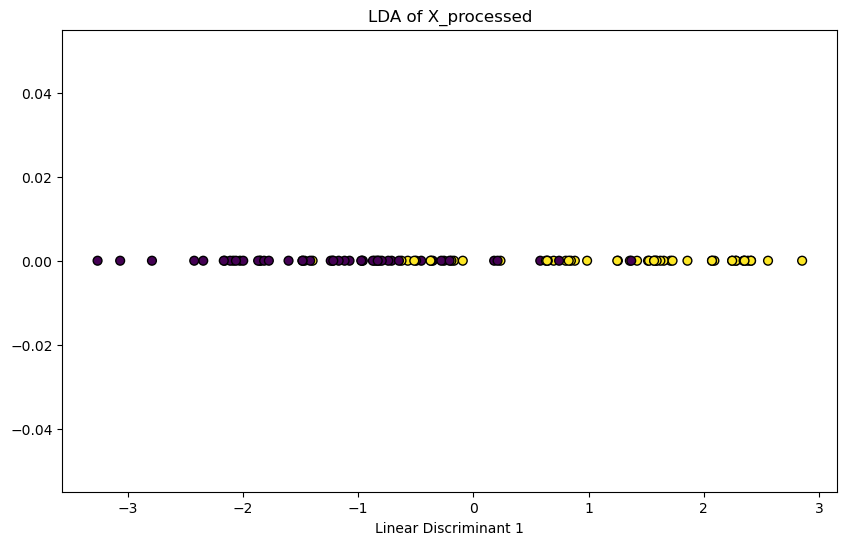

In [183]:
# Apply LDA to reduce dimensionality
slice = 100

lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_processed[:slice,:], y_test[:slice])  # Use y_test for supervised LDA
# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_lda, [0] * len(X_lda), c=y_test[:slice], cmap='viridis', edgecolor='k', s=40)
plt.title('LDA of X_processed')
plt.xlabel('Linear Discriminant 1')
plt.show()

## 4. Module: Statistical Analysis

### 4.1. Use descriptive statistical analyses to explore and evaluate the data set, including measures of central tendency and dispersion and frequency distributions. Correlation matrices are also accepted. Provide a summary of your findings.

In [184]:
### examine the ranges of the data here... or data prep.. or both...

In [185]:
# original dataframe
df = df_orgnl.copy()

In [186]:
df.head()

Age Attrition     BusinessTravel    DailyRate  \
0  41.920786       Yes      Travel_Rarely   990.110009   
1  51.589037        No  Travel_Frequently   276.776030   
2  33.131540       Yes      Travel_Rarely  1204.158501   
3  34.707073        No  Travel_Frequently  1352.752432   
4  24.790188        No      Travel_Rarely   485.053333   

               Department  DistanceFromHome  Education EducationField  \
0                   Sales          1.016716   1.770313  Life Sciences   
1  Research & Development               NaN   1.035333  Life Sciences   
2  Research & Development          2.198662   2.118801          Other   
3                   Sales          2.937851   3.670674  Life Sciences   
4  Research & Development          1.988953   1.120496        Medical   

   EmployeeCount  EmployeeNumber  ...  RelationshipSatisfaction StandardHours  \
0       1.033298        1.054148  ...                  1.012832     95.612654   
1       0.944859        2.107031  ...                  4.312008     85.370868   
2       0.810809        4.008125  ...                  2.332558     76.248084   
3       0.822976        4.587269  ...                  3.029591     75.888697   
4            NaN        7.228740  ...                       NaN     72.670937   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  \
0          0.000000           8.063833               0.000000        1.052104   
1          1.104642           8.965059               3.264952        2.526470   
2          0.000000           8.427238               3.004521        2.924784   
3          0.000000           7.662606               2.856001        3.117053   
4          0.953012           6.241733               2.814719        3.112317   

   YearsAtCompany YearsInCurrentRole  YearsSinceLastPromotion  \
0        5.795945           3.993896                 0.000000   
1       10.070232           7.937505                 1.032295   
2        0.000000           0.000000                 0.000000   
3        8.435324           5.563667                 2.845429   
4        2.040124           1.970786                 2.495949   

   YearsWithCurrManager  
0              4.594972  
1              5.901207  
2              0.000000  
3              0.000000  
4              2.219353  

[5 rows x 35 columns]

In [187]:
# make it a variable
df_descriptive = df.describe().T

# add mode
df_descriptive['mode'] = df.mode().iloc[0]

df_descriptive

count          mean          std          min  \
Age                       1323.0     36.635268     9.882161    14.544608   
DailyRate                 1323.0    802.030050   414.031025    86.828045   
DistanceFromHome          1323.0      9.091097     8.177870     0.750112   
Education                 1323.0      2.923447     1.072203     0.770362   
EmployeeCount             1323.0      0.999325     0.099656     0.628985   
EmployeeNumber            1323.0   1026.679166   610.480802     1.054148   
EnvironmentSatisfaction   1323.0      2.726443     1.129679     0.759655   
HourlyRate                1323.0     65.647722    21.469709    23.855272   
JobInvolvement            1323.0      2.743028     0.765568     0.722008   
JobLevel                  1323.0      2.058270     1.127018     0.715172   
JobSatisfaction           1323.0      2.715272     1.146786     0.724192   
MonthlyIncome             1323.0   6544.718401  4766.580903   891.481007   
MonthlyRate               1323.0  14364.334764  7269.420895  1567.502382   
NumCompaniesWorked        1323.0      2.654394     2.508952     0.000000   
PercentSalaryHike         1323.0     15.295717     3.995702     7.684723   
PerformanceRating         1323.0      3.149344     0.476027     2.116951   
RelationshipSatisfaction  1323.0      2.720431     1.115959     0.720696   
StandardHours             1323.0     80.241313     8.022535    53.793059   
StockOptionLevel          1323.0      0.814757     0.863076     0.000000   
TotalWorkingYears         1323.0     11.426152     8.075870     0.000000   
TrainingTimesLastYear     1323.0      2.811756     1.329044     0.000000   
WorkLifeBalance           1323.0      2.762825     0.761802     0.799138   
YearsAtCompany            1323.0      6.933624     6.046798     0.000000   
YearsInCurrentRole        1323.0      4.233363     3.658111     0.000000   
YearsSinceLastPromotion   1323.0      2.160710     3.221481     0.000000   
YearsWithCurrManager      1323.0      4.117695     3.594053     0.000000   

                                  25%           50%           75%  \
Age                         29.624982     34.951950     42.748741   
DailyRate                  456.479553    782.958705   1130.577949   
DistanceFromHome             2.147069      6.920808     13.584900   
Education                    2.122706      3.015658      3.700560   
EmployeeCount                0.931146      0.998949      1.067371   
EmployeeNumber             501.854842   1022.025017   1533.811096   
EnvironmentSatisfaction      1.894818      2.887313      3.676600   
HourlyRate                  47.701897     64.934490     83.038355   
JobInvolvement               2.177638      2.859143      3.179128   
JobLevel                     1.045228      1.936150      2.609707   
JobSatisfaction              1.846039      2.895032      3.676663   
MonthlyIncome             2961.844066   4957.070475   8268.002496   
MonthlyRate               8138.576694  14258.293365  20322.279885   
NumCompaniesWorked           0.948843      1.708812      3.959710   
PercentSalaryHike           12.195197     14.495151     17.745736   
PerformanceRating            2.845502      3.064551      3.335525   
RelationshipSatisfaction     1.909010      2.891235      3.639961   
StandardHours               74.882946     80.351400     85.664169   
StockOptionLevel             0.000000      0.913651      1.082523   
TotalWorkingYears            5.953221      9.306742     15.324548   
TrainingTimesLastYear        1.967328      2.690934      3.366949   
WorkLifeBalance              2.193390      2.899807      3.206117   
YearsAtCompany               2.673269      5.422160      9.238005   
YearsInCurrentRole           1.824392      2.968874      7.052591   
YearsSinceLastPromotion      0.000000      0.967140      2.586631   
YearsWithCurrManager         1.687177      2.939240      6.987964   

                                   max         mode  
Age                          69.402515    14.544608  
Da

In [188]:
df.describe(include='object').T

count unique                     top  freq
Attrition       1323      2                      No  1065
BusinessTravel  1323      3           Travel_Rarely   890
Department      1323      3  Research & Development   824
EducationField  1323      6           Life Sciences   504
Gender          1323      2                    Male   783
JobRole         1323      9         Sales Executive   281
MaritalStatus   1323      3                 Married   596
Over18          1323      1                       Y  1323
OverTime        1323      2                      No   929

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1323 non-null   float64
 1   Attrition                 1323 non-null   object 
 2   BusinessTravel            1323 non-null   object 
 3   DailyRate                 1323 non-null   float64
 4   Department                1323 non-null   object 
 5   DistanceFromHome          1323 non-null   float64
 6   Education                 1323 non-null   float64
 7   EducationField            1323 non-null   object 
 8   EmployeeCount             1323 non-null   float64
 9   EmployeeNumber            1323 non-null   float64
 10  EnvironmentSatisfaction   1323 non-null   float64
 11  Gender                    1323 non-null   object 
 12  HourlyRate                1323 non-null   float64
 13  JobInvolvement            1323 non-null   float64
 14  JobLevel

In [190]:
# variance
numeric_df = df.select_dtypes(include=['number'])
var_df = numeric_df.var()
var_df

Age                         9.765712e+01
DailyRate                   1.714217e+05
DistanceFromHome            6.687755e+01
Education                   1.149620e+00
EmployeeCount               9.931409e-03
EmployeeNumber              3.726868e+05
EnvironmentSatisfaction     1.276176e+00
HourlyRate                  4.609484e+02
JobInvolvement              5.860946e-01
JobLevel                    1.270170e+00
JobSatisfaction             1.315119e+00
MonthlyIncome               2.272029e+07
MonthlyRate                 5.284448e+07
NumCompaniesWorked          6.294838e+00
PercentSalaryHike           1.596564e+01
PerformanceRating           2.266016e-01
RelationshipSatisfaction    1.245365e+00
StandardHours               6.436107e+01
StockOptionLevel            7.448999e-01
TotalWorkingYears           6.521967e+01
TrainingTimesLastYear       1.766357e+00
WorkLifeBalance             5.803427e-01
YearsAtCompany              3.656377e+01
YearsInCurrentRole          1.338178e+01
YearsSinceLastPr

In [191]:
# ranges
ranges = df.select_dtypes(include=['number']).max() - df.select_dtypes(include=['number']).min()
ranges

Age                            54.857907
DailyRate                    1697.566411
DistanceFromHome               32.934312
Education                       5.514800
EmployeeCount                   0.661628
EmployeeNumber               2529.865227
EnvironmentSatisfaction         4.495018
HourlyRate                     99.345167
JobInvolvement                  4.519960
JobLevel                        5.227097
JobSatisfaction                 4.527085
MonthlyIncome               21966.539381
MonthlyRate                 31184.213419
NumCompaniesWorked             10.855733
PercentSalaryHike              22.112538
PerformanceRating               2.896420
RelationshipSatisfaction        4.371584
StandardHours                  53.585646
StockOptionLevel                3.474319
TotalWorkingYears              47.641892
TrainingTimesLastYear           7.503201
WorkLifeBalance                 4.056948
YearsAtCompany                 36.848408
YearsInCurrentRole             19.091844
YearsSinceLastPr

In [192]:
# Inner Quartile Range
iqr = df.select_dtypes(include=['number']).quantile(0.75) - df.select_dtypes(include=['number']).quantile(0.25)
iqr

Age                            13.123759
DailyRate                     674.098396
DistanceFromHome               11.437831
Education                       1.577854
EmployeeCount                   0.136225
EmployeeNumber               1031.956255
EnvironmentSatisfaction         1.781782
HourlyRate                     35.336459
JobInvolvement                  1.001490
JobLevel                        1.564478
JobSatisfaction                 1.830624
MonthlyIncome                5306.158431
MonthlyRate                 12183.703191
NumCompaniesWorked              3.010867
PercentSalaryHike               5.550539
PerformanceRating               0.490023
RelationshipSatisfaction        1.730951
StandardHours                  10.781223
StockOptionLevel                1.082523
TotalWorkingYears               9.371327
TrainingTimesLastYear           1.399621
WorkLifeBalance                 1.012727
YearsAtCompany                  6.564736
YearsInCurrentRole              5.228199
YearsSinceLastPr

In [193]:
# Measures of variability
summary_table = pd.DataFrame({
    'Variance': var_df,
    'Range': ranges,
    'Inner Quartile Range': iqr
})

print(summary_table)

                              Variance         Range  Inner Quartile Range
Age                       9.765712e+01     54.857907             13.123759
DailyRate                 1.714217e+05   1697.566411            674.098396
DistanceFromHome          6.687755e+01     32.934312             11.437831
Education                 1.149620e+00      5.514800              1.577854
EmployeeCount             9.931409e-03      0.661628              0.136225
EmployeeNumber            3.726868e+05   2529.865227           1031.956255
EnvironmentSatisfaction   1.276176e+00      4.495018              1.781782
HourlyRate                4.609484e+02     99.345167             35.336459
JobInvolvement            5.860946e-01      4.519960              1.001490
JobLevel                  1.270170e+00      5.227097              1.564478
JobSatisfaction           1.315119e+00      4.527085              1.830624
MonthlyIncome             2.272029e+07  21966.539381           5306.158431
MonthlyRate              

In [194]:
correlation_matrix = df.select_dtypes(include=['number'])
correlation_matrix.corr().shape

(26, 26)

In [195]:
correlation_matrix.corr()

Age  DailyRate  DistanceFromHome  Education  \
Age                       1.000000   0.003115         -0.004483   0.218413   
DailyRate                 0.003115   1.000000         -0.004227  -0.012328   
DistanceFromHome         -0.004483  -0.004227          1.000000   0.012109   
Education                 0.218413  -0.012328          0.012109   1.000000   
EmployeeCount            -0.012545   0.009567          0.005865  -0.037297   
EmployeeNumber           -0.003796  -0.050564          0.035067   0.035267   
EnvironmentSatisfaction  -0.011972   0.019894         -0.030355   0.007502   
HourlyRate                0.027241   0.031691          0.026033   0.003187   
JobInvolvement            0.023650   0.051141         -0.005980   0.033630   
JobLevel                  0.467031  -0.013380          0.023336   0.106218   
JobSatisfaction          -0.007174   0.033046          0.021730   0.004137   
MonthlyIncome             0.452439   0.014500         -0.002639   0.093430   
MonthlyRate               0.029848  -0.051747          0.020612  -0.020113   
NumCompaniesWorked        0.283793   0.074620         -0.010111   0.121458   
PercentSalaryHike         0.005143   0.012519          0.051720  -0.021449   
PerformanceRating         0.013791   0.001198         -0.009788  -0.031509   
RelationshipSatisfaction  0.025094   0.019652          0.024771  -0.019207   
StandardHours             0.002155  -0.040108         -0.002562   0.010267   
StockOptionLevel          0.042739   0.007044          0.039794   0.008528   
TotalWorkingYears         0.625620   0.013766          0.004308   0.147655   
TrainingTimesLastYear    -0.021116  -0.009000         -0.047087  -0.034722   
WorkLifeBalance          -0.035865  -0.035260         -0.017814  -0.004356   
YearsAtCompany            0.273534  -0.038210          0.023940   0.075283   
YearsInCurrentRole        0.179098   0.007122          0.020311   0.072572   
YearsSinceLastPromotion   0.183958  -0.022840         -0.005743   0.050648   
YearsWithCurrManager      0.183590  -0.039930          0.033454   0.065608   

                          EmployeeCount  EmployeeNumber  \
Age                           -0.012545       -0.003796   
DailyRate                      0.009567       -0.050564   
DistanceFromHome               0.005865        0.035067   
Education                     -0.037297        0.035267   
EmployeeCount                  1.000000        0.063013   
EmployeeNumber                 0.063013        1.000000   
EnvironmentSatisfaction        0.026024        0.040412   
HourlyRate                     0.056652        0.003557   
JobInvolvement                -0.039578       -0.016547   
JobLevel                       0.004059       -0.004218   
JobSatisfaction                0.011087       -0.032971   
MonthlyIncome                 -0.004826       -0.014102   
MonthlyRate                   -0.035191        0.026890   
NumCompaniesWorked             0.011113       -0.030975   
PercentSalaryHike             -0.022989       -0.020035   
PerformanceRating             -0.012866       -0.021386   
RelationshipSatisfaction       0.015579       -0.072664   
StandardHours                 -0.003399        0.000358   
StockOptionLevel              -0.038158        0.063318   
TotalWorkingYears              0.002776       -0.019994   
TrainingTimesLastYear         -0.054455       -0.006759   
WorkLifeBalance               -0.004015        0.020873   
YearsAtCompany                 0.018562       -0.002520   
YearsInCurrentRole             0.016204       -0.017335   
YearsSinceLastPromotion       -0.004410       -0.008418   
YearsWithCurrManager          -0.033018       -0.020842   

                          EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
Age                                     -0.011972    0.027241        0.023650   
DailyRate                                0.019894    0.031691        0.051141   
DistanceFromHome                        -0.030355    0.026033       -0.005980   
Educat

correlation shape: (26, 26)


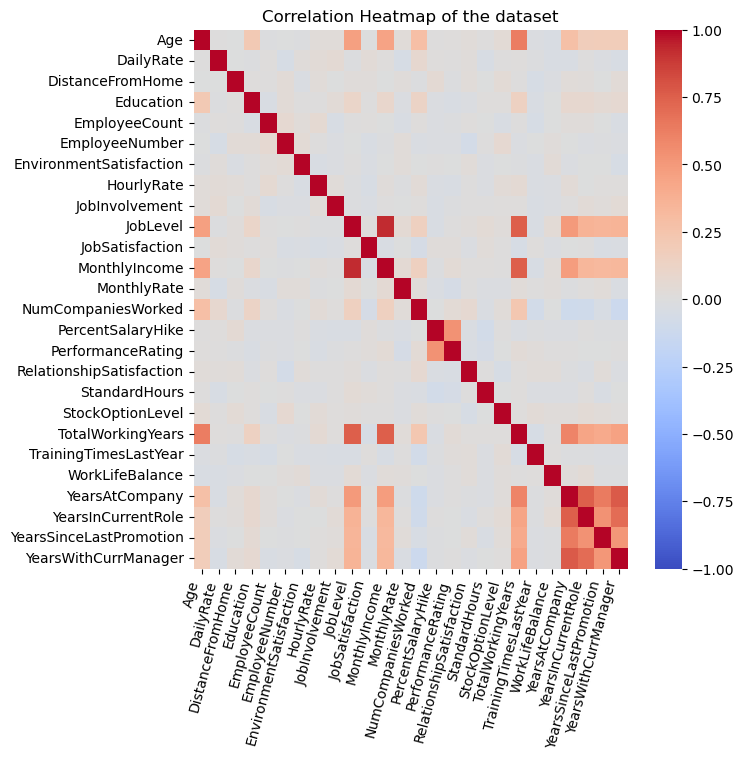

In [196]:
### this correlation section is repeated from data prep ###

# correlation is easier to view in a larger number of features like this
# correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()
print(f"correlation shape: {correlation_matrix.shape}")

# correlation heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.xticks(rotation=75, ha='right')
plt.title('Correlation Heatmap of the dataset')
plt.show()

In [197]:
# from above, monthly income and job level are highly correlated
df.MonthlyIncome.corr(df.JobLevel)

0.9235098140677838

In [198]:
# total working years is correlated with some features too
print("Correlations of TotalWorkingYears")
print("vs. JobLevel: ", df.TotalWorkingYears.corr(df.JobLevel))
print("vs. MonthlyIncome: ", df.TotalWorkingYears.corr(df.MonthlyIncome))
print("vs. YearsAtCompany: ", df.TotalWorkingYears.corr(df.YearsAtCompany))

Correlations of TotalWorkingYears
vs. JobLevel:  0.7568136270833515
vs. MonthlyIncome:  0.757637022403104
vs. YearsAtCompany:  0.593883740319838


In [199]:
# the last 4 columns are correlated together
# they are all related to years working
df.iloc[:,-4:].corr()

YearsAtCompany  YearsInCurrentRole  \
YearsAtCompany                 1.000000            0.753423   
YearsInCurrentRole             0.753423            1.000000   
YearsSinceLastPromotion        0.639672            0.532027   
YearsWithCurrManager           0.767222            0.702790   

                         YearsSinceLastPromotion  YearsWithCurrManager  
YearsAtCompany                          0.639672              0.767222  
YearsInCurrentRole                      0.532027              0.702790  
YearsSinceLastPromotion                 1.000000              0.509521  
YearsWithCurrManager                    0.509521              1.000000

### 4.2. Formulate and test hypotheses within a business context using appropriate statistical techniques like t-tests or ANOVA to identify significant relationships between variables. Provide a summary of your findings. Use at least two statistical tests. 

#### Target variables

In [200]:
# The company wishes to know what features influence these features

In [201]:
# business objectives are represented by features in the data
df[["JobSatisfaction", "PerformanceRating"]].describe()

JobSatisfaction  PerformanceRating
count      1323.000000        1323.000000
mean          2.715272           3.149344
std           1.146786           0.476027
min           0.724192           2.116951
25%           1.846039           2.845502
50%           2.895032           3.064551
75%           3.676663           3.335525
max           5.251277           5.013371

In [202]:
df[["JobSatisfaction", "PerformanceRating"]].head()

JobSatisfaction  PerformanceRating
0         3.397665           2.844897
1         1.584059           4.120281
2         3.301009           2.781168
3         3.220844           2.769576
4         1.697330           3.282183

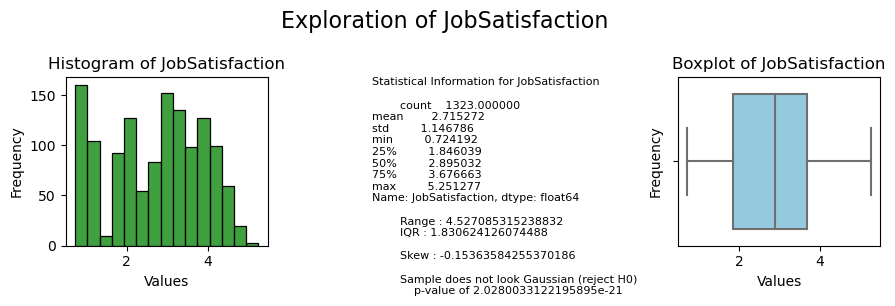

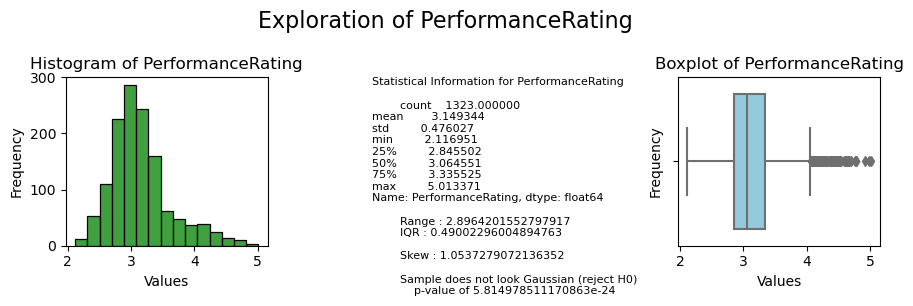

In [203]:
for i in ["JobSatisfaction", "PerformanceRating"]:
    numerical_explore(df, i)

In [204]:
X1 = df["JobSatisfaction"]
X2 = df["PerformanceRating"]

In [205]:
# We can perform the test using those variables
# we show with the two sample t test that the features are independent from each other and require more investigation and predicition of both
# at 5% significance level we reject the hypothesis that these features are the same
X1 = X1.dropna()
X2 = X2.dropna()



t_test = stats.ttest_ind(X1, X2, equal_var = False)
display(t_test)

TtestResult(statistic=-12.715653733987903, pvalue=1.66177889187303e-35, df=1764.4389750891976)

In [206]:
# there is also low correlation between them (which is to be expected)
# but it means that both are to be investigated
X1.corr(X2)

0.02039224505497148

#### Chi Squared Tests

In [207]:
# some categories are examined with chi2 test
# this examines the expected frequency of the categories if they were based on chance and no relationship between them


In [208]:
df.describe(include="object")

Attrition BusinessTravel              Department EducationField Gender  \
count       1323           1323                    1323           1323   1323   
unique         2              3                       3              6      2   
top           No  Travel_Rarely  Research & Development  Life Sciences   Male   
freq        1065            890                     824            504    783   

                JobRole MaritalStatus Over18 OverTime  
count              1323          1323   1323     1323  
unique                9             3      1        2  
top     Sales Executive       Married      Y       No  
freq                281           596   1323      929

In [209]:
def chi_square(df, y, x="Attrition"):

    print(f"Chi squared test for {x} and {y}\n")
    
    contingency_table = pd.crosstab(df[x], df[y])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(contingency_table, "\n")

    print("Chi-squared statistic:", chi2)
    print("p-value:", p)
    print("Degrees of freedom:", dof, "\n")
    print("Expected frequencies:\n", expected)

    if p < 0.01:
        print("\nReject null hypothesis at 99% confidence level:\nThere is a significant relationship")
    elif p < 0.05:
        print("\nReject null hypothesis at 95% confidence level:\nThere is a significant relationship")
    else:
        print("\nAccept null hypothesis:\nThere is no significant relationship")


In [210]:
# there is no relationship proven here
chi_square(df, "BusinessTravel")

Chi squared test for Attrition and BusinessTravel

BusinessTravel  Non-Travel  Travel_Frequently  Travel_Rarely
Attrition                                                   
No                     115                184            655
Yes                     19                 69            146 

Chi-squared statistic: 12.853284660340115
p-value: 0.0016178740115298253
Degrees of freedom: 2 

Expected frequencies:
 [[107.60606061 203.16666667 643.22727273]
 [ 26.39393939  49.83333333 157.77272727]]

Reject null hypothesis at 99% confidence level:
There is a significant relationship


In [211]:
chi_square(df, "Department")

Chi squared test for Attrition and Department

Department  Human Resources  Research & Development  Sales
Attrition                                                 
No                       73                     615    278
Yes                      21                     123     77 

Chi-squared statistic: 4.925509578372196
p-value: 0.08519991956789548
Degrees of freedom: 2 

Expected frequencies:
 [[ 76.49873631 600.59646167 288.90480202]
 [ 17.50126369 137.40353833  66.09519798]]

Accept null hypothesis:
There is no significant relationship


In [212]:
chi_square(df, "Gender")

Chi squared test for Attrition and Gender

Gender     Female  Male
Attrition              
No            391   566
Yes            87   147 

Chi-squared statistic: 0.9107441919088437
p-value: 0.3399170397976415
Degrees of freedom: 1 

Expected frequencies:
 [[384.08564232 572.91435768]
 [ 93.91435768 140.08564232]]

Accept null hypothesis:
There is no significant relationship


In [213]:
chi_square(df, "MaritalStatus")

Chi squared test for Attrition and MaritalStatus

MaritalStatus  Divorced  Married  Single
Attrition                               
No                  224      448     286
Yes                  41       88     107 

Chi-squared statistic: 20.663088139334302
p-value: 3.2588728866429146e-05
Degrees of freedom: 2 

Expected frequencies:
 [[212.62144054 430.05695142 315.32160804]
 [ 52.37855946 105.94304858  77.67839196]]

Reject null hypothesis at 99% confidence level:
There is a significant relationship


In [214]:
chi_square(df, "OverTime")

Chi squared test for Attrition and OverTime

OverTime    No  Yes
Attrition          
No         715  241
Yes        127  109 

Chi-squared statistic: 39.152090903072704
p-value: 3.920431839405795e-10
Degrees of freedom: 1 

Expected frequencies:
 [[675.29530201 280.70469799]
 [166.70469799  69.29530201]]

Reject null hypothesis at 99% confidence level:
There is a significant relationship


#### ANOVA

In [215]:
df["JobRole"].value_counts()

JobRole
Sales Executive              281
Research Scientist           257
Laboratory Technician        229
Manufacturing Director       122
Healthcare Representative    118
Manager                      101
Research Director             80
Sales Representative          75
Human Resources               60
Name: count, dtype: int64

Healthcare Representative exploration
ShapiroResult(statistic=0.9796305298805237, pvalue=0.10619053244590759)
Manager exploration
ShapiroResult(statistic=0.9945600032806396, pvalue=0.9770898222923279)
Research Director exploration
ShapiroResult(statistic=0.9688169360160828, pvalue=0.06737601011991501)

In [216]:
df1 = df.copy()
df1 = df1.dropna(subset=["EmployeeCount"])
health = stats.shapiro(df1[df1["JobRole"] == "Healthcare Representative"]["Age"])
health

ShapiroResult(statistic=nan, pvalue=1.0)

In [217]:
df1 = df.copy()
df1 = df1.dropna(subset=["Age", "JobRole"])
manager = stats.shapiro(df1[df1["JobRole"] == "Manager"]["Age"])
manager

ShapiroResult(statistic=0.9945600032806396, pvalue=0.9770898222923279)

In [218]:
df1 = df.copy()
df1 = df1.dropna(subset=["Age", "JobRole"])
director = stats.shapiro(df1[df1["JobRole"] == "Research Director"]["Age"])
director

ShapiroResult(statistic=0.9688169360160828, pvalue=0.06737601011991501)

In [219]:
stats.levene(health, manager, director, center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [220]:
import statsmodels.api as sm

In [221]:
# normal features: EmployeeCount, StandardHours

In [222]:
model = sm.OLS.from_formula("EmployeeCount~PerformanceRating", data = df).fit()
aov = sm.stats.anova_lm(model, type=2)
print(aov)

                       df     sum_sq   mean_sq         F    PR(>F)
PerformanceRating     1.0   0.001971  0.001971  0.197359  0.656942
Residual           1192.0  11.905968  0.009988       NaN       NaN


In [223]:
stats.shapiro(df1["EmployeeCount"])

ShapiroResult(statistic=nan, pvalue=1.0)

In [224]:
def normal_explore(df, ):
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(include=['number']).columns.tolist()

    for i in num_cols:
        print("\n##### " + i.upper() + " NUMERIC FEATURE ####")
        X = i
        df1 = df.dropna(subset=X)

        for i in cat_cols:
            print("#### " + i.upper() + " CATEGORY ####")
            y = i
            y_list = list(df1[y].dropna().unique())
            y_list
    
            for i in y_list:
                
                stat, p = stats.shapiro(df1[X][df1[y] == i])
                if p > 0.05:
                    print(str(i) + " exploration")
                    print(stats.shapiro(df1[X][df1[y] == i]))

In [225]:
cols = list(df.select_dtypes(include="object").columns)
cols

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [226]:
nums = list(df.select_dtypes(include="number").columns)

In [227]:
normal_explore(df)


##### AGE NUMERIC FEATURE ####
#### ATTRITION CATEGORY ####
#### BUSINESSTRAVEL CATEGORY ####
Non-Travel exploration
ShapiroResult(statistic=0.9823286533355713, pvalue=0.07536576688289642)
#### DEPARTMENT CATEGORY ####
#### EDUCATIONFIELD CATEGORY ####
#### GENDER CATEGORY ####
#### JOBROLE CATEGORY ####
Healthcare Representative exploration
ShapiroResult(statistic=0.9796305298805237, pvalue=0.10619053244590759)
Manager exploration
ShapiroResult(statistic=0.9945600032806396, pvalue=0.9770898222923279)
Research Director exploration
ShapiroResult(statistic=0.9688169360160828, pvalue=0.06737601011991501)
#### MARITALSTATUS CATEGORY ####
#### OVER18 CATEGORY ####
#### OVERTIME CATEGORY ####

##### DAILYRATE NUMERIC FEATURE ####
#### ATTRITION CATEGORY ####
#### BUSINESSTRAVEL CATEGORY ####
#### DEPARTMENT CATEGORY ####
#### EDUCATIONFIELD CATEGORY ####
#### GENDER CATEGORY ####
#### JOBROLE CATEGORY ####
#### MARITALSTATUS CATEGORY ####
#### OVER18 CATEGORY ####
#### OVERTIME CATEGORY ###

In [228]:
from scipy.stats import f_oneway
import pandas as pd

def anova_test(df, cols, var):
    df1=df.copy()
    df1=df1.dropna()
    for i in cols:
        categories = df1[i].unique()
        
        # Create a list to store the data for each category
        data_by_category = [df1[var][df1[i] == category] for category in categories]
        
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*data_by_category)
        
        # Display the results
        print("F-statistic:", f_statistic)
        print("P-value:", p_value)
        
        # Check for significance
        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis. There are significant differences between group means.")
        else:
            print("Fail to reject the null hypothesis. There are no significant differences between group means.")


#### Sign Test

In [229]:
df_prepared.describe().T

count          mean          std          min  \
Age                       1188.0     36.632407     9.744758    18.000000   
DailyRate                 1192.0    802.537148   413.175931    86.830000   
DistanceFromHome          1191.0      9.028547     8.154239     1.000000   
Education                 1190.0      2.937866     1.067921     0.770000   
EmployeeCount             1198.0      0.998799     0.099584     0.628985   
EnvironmentSatisfaction   1191.0      2.707422     1.128849     0.760000   
HourlyRate                1187.0     65.726546    21.421118    23.860000   
JobInvolvement            1193.0      2.744158     0.769258     0.830000   
JobLevel                  1190.0      2.053824     1.134975     0.720000   
JobSatisfaction           1187.0      2.721988     1.144035     1.000000   
MonthlyIncome             1190.0   6557.087378  4782.254779   891.480000   
MonthlyRate               1188.0  14353.857761  7332.233752  1567.500000   
NumCompaniesWorked        1190.0      2.641176     2.526526     0.000000   
PercentSalaryHike         1189.0     15.311043     3.992063     7.680000   
PerformanceRating         1189.0      3.141295     0.489161     2.000000   
RelationshipSatisfaction  1187.0      2.699714     1.120078     0.720000   
StockOptionLevel          1193.0      0.826555     0.864016     0.000000   
TotalWorkingYears         1323.0     10.969010     7.974891     0.000000   
TrainingTimesLastYear     1184.0      2.812500     1.325469     0.000000   
WorkLifeBalance           1194.0      2.769137     0.759830     0.810000   
YearsAtCompany            1190.0      6.924370     5.982677     0.000000   
YearsInCurrentRole        1198.0      4.248748     3.664715     0.000000   
YearsSinceLastPromotion   1192.0      2.172819     3.209243     0.000000   
YearsWithCurrManager      1184.0      4.152872     3.610744     0.000000   

                                  25%           50%           75%  \
Age                         29.875000     35.000000     42.700000   
DailyRate                  456.212500    785.895000   1130.830000   
DistanceFromHome             2.000000      7.000000     14.000000   
Education                    2.140000      3.020000      3.700000   
EmployeeCount                0.931244      0.998744      1.065244   
EnvironmentSatisfaction      1.880000      2.860000      3.670000   
HourlyRate                  47.905000     65.150000     83.080000   
JobInvolvement               2.170000      2.860000      3.180000   
JobLevel                     1.042500      1.930000      2.552500   
JobSatisfaction              2.000000      3.000000      4.000000   
MonthlyIncome             2937.615000   5037.220000   8269.252500   
MonthlyRate               8101.955000  14188.095000  20459.947500   
NumCompaniesWorked           1.000000      1.000000      4.000000   
PercentSalaryHike           12.190000     14.540000     17.760000   
PerformanceRating            3.000000      3.000000      3.000000   
RelationshipSatisfaction     1.900000      2.890000      3.630000   
StockOptionLevel             0.000000      0.920000      1.090000   
TotalWorkingYears            6.000000      9.000000     14.000000   
TrainingTimesLastYear        2.000000      3.000000      3.000000   
WorkLifeBalance              2.200000      2.900000      3.210000   
YearsAtCompany               3.000000      5.000000      9.000000   
YearsInCurrentRole           2.000000      3.000000      7.000000   
YearsSinceLastPromotion      0.000000      1.000000      3.000000   
YearsWithCurrManager         2.000000      3.000000      7.000000   

                                   max  
Age                          66.900000  
DailyRate                  1784.390000  
DistanceFromHome             34.000000  
Education                     6.290000  
EmployeeCount                 1.290613  
EnvironmentSatisfaction       5.150000  
HourlyRate                  123.200000  
JobInvolvement                5.240000  
JobLevel                      5

In [230]:
cols = ["Education", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel", "JobSatisfaction", "PerformanceRating",
        "RelationshipSatisfaction", "StockOptionLevel"]

In [231]:
from scipy.stats import wilcoxon
    
t1 = "JobSatisfaction"
t2 = "EnvironmentSatisfaction"



_ = df.copy()
_ = _.dropna(subset=[t1, t2])
x1 = _[t1]
x2 = _[t2]

# Perform the sign test
statistic, p_value = wilcoxon(x1, x2)

# Output the results
print(f"Sign test statistic: {statistic}")
print(f"P-value: {p_value}")

# 95% confidence
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Medians are different.")
else:
    print("Fail to reject the null hypothesis: Medians are not significantly different.")

Sign test statistic: 354900.0
P-value: 0.9588074716374999
Fail to reject the null hypothesis: Medians are not significantly different.


In [232]:
from scipy.stats import wilcoxon

for i in cols:
    
    t1 = "JobSatisfaction"
    if i == t1:
        pass
    else:
        t2 = i
        print(t1 + " & " + i)
        
        
        _ = df.copy()
        _ = _.dropna(subset=[t1, t2])
        x1 = _[t1]
        x2 = _[t2]
        
        # Perform the sign test
        statistic, p_value = wilcoxon(x1, x2)
        
        # Output the results
        print(f"Sign test statistic: {statistic}")
        print(f"P-value: {p_value}")
        
        # 95% confidence
        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis: Medians are different.")
        else:
            print("Fail to reject the null hypothesis: Medians are not significantly different.")
        print("\n")

JobSatisfaction & Education
Sign test statistic: 297674.0
P-value: 7.28997833812199e-07
Reject the null hypothesis: Medians are different.


JobSatisfaction & EnvironmentSatisfaction
Sign test statistic: 354900.0
P-value: 0.9588074716374999
Fail to reject the null hypothesis: Medians are not significantly different.


JobSatisfaction & JobInvolvement
Sign test statistic: 346834.0
P-value: 0.5605118080494363
Fail to reject the null hypothesis: Medians are not significantly different.


JobSatisfaction & JobLevel
Sign test statistic: 193727.0
P-value: 3.345819116204637e-41
Reject the null hypothesis: Medians are different.


JobSatisfaction & PerformanceRating
Sign test statistic: 226813.0
P-value: 3.843889420514238e-27
Reject the null hypothesis: Medians are different.


JobSatisfaction & RelationshipSatisfaction
Sign test statistic: 349499.0
P-value: 0.4818011723207102
Fail to reject the null hypothesis: Medians are not significantly different.


JobSatisfaction & StockOptionLevel
Sign

In [233]:
for i in cols:
    
    t1 = "PerformanceRating"
    if i == t1:
        pass
    else:
        t2 = i
        print(t1 + " & " + i)
        
        
        _ = df.copy()
        _ = _.dropna(subset=[t1, t2])
        x1 = _[t1]
        x2 = _[t2]
        
        # Perform the sign test
        statistic, p_value = wilcoxon(x1, x2)
        
        # Output the results
        print(f"Sign test statistic: {statistic}")
        print(f"P-value: {p_value}")
        
        # 95% confidence
        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis: Medians are different.")
        else:
            print("Fail to reject the null hypothesis: Medians are not significantly different.")
        print("\n")

PerformanceRating & Education
Sign test statistic: 289762.0
P-value: 9.12498681238611e-09
Reject the null hypothesis: Medians are different.


PerformanceRating & EnvironmentSatisfaction
Sign test statistic: 232969.0
P-value: 1.3626465628213458e-25
Reject the null hypothesis: Medians are different.


PerformanceRating & JobInvolvement
Sign test statistic: 188396.0
P-value: 6.871618935229944e-45
Reject the null hypothesis: Medians are different.


PerformanceRating & JobLevel
Sign test statistic: 82843.0
P-value: 3.220475175999077e-116
Reject the null hypothesis: Medians are different.


PerformanceRating & JobSatisfaction
Sign test statistic: 226813.0
P-value: 3.843889420514238e-27
Reject the null hypothesis: Medians are different.


PerformanceRating & RelationshipSatisfaction
Sign test statistic: 231340.0
P-value: 1.0385071422491127e-25
Reject the null hypothesis: Medians are different.


PerformanceRating & StockOptionLevel
Sign test statistic: 1062.0
P-value: 7.629616549132858e-196

### qq plot for reference

<Figure size 640x480 with 0 Axes>

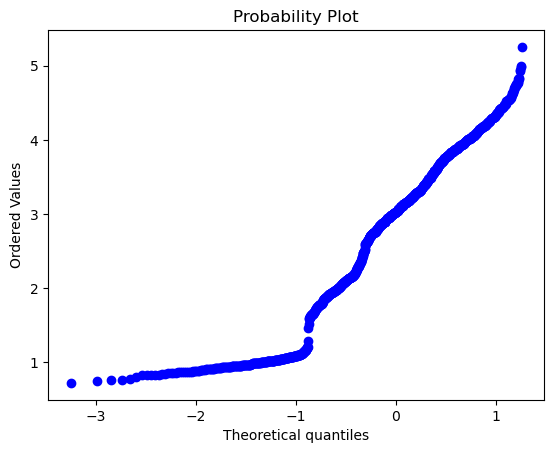

<Figure size 640x480 with 0 Axes>

In [234]:
# check normality with qq plot
from scipy import stats

stats.probplot(df1.JobSatisfaction, plot=plt)
plt.figure()

In [235]:
df1.BusinessTravel.value_counts()

BusinessTravel
Travel_Rarely        719
Travel_Frequently    224
Non-Travel           123
Name: count, dtype: int64

In [236]:
stats.shapiro(df1.JobSatisfaction)

ShapiroResult(statistic=nan, pvalue=1.0)

In [237]:
# H0: data comes from normal distribution
# H1: data does not come from normal distribution

# test not performed
stats.shapiro(df1.JobSatisfaction[df["BusinessTravel"]=="Travel_Rarely"])

ShapiroResult(statistic=nan, pvalue=1.0)

In [238]:
df.JobSatisfaction.shape

(1470,)

In [239]:
rarely = df.JobSatisfaction[df["BusinessTravel"]=="Travel_Rarely"]
frequently = df.JobSatisfaction[df["BusinessTravel"]=="Travel_Frequently"]
nontravel = df.JobSatisfaction[df["BusinessTravel"]=="Non-Travel"]

In [240]:
#H0: equal variances
#H1: non equal variances

from scipy.stats import levene

levene(rarely, frequently, nontravel, center = "mean")

LeveneResult(statistic=nan, pvalue=nan)

In [241]:
# normality confirmed so can perform anova

# H0: mu is equal amongst groups
# H1: at least one mu is different

from statsmodels.formula.api import ols
import statsmodels.api as sm

In [242]:
# model
model = ols("JobSatisfaction~BusinessTravel", data=df).fit()

# anova linear model
aov = sm.stats.anova_lm(model, type=2)
print(aov)

# accept H0 in this situation

                    df       sum_sq   mean_sq        F    PR(>F)
BusinessTravel     2.0     3.189243  1.594621  1.21763  0.296301
Residual        1184.0  1550.579642  1.309611      NaN       NaN


### 4.3 Use a Jupyter notebook to produce result sets from the provided dataset, such as scatter plots or regression models. Provide a summary of your findings.

In [243]:
## tables of results for statistical analysis
# can examine linear relationships of numeric features

# results from anova and normality testing

# results from chi2 

# results from baseline class?

In [244]:
df.head()

Age Attrition     BusinessTravel    DailyRate  \
0  41.920786       Yes      Travel_Rarely   990.110009   
1  51.589037        No  Travel_Frequently   276.776030   
2  33.131540       Yes      Travel_Rarely  1204.158501   
3  34.707073        No  Travel_Frequently  1352.752432   
4  24.790188        No      Travel_Rarely   485.053333   

               Department  DistanceFromHome  Education EducationField  \
0                   Sales          1.016716   1.770313  Life Sciences   
1  Research & Development               NaN   1.035333  Life Sciences   
2  Research & Development          2.198662   2.118801          Other   
3                   Sales          2.937851   3.670674  Life Sciences   
4  Research & Development          1.988953   1.120496        Medical   

   EmployeeCount  EmployeeNumber  ...  RelationshipSatisfaction StandardHours  \
0       1.033298        1.054148  ...                  1.012832     95.612654   
1       0.944859        2.107031  ...                  4.312008     85.370868   
2       0.810809        4.008125  ...                  2.332558     76.248084   
3       0.822976        4.587269  ...                  3.029591     75.888697   
4            NaN        7.228740  ...                       NaN     72.670937   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  \
0          0.000000           8.063833               0.000000        1.052104   
1          1.104642           8.965059               3.264952        2.526470   
2          0.000000           8.427238               3.004521        2.924784   
3          0.000000           7.662606               2.856001        3.117053   
4          0.953012           6.241733               2.814719        3.112317   

   YearsAtCompany YearsInCurrentRole  YearsSinceLastPromotion  \
0        5.795945           3.993896                 0.000000   
1       10.070232           7.937505                 1.032295   
2        0.000000           0.000000                 0.000000   
3        8.435324           5.563667                 2.845429   
4        2.040124           1.970786                 2.495949   

   YearsWithCurrManager  
0              4.594972  
1              5.901207  
2              0.000000  
3              0.000000  
4              2.219353  

[5 rows x 35 columns]

In [245]:
# below modelling with linear regression is used to explore the assumption that there is a lack of clear linear relationships between the features
# the coefficient of the linear regression line provides a metric to understand the linear relationship between two variables
# when viewed with correlation of the variables provides further insight into the type of relationships between the features
# assuming the relationships will be weak, polynomial features will be examined hoping to highlight some non linear relationships that could aid modelling

# there are some slight curves in the lines below but maybe not prominent enough to warrant inclusion in modelling...
# ...plus more data points obscure their expression

# this used the original dataset removing the null each time.. similar results are got with the prepared dataset

# when modelled are their differences in the targets?



#PerformanceRating
#JobSatisfaction

In [246]:
from sklearn.preprocessing import PolynomialFeatures

In [263]:
df.describe().T

count          mean          std          min  \
Age                       1323.0     36.635268     9.882161    14.544608   
DailyRate                 1323.0    802.030050   414.031025    86.828045   
DistanceFromHome          1323.0      9.091097     8.177870     0.750112   
Education                 1323.0      2.923447     1.072203     0.770362   
EmployeeCount             1323.0      0.999325     0.099656     0.628985   
EmployeeNumber            1323.0   1026.679166   610.480802     1.054148   
EnvironmentSatisfaction   1323.0      2.726443     1.129679     0.759655   
HourlyRate                1323.0     65.647722    21.469709    23.855272   
JobInvolvement            1323.0      2.743028     0.765568     0.722008   
JobLevel                  1323.0      2.058270     1.127018     0.715172   
JobSatisfaction           1323.0      2.715272     1.146786     0.724192   
MonthlyIncome             1323.0   6544.718401  4766.580903   891.481007   
MonthlyRate               1323.0  14364.334764  7269.420895  1567.502382   
NumCompaniesWorked        1323.0      2.654394     2.508952     0.000000   
PercentSalaryHike         1323.0     15.295717     3.995702     7.684723   
PerformanceRating         1323.0      3.149344     0.476027     2.116951   
RelationshipSatisfaction  1323.0      2.720431     1.115959     0.720696   
StandardHours             1323.0     80.241313     8.022535    53.793059   
StockOptionLevel          1323.0      0.814757     0.863076     0.000000   
TotalWorkingYears         1323.0     11.426152     8.075870     0.000000   
TrainingTimesLastYear     1323.0      2.811756     1.329044     0.000000   
WorkLifeBalance           1323.0      2.762825     0.761802     0.799138   
YearsAtCompany            1323.0      6.933624     6.046798     0.000000   
YearsInCurrentRole        1323.0      4.233363     3.658111     0.000000   
YearsSinceLastPromotion   1323.0      2.160710     3.221481     0.000000   
YearsWithCurrManager      1323.0      4.117695     3.594053     0.000000   

                                  25%           50%           75%  \
Age                         29.624982     34.951950     42.748741   
DailyRate                  456.479553    782.958705   1130.577949   
DistanceFromHome             2.147069      6.920808     13.584900   
Education                    2.122706      3.015658      3.700560   
EmployeeCount                0.931146      0.998949      1.067371   
EmployeeNumber             501.854842   1022.025017   1533.811096   
EnvironmentSatisfaction      1.894818      2.887313      3.676600   
HourlyRate                  47.701897     64.934490     83.038355   
JobInvolvement               2.177638      2.859143      3.179128   
JobLevel                     1.045228      1.936150      2.609707   
JobSatisfaction              1.846039      2.895032      3.676663   
MonthlyIncome             2961.844066   4957.070475   8268.002496   
MonthlyRate               8138.576694  14258.293365  20322.279885   
NumCompaniesWorked           0.948843      1.708812      3.959710   
PercentSalaryHike           12.195197     14.495151     17.745736   
PerformanceRating            2.845502      3.064551      3.335525   
RelationshipSatisfaction     1.909010      2.891235      3.639961   
StandardHours               74.882946     80.351400     85.664169   
StockOptionLevel             0.000000      0.913651      1.082523   
TotalWorkingYears            5.953221      9.306742     15.324548   
TrainingTimesLastYear        1.967328      2.690934      3.366949   
WorkLifeBalance              2.193390      2.899807      3.206117   
YearsAtCompany               2.673269      5.422160      9.238005   
YearsInCurrentRole           1.824392      2.968874      7.052591   
YearsSinceLastPromotion      0.000000      0.967140      2.586631   
YearsWithCurrManager         1.687177      2.939240      6.987964   

                                   max  
Age                          69.402515  
DailyRate                  1

In [267]:
def linear_relationship_explore(df, v1="PerformanceRating"):
    v1 = v1

    for i in df.select_dtypes(include='number').columns:
        _ = df.copy()
        try:   
            v2 = i
            if v1 == v2:
                pass
            else:
                    
                _ = _.dropna(subset=[v1, v2])
                
                # plotting subset
                _ = _.iloc[:200,:]
                
                plt.scatter(_[v1], _[v2])
                
                # Adding labels and a title
                plt.xlabel(v1)
                plt.ylabel(v2)
                plt.title(f'Scatter Plot of {v1} and {v2}')
                
                # Fit a linear regression line
                slope, intercept = np.polyfit(_[v1], _[v2], 1)
                print(f"Slope: {slope}")
                plt.plot(_[v1], slope * _[v1] + intercept, color='red')
                
                
                # Display the plot
                plt.show()
            
            
        except:
            pass
        

Slope: 1.0625380740814756


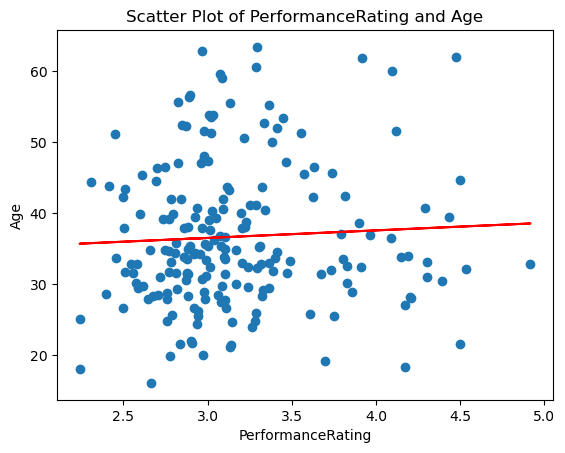

Slope: -52.238011280078


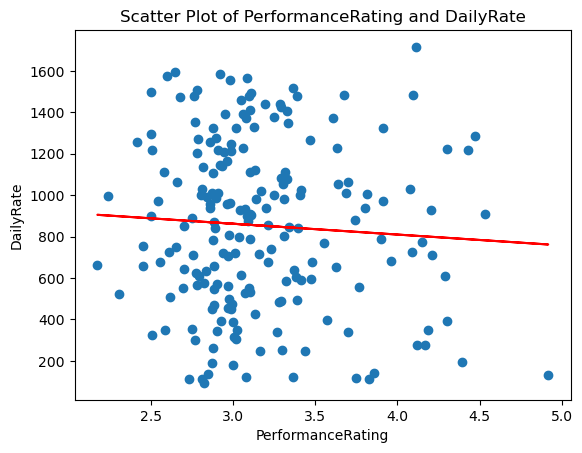

Slope: -1.1204176589756


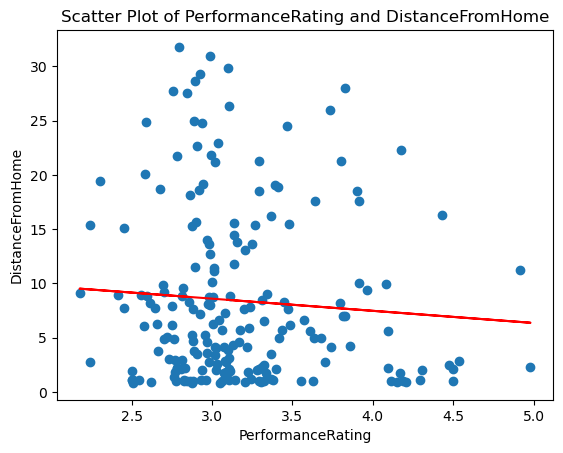

Slope: 0.03278971213428034


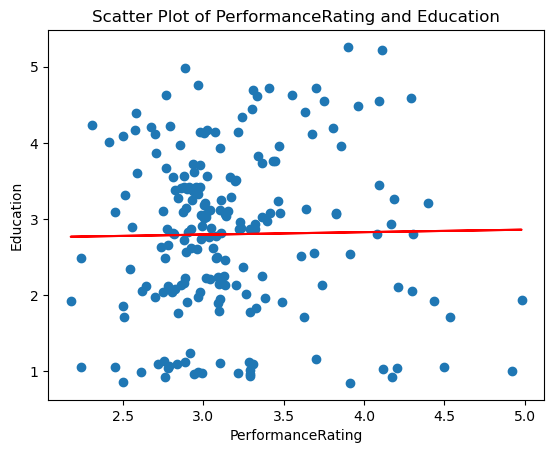

Slope: -0.012322272573598709


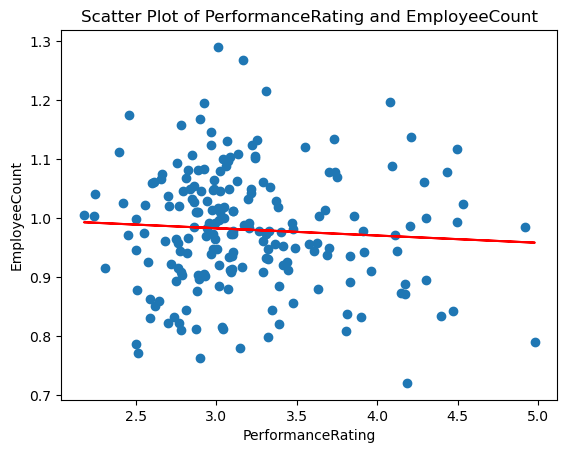

Slope: -14.88616159635823


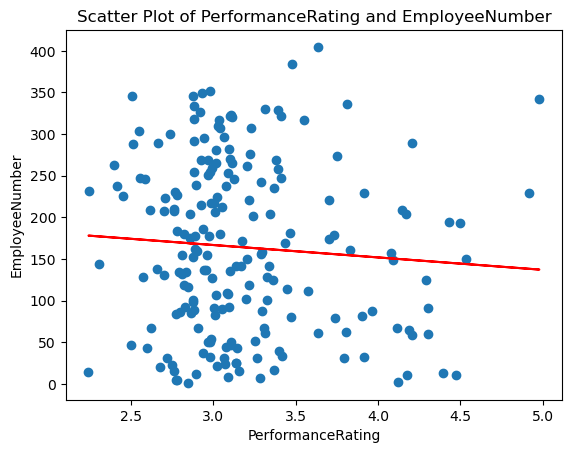

Slope: -0.3916172281206093


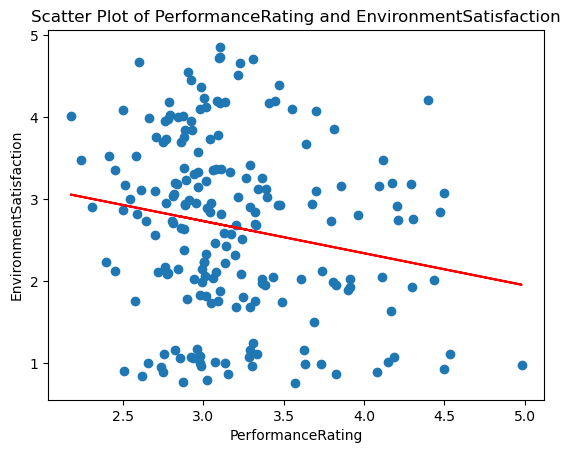

Slope: -1.6331801531312324


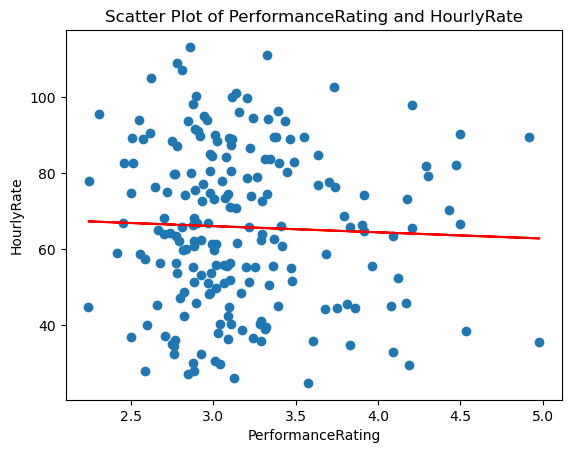

Slope: -0.10563018301709377


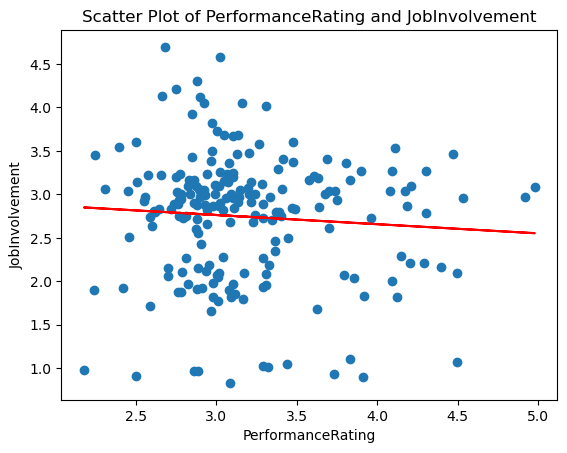

Slope: -0.13573957302731582


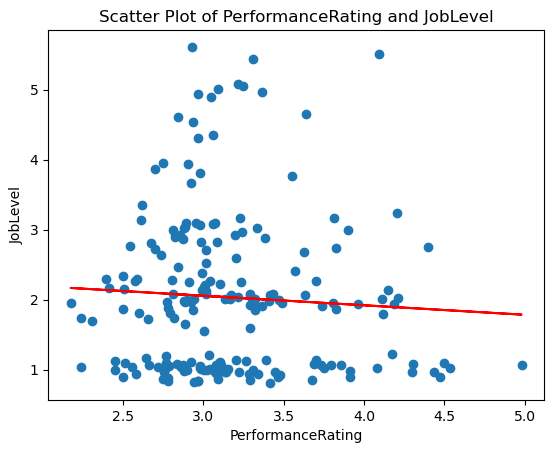

Slope: -0.010091693018078088


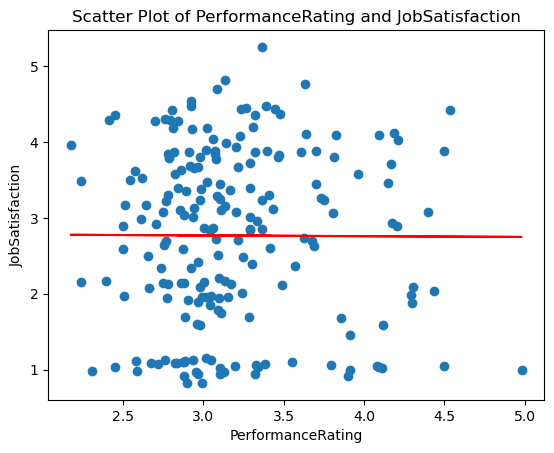

Slope: -22.072072822115565


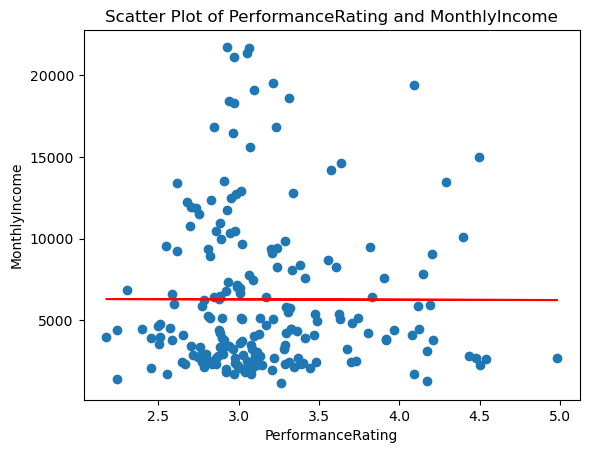

Slope: -1076.5959539973794


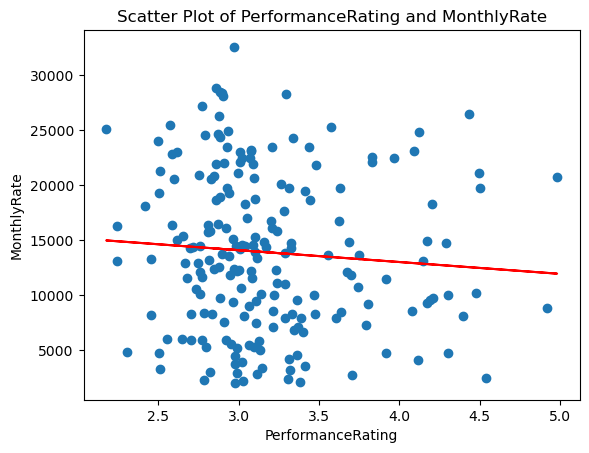

Slope: 0.6421331520168811


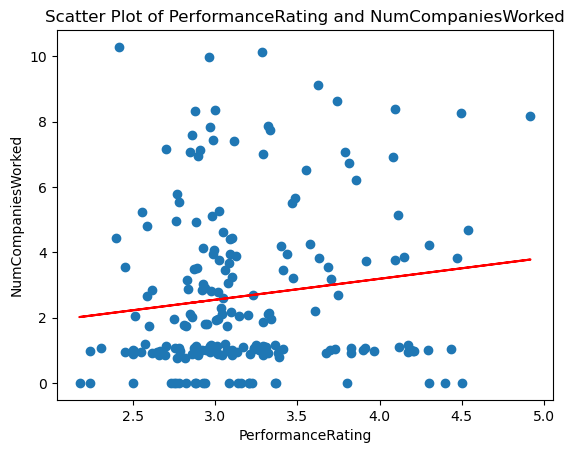

Slope: 4.929324076513791


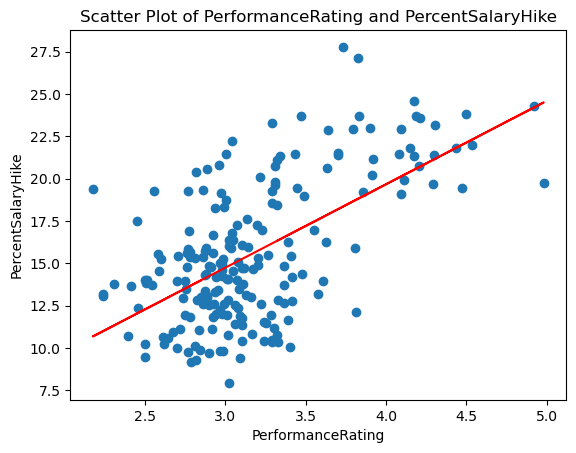

Slope: -0.15554071771861874


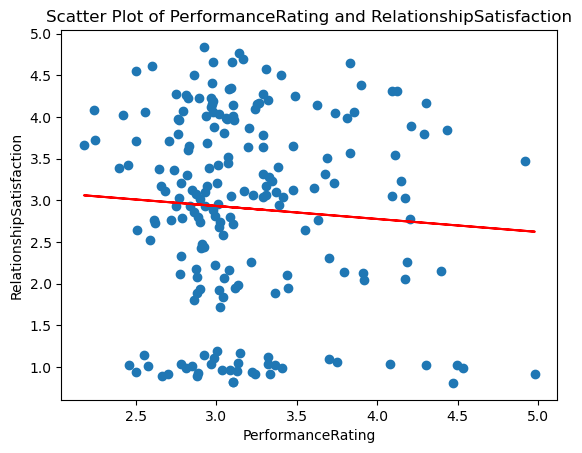

Slope: -0.280645674230347


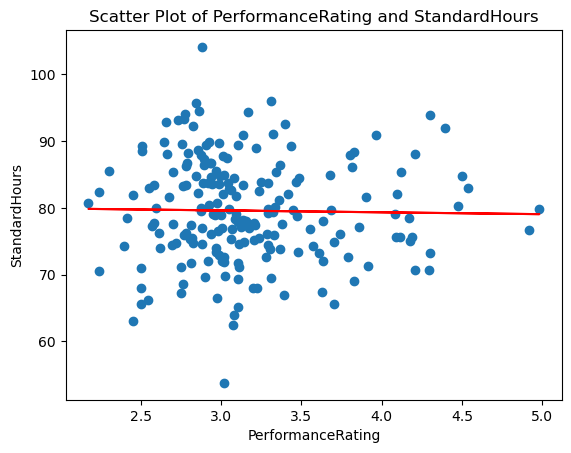

Slope: 0.014040768640083938


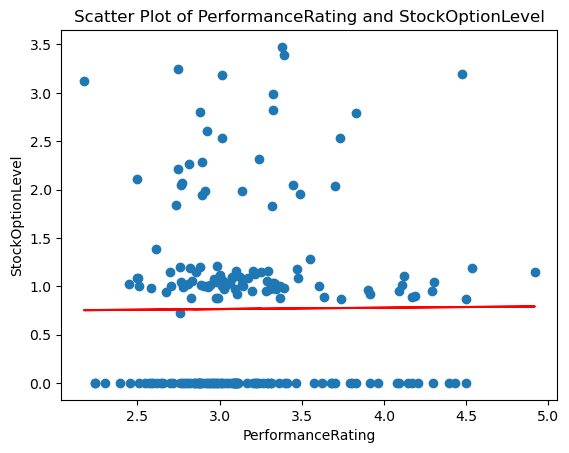

Slope: 0.2684422970409966


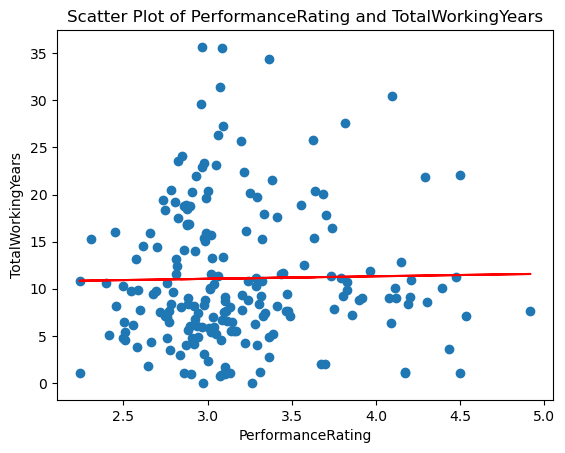

Slope: -0.11193690749474852


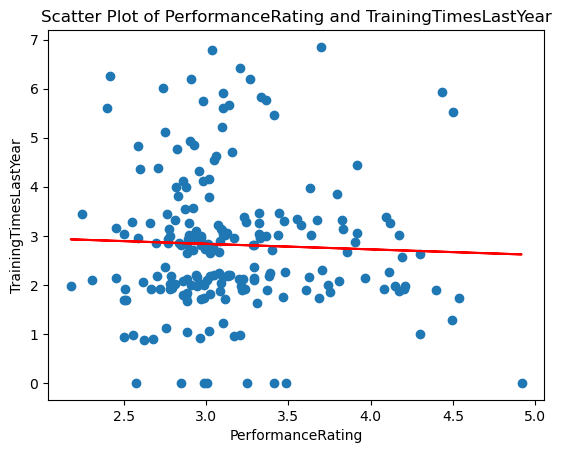

Slope: 0.07865274702283663


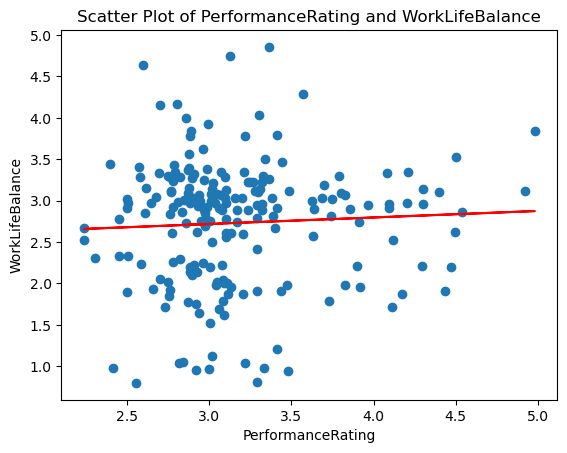

Slope: 0.2656212598771654


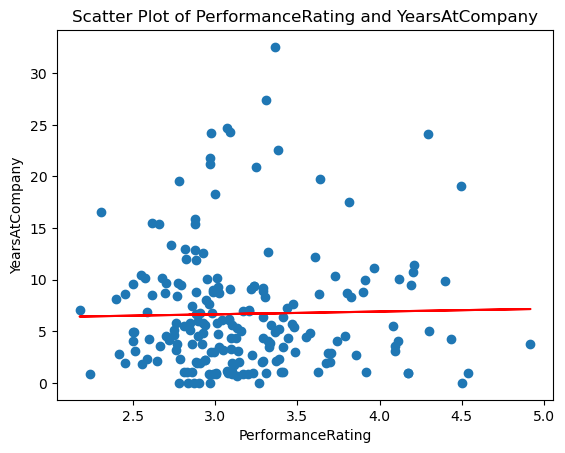

Slope: -0.45250933550225697


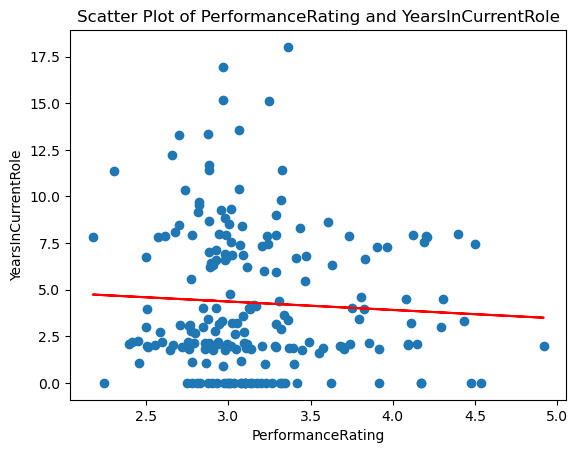

Slope: 0.2718088925493525


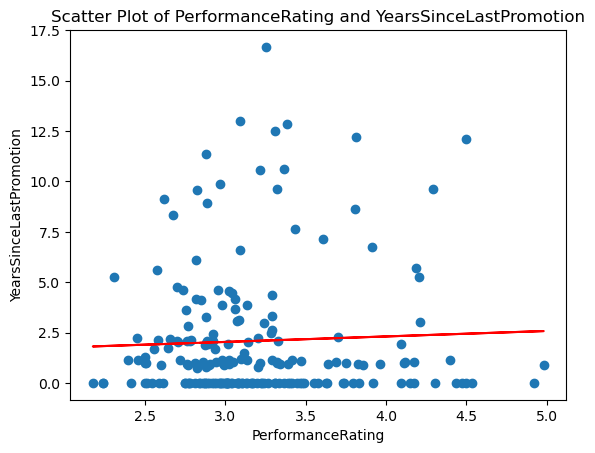

Slope: -0.4958541382737103


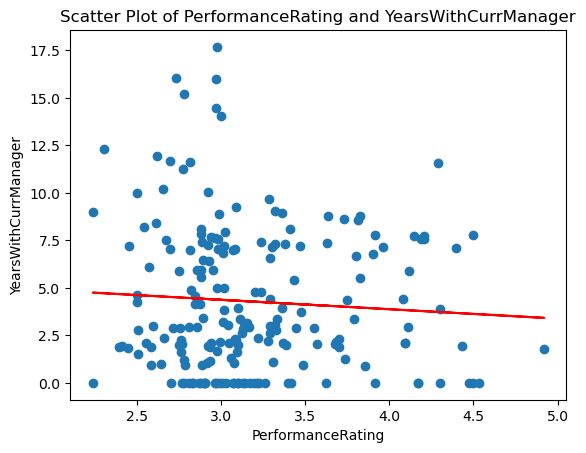

In [268]:
# model both interested features
linear_relationship_explore(df)

-0.5054718292594269


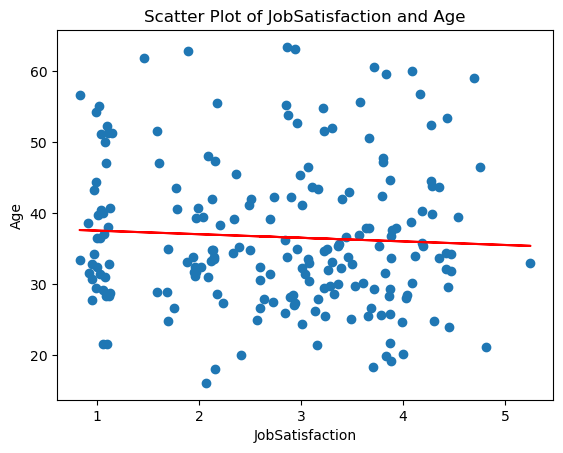

-9.859516258336892


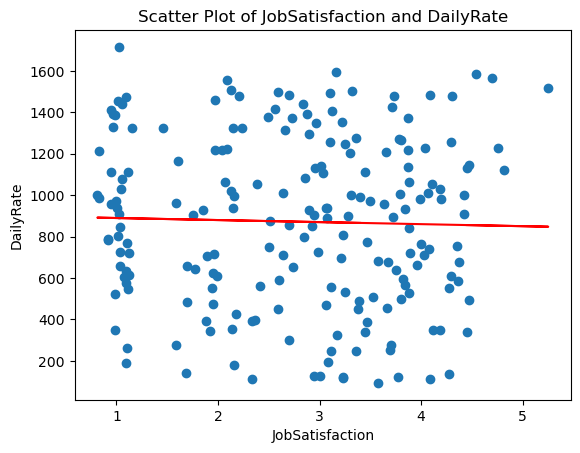

0.6962860842682198


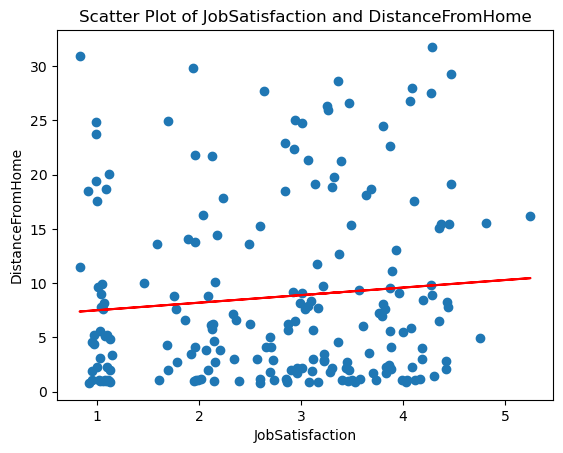

-0.03270766606949913


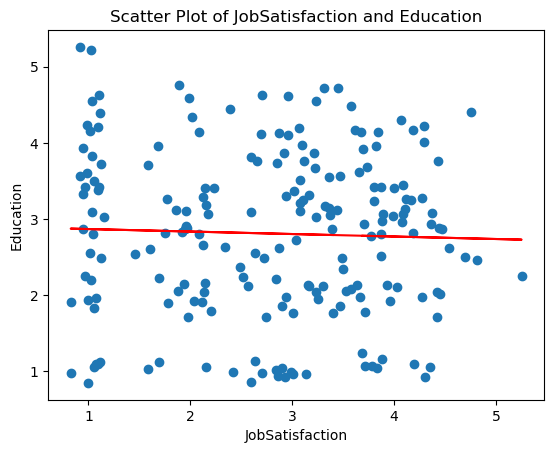

0.002752652174447612


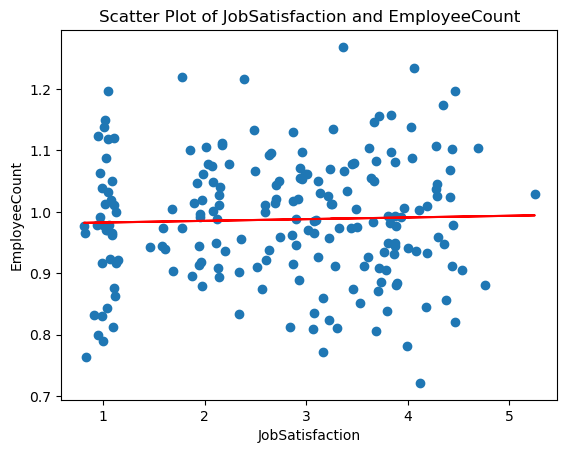

-1.4250304476249558


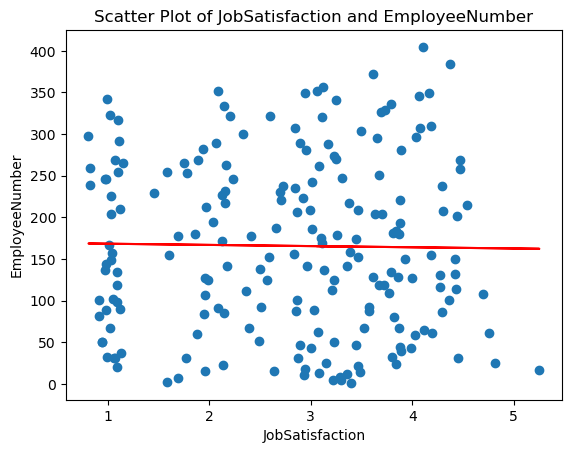

0.014366506642224214


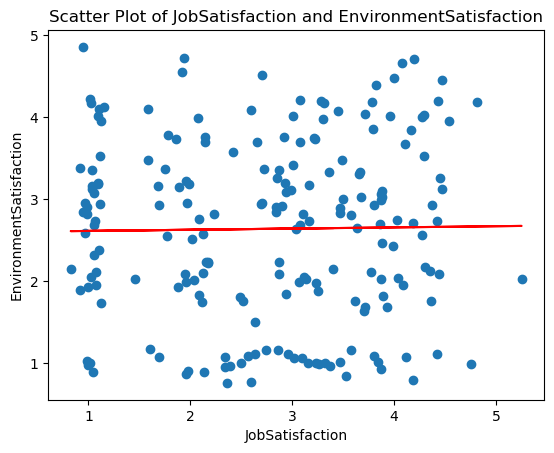

-0.48325538476763324


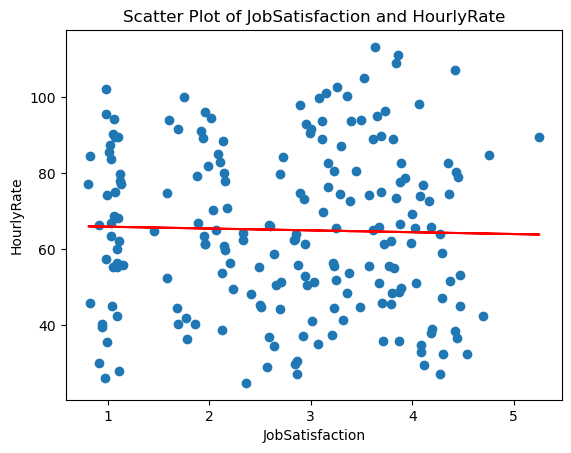

-0.04586717266943007


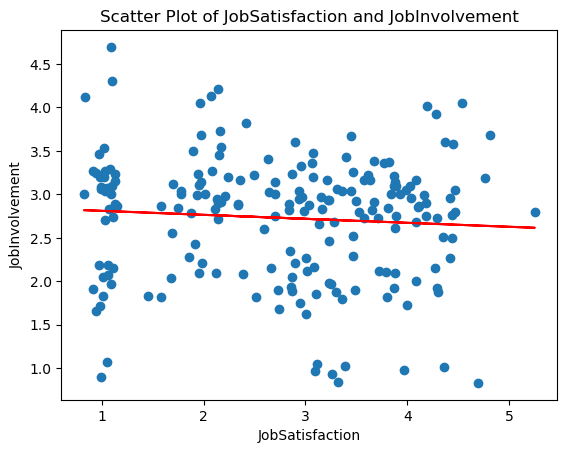

0.10029863021958482


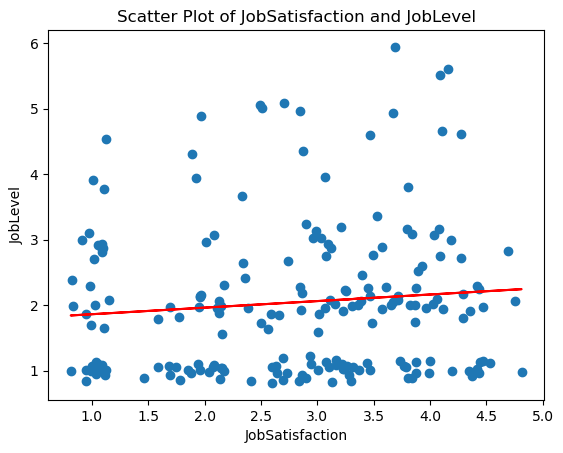

62.40801620705505


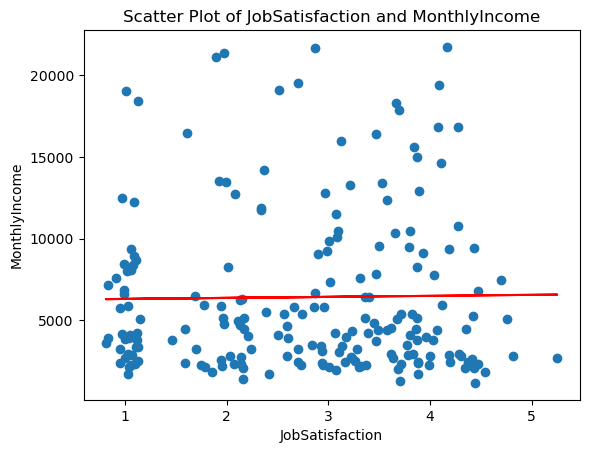

179.30826128176008


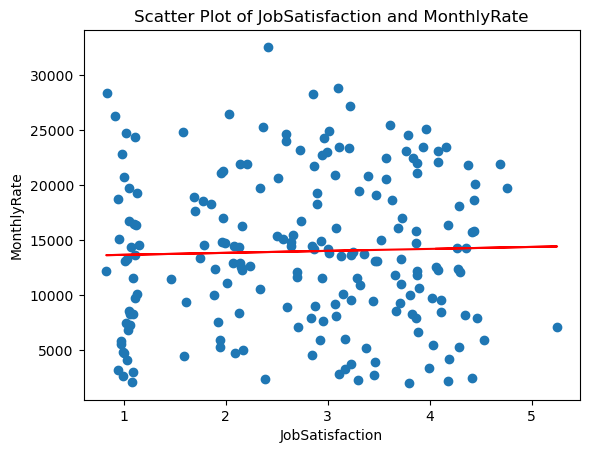

-0.26163374925140154


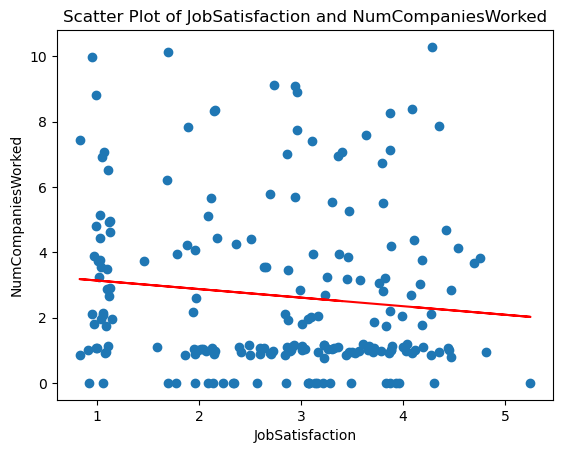

-0.12202658657239203


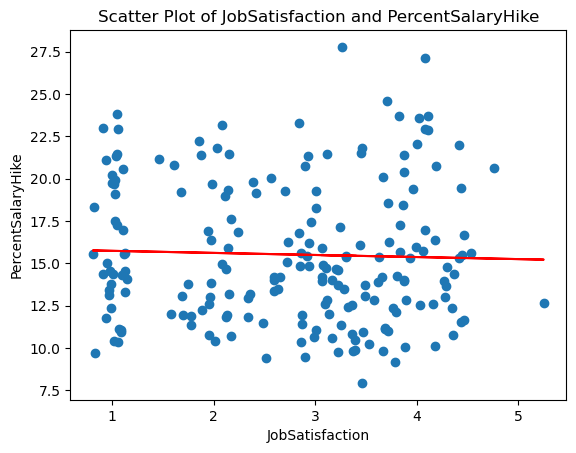

-0.001994437804510667


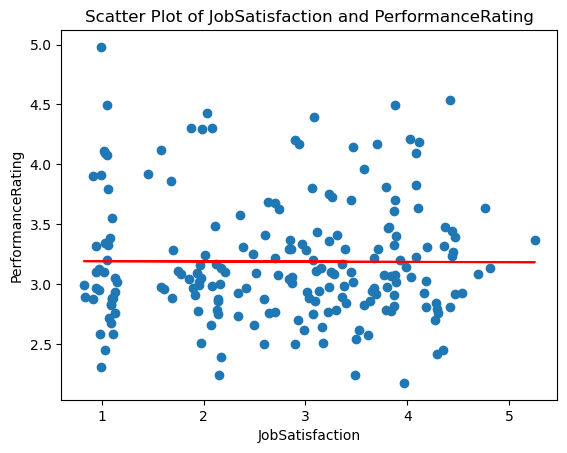

0.010866180965872625


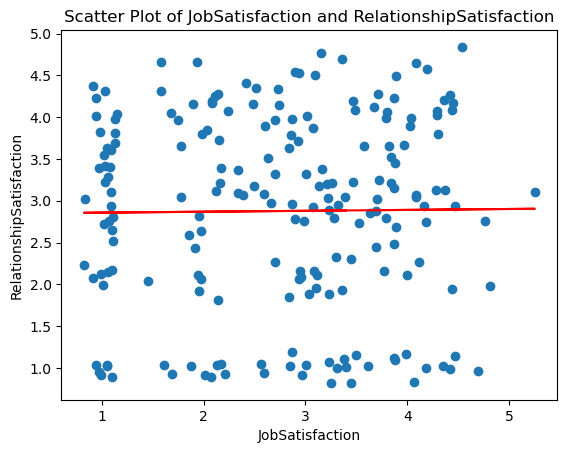

0.43526923686533153


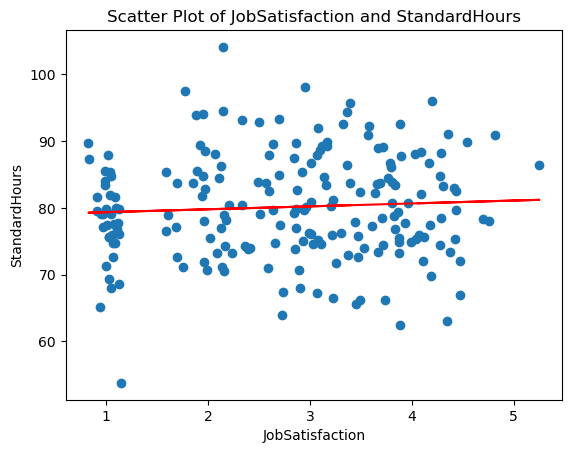

0.02142941400815725


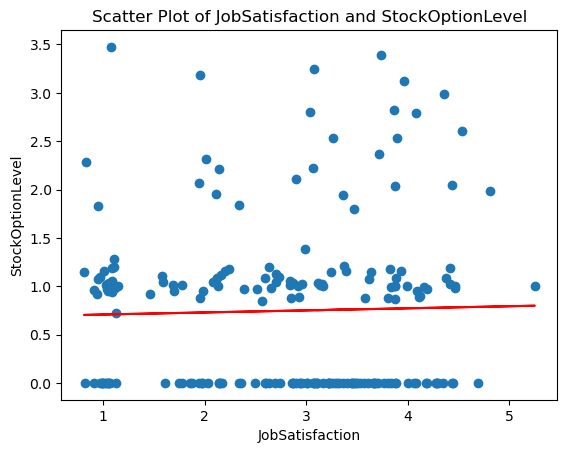

-0.24260006563476183


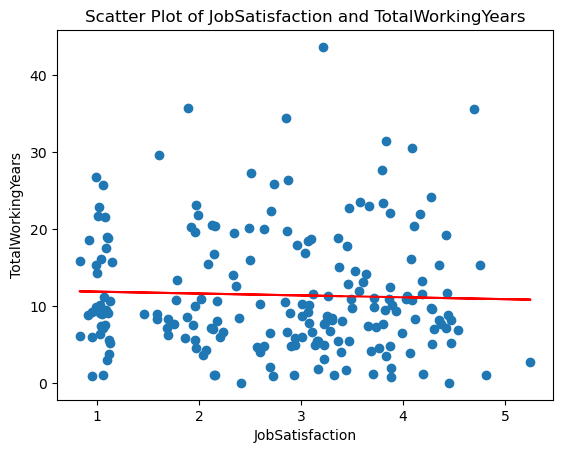

-0.12697332611807166


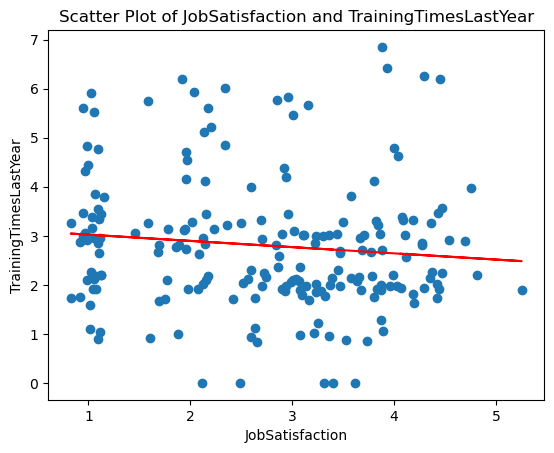

-0.05123278252056934


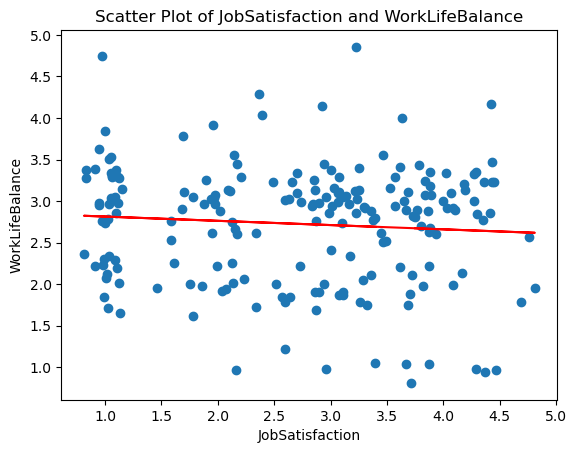

0.04214755413715695


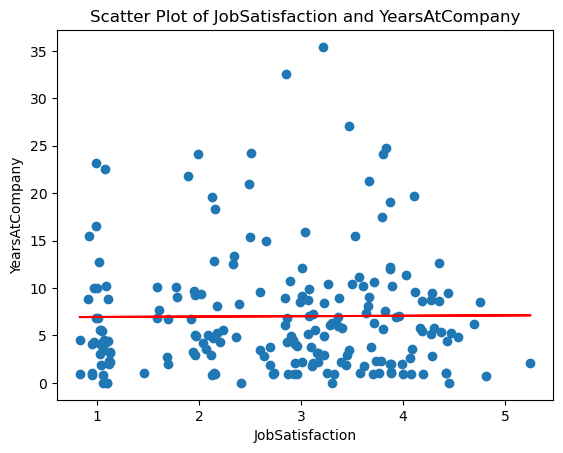

-0.0485412377791922


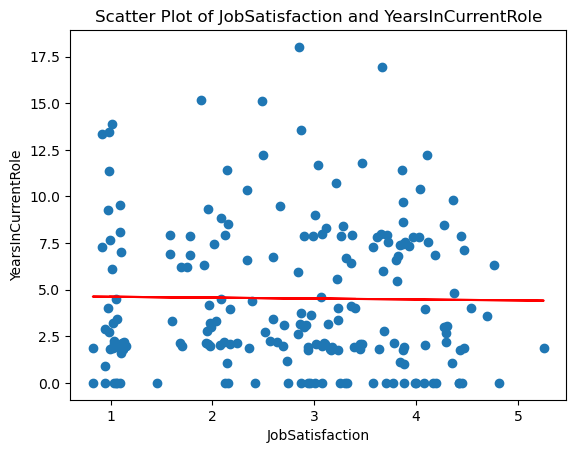

-0.16525708837933212


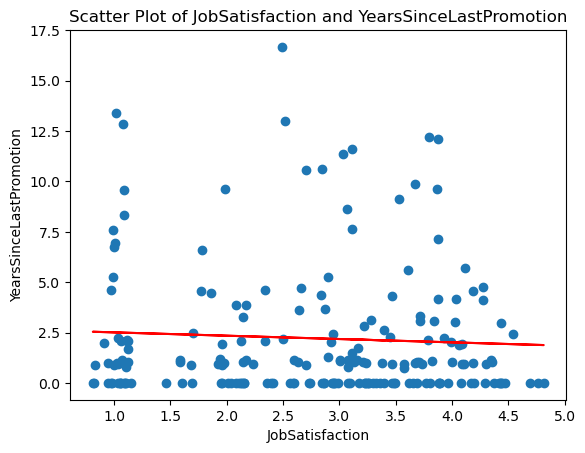

0.09814888444445898


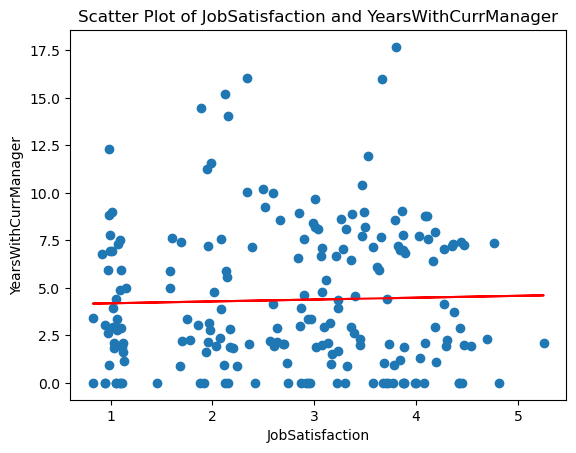

In [266]:
linear_relationship_explore(df, v1="JobSatisfaction")

In [250]:
#from sklearn.preprocessing import PolynomialFeatures

#degree = 3  # Adjust the degree as needed
#model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

#X = _[[v1]].values.reshape(-1, 1)
#y = _[v2]

# Fit the model
#model.fit(X, y)

# Plotting the data and the model
#plt.scatter(_[v1], _[v2])
#plt.plot(_[v1], model.predict(X), color='red')

#coefficients = model.named_steps['linearregression'].coef_

# Intercept (constant term)
#intercept = model.named_steps['linearregression'].intercept_

#print("Coefficients:", coefficients)
#print("Intercept:", intercept)

# Adding labels and a title
#plt.xlabel('Variable X')
#plt.ylabel('Variable Y')
#plt.title('Polynomial Regression')

# Display the plot
#plt.show()

In [251]:
#df[v1].corr(df[v2])

In [252]:
rf3sf.3wrfw3rw

SyntaxError: invalid decimal literal (1836963488.py, line 1)

## 5. Module: Machine Learning

### 5.1. 

In [ ]:
# machine learning trial
# class function may be not working right.. or data is really bad

# some progress has been seen classifying JobSatisfaction...
# ...PerformanceRating has been lacking all round...


### 5.2. Machine Learning models can be used for Prediction, Classification, and Clustering. You can choose features for the machine learning models based on feature selection methods, such as random or any other method. The selection of hyperparameters for the ML models should be performed using hyperparameter tuning, such as GridSearchCV. Obtain the best accuracy using optimal values the hyperparameters.

In [ ]:
# using best features from data preparation

In [ ]:
df = df_prepared.copy()

In [ ]:
cat = list(df.select_dtypes(include='object').columns)
nums = list(df.select_dtypes(include='number').columns)

In [ ]:
ord = ["Education", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel", "JobSatisfaction",
                   "PerformanceRating", "RelationshipSatisfaction", "StockOptionLevel"]
#for i in ord:
#    nums.remove(i)

ords = []
    
for i in ord:
    if i in nums:
        ords.append(i)
        nums.remove(i)
        

In [ ]:
knn_imputer = KNNImputer()
df[nums] = knn_imputer.fit_transform(df[nums])


df[cat] = df[cat].fillna("Unknown") # unknowns are filled for this in prepared dataset
modes = df[ords].mode().iloc[0]
df[ords] = df[ords].fillna(modes)

In [ ]:
df[ords] = df[ords].astype(int)

In [ ]:
# set target
target = "Attrition"
cat.remove(target)

In [ ]:
y = df[target]
X = df.drop([target], axis=1)

In [ ]:
X[ords] = X[ords].astype(int)

In [ ]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X[nums])
scaled_df = pd.DataFrame(scaled_df, columns=nums)

In [ ]:
encoded_df = pd.get_dummies(X[cat], columns=cat, drop_first=True).reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
ordinal_df = encoder.fit_transform(X[ords])
ordinal_df = scaler.fit_transform(ordinal_df)
ordinal_df = pd.DataFrame(ordinal_df, columns=ords)

In [ ]:
merged_df = pd.concat([scaled_df, encoded_df], axis=1)
merged_df = pd.concat([merged_df, ordinal_df], axis=1)

In [ ]:
label_encoder=LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_df, y, test_size=0.3, random_state=42)

In [ ]:
rus = RandomOverSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

model = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


y_pred = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Best Parameters:", best_params)

print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Best Parameters:", best_params)

print("Classification Report:")
print(classification_report(y_test, y_pred))

### 3. You should train and test the Machine learning models in the case of supervised learning for different (at least 2 splits) and use appropriate metrics for unsupervised learning. Use k-fold (10 or 20 or ) cross-validation to provide authenticity of the modelling outcomes.

#### 10% split

In [ ]:
model = LogisticRegression(max_iter=1000, C=1, penalty='l2', solver='liblinear')
model_knn = KNeighborsClassifier(n_neighbors=3, p=2, weights="uniform")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_df, y, test_size=0.1, random_state=42)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

#### 20% split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_df, y, test_size=0.2, random_state=42)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
feature_names = X_train.columns

# Create a DataFrame with feature names and their corresponding coefficients
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_[0]
})

# Sort the DataFrame by the absolute values of coefficients to see the most influential features
coefficients['AbsoluteCoefficient'] = coefficients['Coefficient'].abs()
sorted_coefficients = coefficients.sort_values(by='AbsoluteCoefficient', ascending=False)

# Display the sorted coefficients
sorted_coefficients.head(20)

In [ ]:
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

#### 30% split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(merged_df, y, test_size=0.3, random_state=42)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))